In [14]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import random
from specparam import SpectralModel

import pickle
from IPython.display import clear_output
import time
#import  as catch22

In [3]:
eeg_dict = {}
eeg_name_list = []
eeg_count = 79
for i in np.arange(eeg_count)+1:
    eeg_dict['eeg'+str(i)] = mne.io.read_raw_edf("eeg"+str(i)+".edf")
    eeg_name_list.append('eeg'+str(i))
# eeg_dict['eeg1'] = mne.io.read_raw_edf("eeg1.edf

# eeg_name_list = [ 'eeg1',  'eeg2',  'eeg3',  'eeg4',  'eeg5',  'eeg6',  'eeg7',
#                   'eeg8',  'eeg9', 'eeg10', 'eeg11', 'eeg12', 'eeg13', 'eeg14',
#                  'eeg15', 'eeg16', 'eeg17', 'eeg18', 'eeg19', 'eeg20', 'eeg21',
#                  'eeg22', 'eeg23', 'eeg24', 'eeg25', 'eeg26', 'eeg27', 'eeg28',
#                  'eeg29', 'eeg30', 'eeg31', 'eeg32', 'eeg33', 'eeg34', 'eeg35',
#                  'eeg36', 'eeg37', 'eeg38', 'eeg39', 'eeg40', 'eeg41', 'eeg42',
#                  'eeg43', 'eeg44', 'eeg45', 'eeg46', 'eeg47', 'eeg48', 'eeg49',
#                  'eeg50', 'eeg51', 'eeg52', 'eeg53', 'eeg54', 'eeg55', 'eeg56',
#                  'eeg57', 'eeg58', 'eeg59', 'eeg60', 'eeg61', 'eeg62', 'eeg63',
#                  'eeg64', 'eeg65', 'eeg66', 'eeg67', 'eeg68', 'eeg69', 'eeg70',
#                  'eeg71', 'eeg72', 'eeg73', 'eeg74', 'eeg75', 'eeg76', 'eeg77',
#                  'eeg78', 'eeg79', ]

for eeg_name in eeg_name_list:
    try:
        eeg_dict[eeg_name].drop_channels(['ECG EKG-REF', 'Resp Effort-REF'])
    except:
        print(" ")
    try:
        eeg_dict[eeg_name].drop_channels(['ECG EKG', 'Resp Effort'])
    except:
        print(" ")

Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg6.edf...
EDF file detected
Set

In [4]:
no_annot_EEGs = [ '3', '10', '18', '27', '28', '29', '30', '32',
                 '35', '37', '42', '45', '48', '49', '53', '55',
                 '57', '58', '59', '60', '61', '70', '72']

annot_A = pd.read_csv('annotations_2017_A.csv')
annot_B = pd.read_csv('annotations_2017_B.csv')
annot_C = pd.read_csv('annotations_2017_C.csv')

annot_A = annot_A.drop(labels=no_annot_EEGs, axis=1)
annot_B = annot_B.drop(labels=no_annot_EEGs, axis=1)
annot_C = annot_C.drop(labels=no_annot_EEGs, axis=1)

two_annots = ['8', '23', '33', '54', '64', '68', '74']

annot_A = annot_A.drop(labels=two_annots, axis=1)
annot_B = annot_B.drop(labels=two_annots, axis=1)
annot_C = annot_C.drop(labels=two_annots, axis=1)

annot_eeg_indices = list(annot_A.columns)

# only in A:  2
# only in B: 24
# only in C:  6, 12, 26, 43, 46, 56, 65

annot_A = annot_A.drop(labels=['6', '24', '26', '43', '46', '56', '65'], axis=1)
annot_B = annot_B.drop(labels=['6',  '2', '26', '43', '46', '56', '65'], axis=1)
annot_C = annot_C.drop(labels=['2', '24'], axis=1)

In [17]:
n_eeg_files = 79  # Total number of EEG files
n_components = 19
random_state = 97
max_iter = 800
file_prefix = "eeg"
file_suffix = ".edf"

clean_dict = {}
montage = mne.channels.make_standard_montage('standard_1020', 0.0557)
tic = time.perf_counter()

for i in annot_eeg_indices:
    file_name = file_prefix + i + file_suffix
    try:
        # Read the raw EDF file
        raw = mne.io.read_raw_edf(file_name, preload=True).copy()

        # Drop unneccessary channels
        try:
            raw.drop_channels(['ECG EKG-REF', 'Resp Effort-REF'])
        except:
            print(" ")
        try:
            raw.drop_channels(['ECG EKG', 'Resp Effort'])
        except:
            print(" ")

        # Create list of channel names to estimate physical channel positions in headset
        channel_names = raw.info.ch_names.copy()
        for j in range(len(channel_names)):
            channel_names[j] = channel_names[j][4:-4]
        k = 0
        for name in channel_names:
            raw.info['chs'][k]['loc'] = np.append(montage.get_positions()['ch_pos'][name], np.zeros(9))
            k = k + 1

        raw = raw.filter(l_freq=0, h_freq=30)
        
        # Initialize and fit the ICA
        ica = mne.preprocessing.ICA(n_components=n_components,
                                    random_state=random_state,
                                    max_iter=max_iter
                                   )
        ica.fit(raw)
        # Apply ICA to the raw data to get the cleaned data
        raw_clean = ica.apply(raw.copy())

        clean_dict[file_prefix + i] = raw_clean

        toc = int(time.perf_counter()-tic)
        clear_output(wait=True)
        print(int(toc/60), toc%60)
        print(f"Processed and cleaned {file_name} successfully.")
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

40 55
Processed and cleaned eeg79.edf successfully.


In [26]:
tic = time.perf_counter()
for i in annot_eeg_indices:
    eeg_name = 'eeg' + i
    file_name = 'processed_' + eeg_name + '.edf'
    mne.export.export_raw(file_name, clean_dict[eeg_name])

    clear_output(wait=True)
    toc = int(time.perf_counter() - tic)
    print('EEG'+i+' Stored.')
    print('Time Elapsed:', int(toc/60), ':', toc%60)

EEG79 Stored.
Time Elapsed: 36 : 17


In [5]:
combined_annot = []
for i in annot_eeg_indices:
    if (i != '2' and i != '6' and i != '12' and i !='24' and i !='26' and i !='43' and i !='46' and i !='56' and i !='65'):
        annot_col_mean = np.mean(np.array([annot_A[i], annot_B[i], annot_C[i]]),0)
        annot_col_mean = annot_col_mean[~np.isnan(annot_col_mean)]
        
        new_annot_col = (annot_col_mean + 1/3).astype(int)
        
        combined_annot.append(new_annot_col)
    elif(i == '2'):
        annot_col = np.array(annot_A[i])
        new_annot_col = annot_col[:3760]
        # cause half of the EEG data is missing
        
        combined_annot.append(new_annot_col)
    elif(i == '24'):
        annot_col = np.array(annot_B[i])
        new_annot_col = annot_col[~np.isnan(annot_col)]
        
        combined_annot.append(new_annot_col)
    else:
        annot_col = np.array(annot_C[i])
        new_annot_col = annot_col[~np.isnan(annot_col)]
        
        combined_annot.append(new_annot_col)
    # print(i)
    # print(sum(new_annot_col))

Effective window size : 8.000 (s)


C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


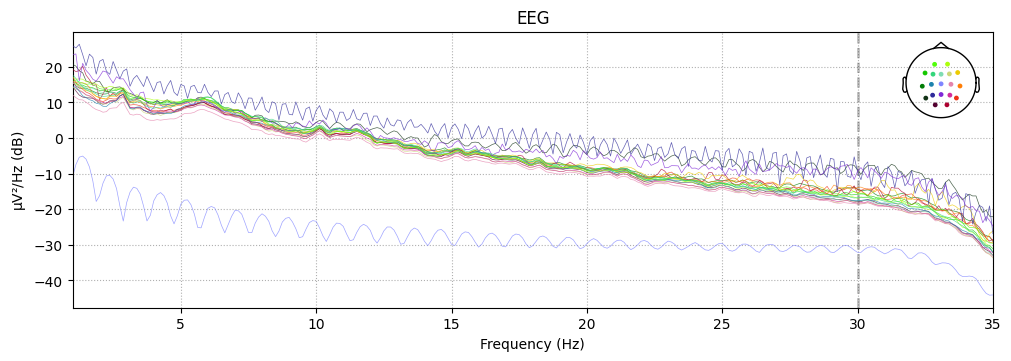

In [106]:
# raw.compute_psd().
clean_dict['eeg1'].compute_psd(fmin=1, fmax=35).plot()

In [72]:
raw = mne.io.read_raw_edf('eeg12.edf', preload=True).drop_channels(['ECG EKG', 'Resp Effort']).copy()

# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=5, random_state=97, max_iter=800)
ica.fit(raw)

# UNECESSARY
    # ica.exclude = [1, 2]
    # raw.set_montage('easycap-M1')
    # ica.plot_properties(raw)

raw_clean = ica.apply(raw.copy())

Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1143807  =      0.000 ...  4467.996 secs...
Fitting ICA to data using 19 channels (please be patient, this may take a while)


C:\Users\victo\AppData\Local\Temp\ipykernel_15440\4570539.py:6: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 19 components
Fitting ICA took 26.7s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


In [6]:
i = 0
for eeg_name in eeg_name_list:
    print(len(clean_dict[eeg_name].info.ch_names), i)
    i = i +1

NameError: name 'clean_dict' is not defined

In [109]:
montage = mne.channels.make_standard_montage('standard_1020', 0.0557)

i = 'a'
j = 0
for eeg_name in eeg_name_list:
    # i = 0
    for name in channel_names:
        eeg_dict[eeg_name].info['chs'][i]['loc'] = np.append(montage.get_positions()['ch_pos'][name], np.zeros(9))
        print(eeg_dict[eeg_name].info['chs'][i]['loc'], "    ", )
        i = i + 1
        j = j + 1

TypeError: list indices must be integers or slices, not str

In [267]:
# sum(combined_annot[0] == annot_A["0"])
# np.array(annot_A['1'])[:len(combined_annot[0])]
# ind = 0
# sum(combined_annot[ind] == np.array(annot_A[annot_eeg_indices[ind]])[:len(combined_annot[ind])])
# np.array(annot_A[annot_eeg_indices[ind]])[:len(combined_annot[ind])]


# len(np.array(annot_A['4'])[~np.isnan(np.array(annot_A['4']))])
np.where(np.array(annot_eeg_indices) == ind)[0][0]

2

In [7]:
three_annot_indices = list(annot_B.columns)
three_annot_indices.remove('24')

annot_A_correct_count = []
annot_B_correct_count = []
annot_C_correct_count = []

annot_A_perf = []
annot_B_perf = []
annot_C_perf = []

for ind in three_annot_indices:
    i = np.where(np.array(annot_eeg_indices) == ind)[0][0]
    # print(ind, i)
    annot_A_array_i = np.array(annot_A[ind])
    annot_B_array_i = np.array(annot_B[ind])
    annot_C_array_i = np.array(annot_C[ind])
    
    annot_A_array_i = annot_A_array_i[~np.isnan(annot_A_array_i)]
    annot_B_array_i = annot_B_array_i[~np.isnan(annot_B_array_i)]
    annot_C_array_i = annot_C_array_i[~np.isnan(annot_C_array_i)]
    
    # annot_A_correct_count.append(sum(combined_annot[i] == annot_A_array_i))
    # annot_B_correct_count.append(sum(combined_annot[i] == annot_B_array_i))
    # annot_C_correct_count.append(sum(combined_annot[i] == annot_C_array_i))
    annot_A_correct_count = sum(combined_annot[i] == annot_A_array_i)
    annot_B_correct_count = sum(combined_annot[i] == annot_B_array_i)
    annot_C_correct_count = sum(combined_annot[i] == annot_C_array_i)

    annot_A_perf.append(annot_A_correct_count / len(combined_annot[i]))
    annot_B_perf.append(annot_B_correct_count / len(combined_annot[i]))
    annot_C_perf.append(annot_C_correct_count / len(combined_annot[i]))


# for i in range(len(three_annot_indices)):
#     # print(annot_A_correct_count[i] / len(combined_annot[i]))
#     annot_A_perf.append(annot_A_correct_count[i] / len(combined_annot[i]))
#     annot_B_perf.append(annot_B_correct_count[i] / len(combined_annot[i]))
#     annot_C_perf.append(annot_C_correct_count[i] / len(combined_annot[i]))

print("Annotator A Performance:", np.mean(annot_A_perf))
print("Annotator B Performance:", np.mean(annot_B_perf))
print("Annotator C Performance:", np.mean(annot_C_perf))

Annotator A Performance: 0.972916543247022
Annotator B Performance: 0.9356992513182084
Annotator C Performance: 0.9688974979450296


In [8]:
np.where(np.array(three_annot_indices) == str(1))[0][0]
# np.array(three_annot_indices)

0

In [250]:
ind = 0
print(sum(combined_annot[ind] == np.array(annot_A[three_annot_indices[ind]])[:len(combined_annot[ind])]),
      # sum(combined_annot[ind]) - 
      # len(np.array(annot_A[three_annot_indices[ind]])[:len(combined_annot[np.where(np.array(three_annot_indices) == str(ind))[0][0]])]))
      len(np.array(annot_A[three_annot_indices[ind]])[~np.isnan(np.array(annot_A[three_annot_indices[ind]]))])
     )

6748 6993


# Increasing Bin Size

In [131]:
for i in range(len(combined_annot)):
    print(sum(combined_annot[i]))

1543
65.0
925
3213
491.0
616
880
94
31.0
1367
2280
1282
1710
208
2281
1105
42
939
295.0
208
96.0
180
452
491
3152
2264
582
8739
56.0
359
83.0
209
905
324
89
814.0
382
858
94.0
1736
1503
2723
207
1081
920
490
364
2195
257


In [55]:
index_list = []
ictal_time_list = []

for i, j in enumerate(combined_annot[0][:-1]):
    index_list.append(i)
    ictal_time_list.append(j)

In [61]:
event_start = 0
event_end = index_list[-1]
bin_size = 2
event_window = list(np.arange(event_start, event_end, bin_size))
total_bins = len(event_window)
binned_spikes = np.histogram(combined_annot[0][:-1],
                             total_bins,
                             range = (event_start, event_end)
                            )[0]

In [62]:
binned_spikes

array([6992,    0,    0,    0,    0,    0,    0,    0,    0,    0, ...,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int64)

In [15]:
combined_annot['1'] = np.mean([annot_A['1'], annot_B['1'], annot_C['1']], axis=0).reshape((15416,1))
(combined_annot['1'].to_numpy()+1/3)

TypeError: list indices must be integers or slices, not str

Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


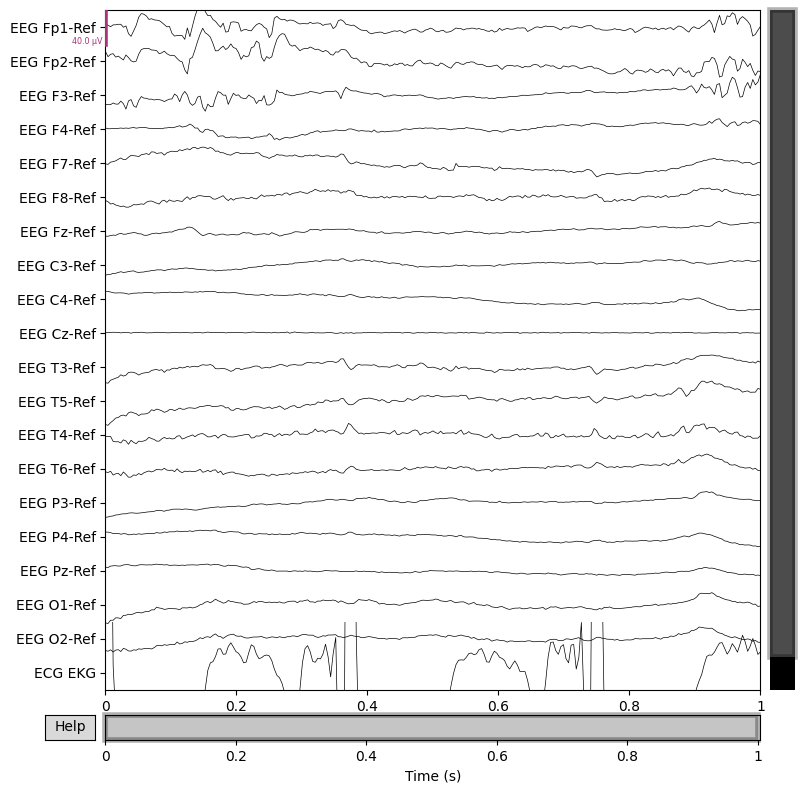

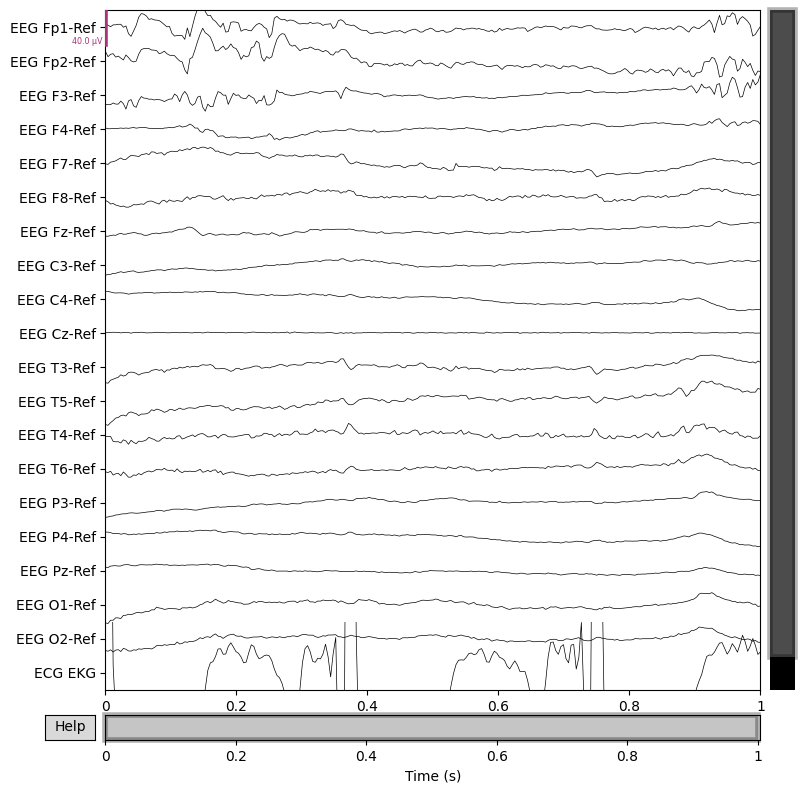

In [516]:
eeg_dict['eeg12'] = mne.io.read_raw_edf("eeg12.edf")
ictal_index_example = np.where(combined_annot[8] == 1)[0][0]
eeg_dict['eeg12'].crop(tmin= ictal_index_example,
                       tmax=ictal_index_example+1).plot()



In [120]:
channel_names1 = clean_dict['eeg1'].info.ch_names.copy()
channel_names2 = clean_dict['eeg2'].info.ch_names.copy()

for i in range(len(channel_names)):
    channel_names1[i] = channel_names1[i][4:-4]
    channel_names2[i] = channel_names2[i][4:-4]

channel_names1, channel_names2

channel_names = clean_dict['eeg2'].info.ch_names.copy()

for i in range(len(channel_names)):
    channel_names[i] = channel_names[i][4:-4]

channel_names

(['Fp1',
  'Fp2',
  'F3',
  'F4',
  'C3',
  'C4',
  'P3',
  'P4',
  'O1',
  'O2',
  'F7',
  'F8',
  'T3',
  'T4',
  'T5',
  'T6',
  'Fz',
  'Cz',
  'Pz'],
 ['Fp1',
  'Fp2',
  'F3',
  'F4',
  'F7',
  'F8',
  'Fz',
  'C3',
  'C4',
  'Cz',
  'T3',
  'T5',
  'T4',
  'T6',
  'P3',
  'P4',
  'Pz',
  'O1',
  'O2'])

In [104]:
clean_dict['eeg10'].info['chs'][0]['loc']

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [112]:

montage = mne.channels.make_standard_montage('standard_1020', 0.0557)
# eeg_dict['eeg12'].set_montage(montage, match_case=False)
i = 0
for name in channel_names:
    clean_dict['eeg1'].info['chs'][i]['loc'] = montage.get_positions()['ch_pos'][name]
    i = i + 1
# mne.channels.get_builtin_montages()

In [642]:
montage.get_positions()

{'ch_pos': OrderedDict([('Fp1',
               array([-0.01654242,  0.04715855, -0.00392814])),
              ('Fpz',
               array([ 6.31087721e-05,  4.95918060e-02, -9.62647611e-04])),
              ('Fp2', array([ 0.01678721,  0.0477086 , -0.00397872])),
              ('AF9', array([-0.02751992,  0.03601482, -0.02679622])),
              ('AF7', array([-0.03081804,  0.03853524, -0.00595122])),
              ('AF5', array([-0.0255305 ,  0.04094607,  0.00335943])),
              ('AF3', array([-0.01893864,  0.04317983,  0.01192885])),
              ('AF1', array([-0.01038047,  0.04490338,  0.01840551])),
              ('AFz', array([0.00012998, 0.04539055, 0.01990315])),
              ('AF2', array([0.01113833, 0.04512693, 0.01841225])),
              ('AF4', array([0.0200691 , 0.04367931, 0.01233852])),
              ('AF6', array([0.02617879, 0.04147747, 0.0033909 ])),
              ('AF8', array([ 0.03132583,  0.03914475, -0.00604394])),
              ('AF10', array([ 0.0283

In [633]:
eeg_dict['eeg12'].info['chs']

[{'cal': 1.0,
  'logno': 1,
  'scanno': 1,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'EEG Fp1-Ref',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([-0.01654242,  0.04715855, -0.00392814])},
 {'cal': 1.0,
  'logno': 2,
  'scanno': 2,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'EEG Fp2-Ref',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([ 0.01678721,  0.0477086 , -0.00397872])},
 {'cal': 1.0,
  'logno': 3,
  'scanno': 3,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'EEG F3-Ref',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([-0.0282353 ,  0.02984668,  0.02371047])},
 {'cal': 1.0,
  'logno': 4,
  'scanno': 4,
  'range': 1.0,
  'unit_m

In [662]:
# eeg_dict['eeg12'] = mne.io.read_raw_edf("eeg12.edf").copy()
raw = eeg_dict['eeg12'].copy()#.crop(tmin= ictal_index_example,
                        #     tmax=ictal_index_example+1)

# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=19, random_state=97, max_iter=800)
ica.fit(raw)
# ica.exclude = [1, 2]
#raw.set_montage('easycap-M1')
# ica.plot_properties(raw)
raw_clean = ica.apply(raw.copy())


Fitting ICA to data using 21 channels (please be patient, this may take a while)


C:\Users\victo\AppData\Local\Temp\ipykernel_13532\1841523913.py:7: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 19 components
Fitting ICA took 71.9s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 21 PCA components


In [1]:
raw_clean.plot()

NameError: name 'raw_clean' is not defined

# Extract times of seizures and non-seizures

In [9]:
ictal_times = []
non_ictal_times = []

for i in range(len(combined_annot)):
    ictal_times.append(np.where(combined_annot[i] == 1)[0])
    non_ictal_times.append(np.where(combined_annot[i] == 0)[0])

In [10]:
ictal_sec_count = []
for i in range(len(combined_annot)):
    ictal_sec_count.append(int(sum(combined_annot[i])))
    # print("EEG "+ annot_eeg_indices[i]+": ", int(sum(combined_annot[i])))

In [11]:
annot_col_mean = np.mean(np.array([annot_A['1'], annot_B['1'], annot_C['1']]),0)
annot_col_mean = annot_col_mean[~np.isnan(annot_col_mean)]
new_annot_col = (annot_col_mean + 1/3).astype(int)

sum(new_annot_col)

1543

In [12]:
random.seed(1)
samp_count = 31
ictal_times_sample = np.array([])
non_ictal_times_sample = np.array([])

for i in range(len(ictal_times)):
    if i != 0:
        ictal_times_i = list(ictal_times[i])

        # randomly selects subset of indices that correspond to ictal data in EEG i
        rand_ictal_samp = random.sample(ictal_times_i, samp_count)
        rand_ictal_samp = np.array(rand_ictal_samp)
        rand_ictal_samp = rand_ictal_samp.reshape(1, samp_count)

        # append random selection from EEG i onto full matrix of selected times
        ictal_times_sample = np.concatenate((ictal_times_sample, rand_ictal_samp), axis=0)

        
        non_ictal_times_i = list(non_ictal_times[i])
        
        # randomly selects subset of indices that correspond to non-ictal data in EEG i
        rand_non_ictal_samp = random.sample(non_ictal_times_i, samp_count)
        rand_non_ictal_samp = np.array(rand_non_ictal_samp)
        rand_non_ictal_samp = rand_non_ictal_samp.reshape(1, samp_count)

        # append random selection from EEG i onto full matrix of selected times
        non_ictal_times_sample = np.concatenate((non_ictal_times_sample, rand_non_ictal_samp), axis=0)
    else:
        ictal_times_i = list(ictal_times[i])

        # randomly selects subset of indices that correspond to ictal data in EEG i
        rand_ictal_samp = random.sample(ictal_times_i, samp_count)
        rand_ictal_samp = np.array(rand_ictal_samp)
        
        ictal_times_sample = np.append(ictal_times_sample, rand_ictal_samp)
        ictal_times_sample = ictal_times_sample.reshape(1, samp_count)


        non_ictal_times_i = list(non_ictal_times[i])
        
        rand_non_ictal_samp = random.sample(non_ictal_times_i, samp_count)
        rand_non_ictal_samp = np.array(rand_non_ictal_samp)
        
        non_ictal_times_sample = np.append(non_ictal_times_sample, rand_non_ictal_samp)
        non_ictal_times_sample = non_ictal_times_sample.reshape(1, samp_count)

ictal_times_sample = ictal_times_sample.astype(int)
non_ictal_times_sample = non_ictal_times_sample.astype(int)

In [34]:
ictal_times_sample

array([[1598, 6117,  419, ...,  342, 6282, 5577],
       [2074, 2061, 1965, ..., 1959, 1929, 2070],
       [1774, 1033, 1420, ..., 1452, 1382, 1029],
       ...,
       [ 690,  496,  729, ...,  874,  880,  678],
       [4837, 2452, 1850, ..., 4299, 1280, 1852],
       [1100,  575,  612, ..., 1102,  170,  159]])

In [16]:
a = 0
for i in list(annot_eeg_indices):
    print(i, max(ictal_times_sample[a])- int(max(eeg_dict['eeg'+i].times)))
    a = a + 1

1 -338
2 -1686
4 -1377
5 -224
6 -1849
7 -112
9 -1390
11 -886
12 -3607
13 -85
14 -181
15 -269
16 -33
17 -98
19 -193
20 -9
21 -1230
22 -16
24 -155
25 -134
26 -1283
31 -1011
34 -6040
36 -4580
38 -1401
39 -139
40 -312
41 -291
43 -1765
44 -272
46 -68
47 -777
50 -2035
51 -23
52 -461
56 -2964
62 -4144
63 -303
65 -2457
66 -2012
67 -1911
69 -58
71 -112
73 -888
75 -1810
76 -2614
77 -3270
78 -92
79 -823


# Power Spectrum Density Analysis

In [278]:
example_eeg = clean_dict['eeg1']
example_eeg.compute_psd(fmin=1, fmax=30).get_data()[0]

Effective window size : 8.000 (s)


array([4.31940528e-11, 4.08835997e-11, 3.76404940e-11, 3.49427480e-11,
       3.18755047e-11, 3.35573965e-11, 3.12768502e-11, 2.85310534e-11,
       2.44903746e-11, 2.35778407e-11, 2.18328900e-11, 2.32586582e-11,
       2.42827435e-11, 2.26192156e-11, 2.35156452e-11, 2.36621238e-11,
       1.64400616e-11, 1.27493803e-11, 1.33922634e-11, 1.47409023e-11,
       1.37315057e-11, 1.17892858e-11, 1.08247289e-11, 1.05244228e-11,
       1.00824723e-11, 1.01797829e-11, 9.20729918e-12, 9.64245235e-12,
       1.02699017e-11, 9.97608641e-12, 9.58512130e-12, 9.82084892e-12,
       1.01243916e-11, 1.12400859e-11, 1.20652630e-11, 1.24974987e-11,
       1.15601114e-11, 1.11669661e-11, 1.18487751e-11, 1.25453579e-11,
       1.20254367e-11, 1.12718754e-11, 9.78435536e-12, 8.10694670e-12,
       6.89257937e-12, 6.13990393e-12, 5.95094494e-12, 5.64013319e-12,
       5.30098580e-12, 5.03043550e-12, 4.74440264e-12, 3.94982891e-12,
       3.47549552e-12, 3.00949506e-12, 3.15660913e-12, 3.25704506e-12,
      

In [15]:
from specparam import SpectralModel

# Initialize model object
fm = SpectralModel()

# Define frequency range across which to model the spectrum
freq_range = [low_freq, upper_freq]

# Parameterize the power spectrum, and print out a report
fm.fit(.compute_psd(fmin=low_freq, fmax=upper_freq).freqs,
       .compute_psd(fmin=low_freq, fmax=upper_freq).get_data()[0],
       freq_range
      )
fm.get_data('full', 'linear')
# report(example_eeg.compute_psd(fmin=1, fmax=30).freqs,
#           example_eeg.compute_psd(fmin=1, fmax=30).get_data()[0],
#           freq_range
#          )

SyntaxError: invalid syntax (3219086598.py, line 10)

In [316]:
10**fm.power_spectrum - fm.get_data('full', 'linear')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [39]:
# 10**fm.power_spectrum
# len(example_eeg.get_data())#.compute_psd(fmin=1, fmax=3).freqs
# checking[0] = np.array(range(len(checking[0])))
example_eeg.compute_psd()

In [37]:
from specparam import SpectralModel
# import fooof

def area_under_psd(pwr_per_freq, df):
    freq_count = len(pwr_per_freq)
    
    power = 0
    for i in range(freq_count-1):
        #calculate area of trapizoid between frequency i and frequency i+1
        power = power + df * (pwr_per_freq[i] + pwr_per_freq[i+1]) / 2
    
    return power

def spec_param_psd(eeg, time, lower_freq, upper_freq):
    psd = eeg.compute_psd(fmin=lower_freq,
                          fmax=upper_freq,
                          tmin=time,
                          tmax=time+1,
                         )
    psd_data = psd.get_data()
    
    freq_range = [lower_freq, upper_freq]

    for k in range(len(psd_data)):
        print(k)
        fm = SpectralModel()
        fm.fit(psd.freqs,
               psd.get_data()[k],
               freq_range
              )
        psd_data[k] = fm.get_data('full', 'linear')
    
    return psd_data


def power_in_range(band_name, eeg_data, sampled_times, eeg_indices):
    lower_freq = band_bounds[band_name][0]
    upper_freq = band_bounds[band_name][1]
    freqs = eeg_data['eeg1'].compute_psd(fmin=lower_freq, fmax=upper_freq).freqs
    df = freqs[1] - freqs[0]
    pwr_in_range = np.array([])
    sample_eeg_index = 0

    for i in eeg_indices:
        pwr_per_time = np.array([])
        
        for j in list(sampled_times[sample_eeg_index]):
            clear_output(wait=True)
            print("Frequency Band:", band_name)
            print("EEG:", i, "  ", sample_eeg_index+1, "/ 49")
            print("Time:", j)
            temp_psd =  spec_param_psd(eeg_data['eeg'+i],
                                       j,
                                       lower_freq,
                                       upper_freq
                                      )

            
            pwr_per_chan = np.array([])
            for k in range(len(temp_psd)):
                pwr_per_chan = np.append(pwr_per_chan,
                                         area_under_psd(temp_psd[k], df),
                                        )
            pwr_at_time_j = np.mean(pwr_per_chan)
            
            pwr_per_time = np.append(pwr_per_time, pwr_at_time_j)
            
        pwr_in_range = np.append(pwr_in_range, pwr_per_time)
        sample_eeg_index = sample_eeg_index + 1

    return pwr_in_range

In [16]:
fm = SpectralModel()
# fm.fit()


time = 2146
freq_range = [0.1, 5]
lower_freq = band_bounds['delta'][0]
upper_freq = band_bounds['delta'][1]
# freqs = eeg_data['eeg1'].compute_psd(fmin=lower_freq, fmax=upper_freq).freqs
# df = freqs[1] - freqs[0]

psd = clean_dict['eeg1'].compute_psd(fmin=lower_freq,
                                     fmax=upper_freq,
                                     tmin=time,
                                     tmax=time+1,
                                    )
psd_data = psd.get_data()
psd_data


NameError: name 'band_bounds' is not defined

Index: 5
EEG:7
Using matplotlib as 2D backend.


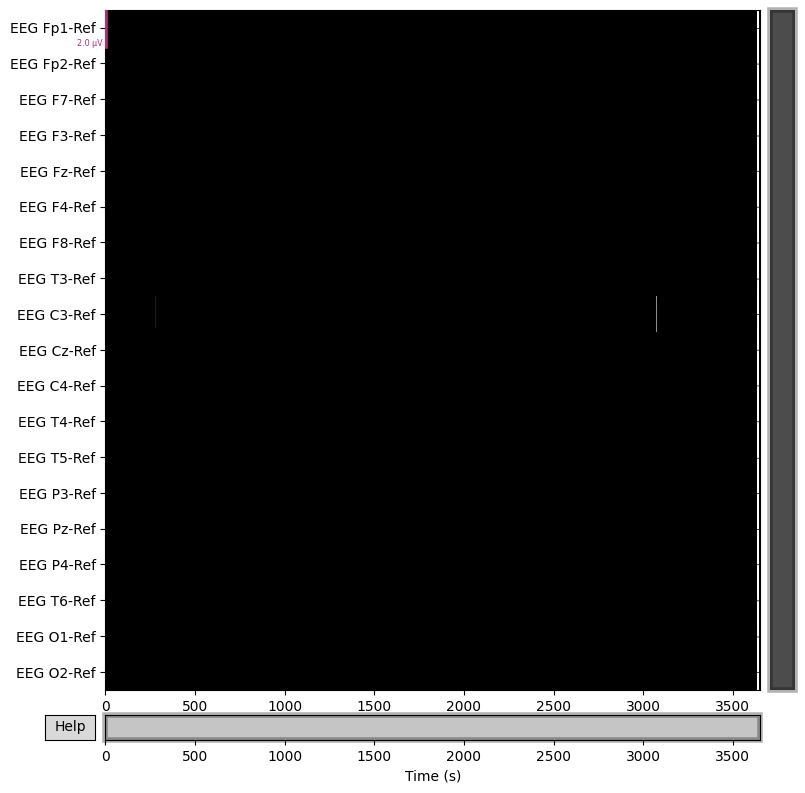

Index: 6
EEG:9


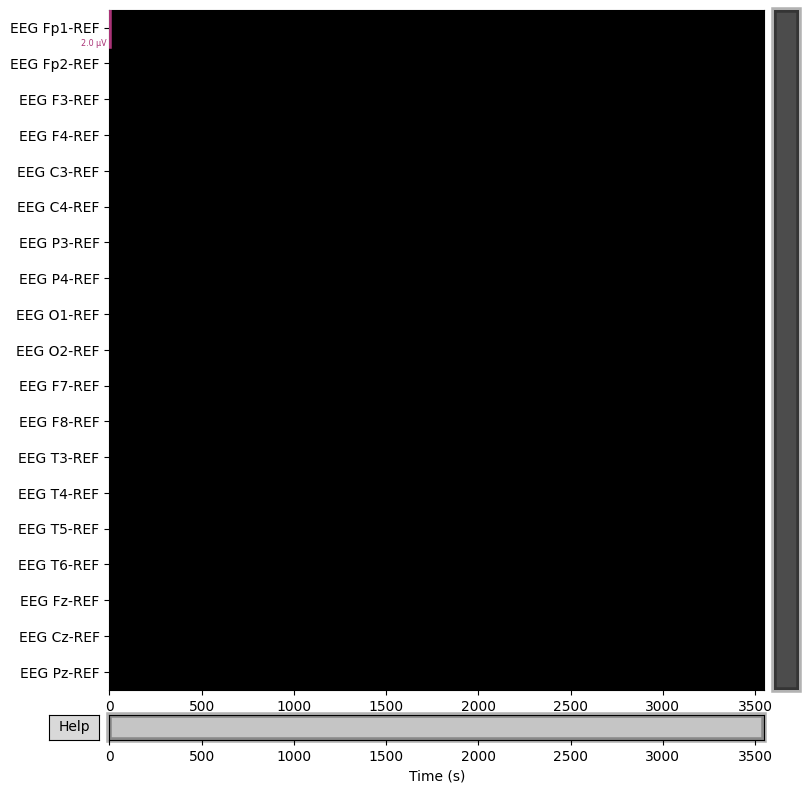

Index: 7
EEG:11


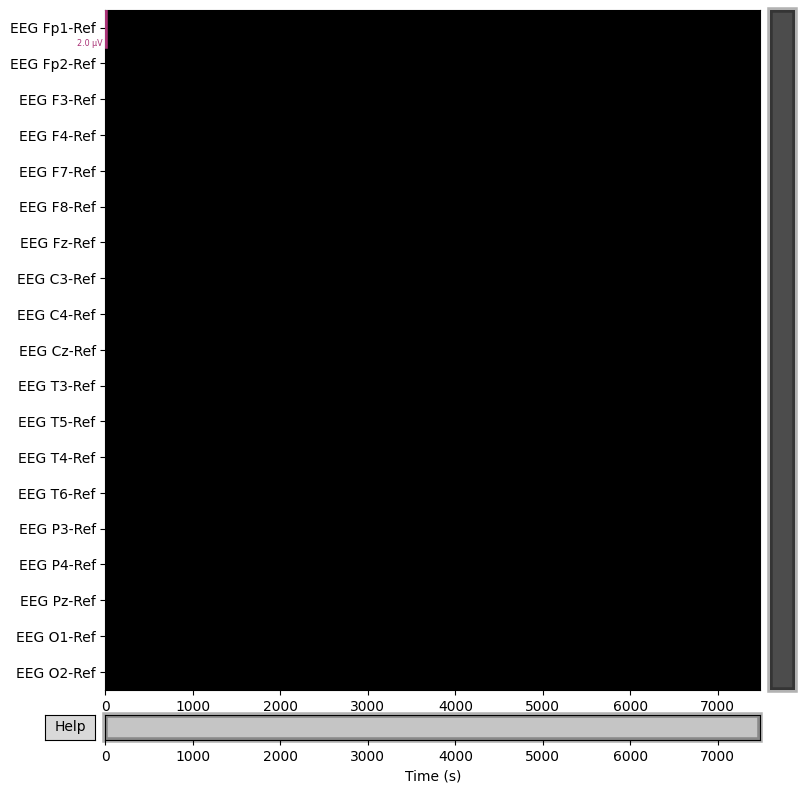

Index: 8
EEG:12


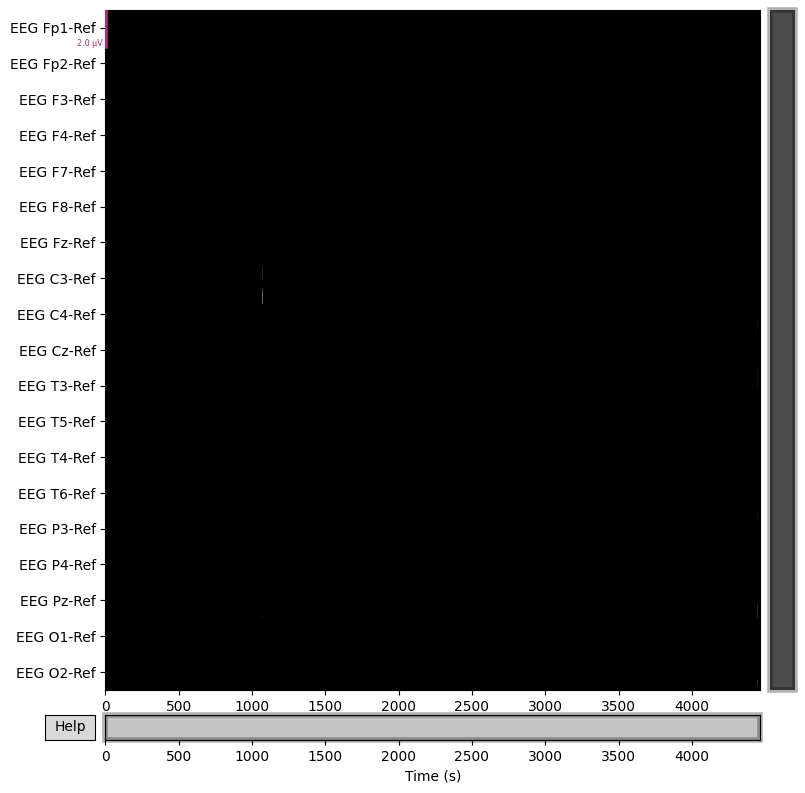

Index: 9
EEG:13


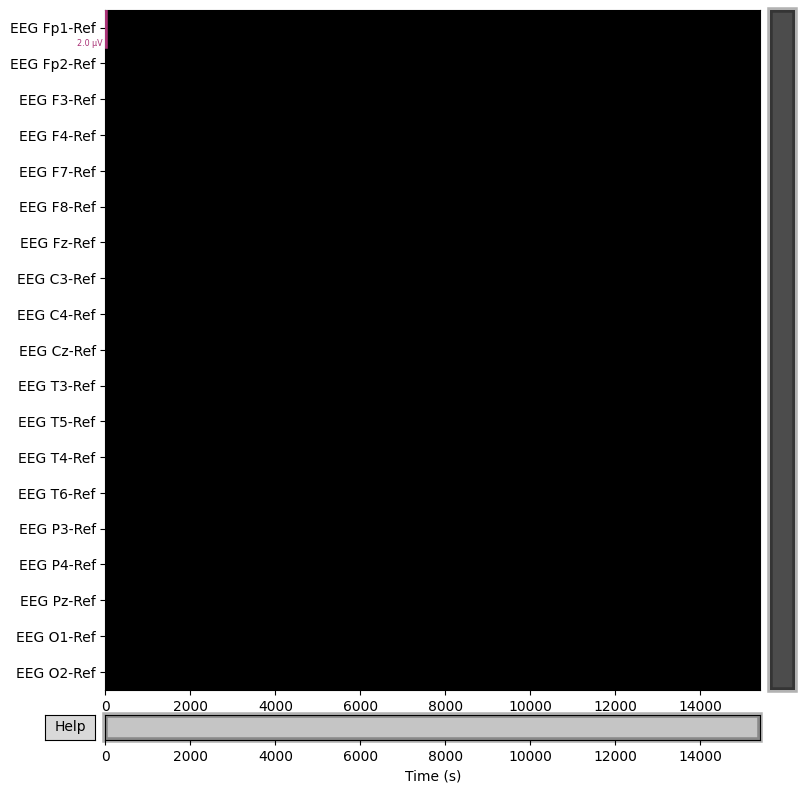

Index: 10
EEG:14


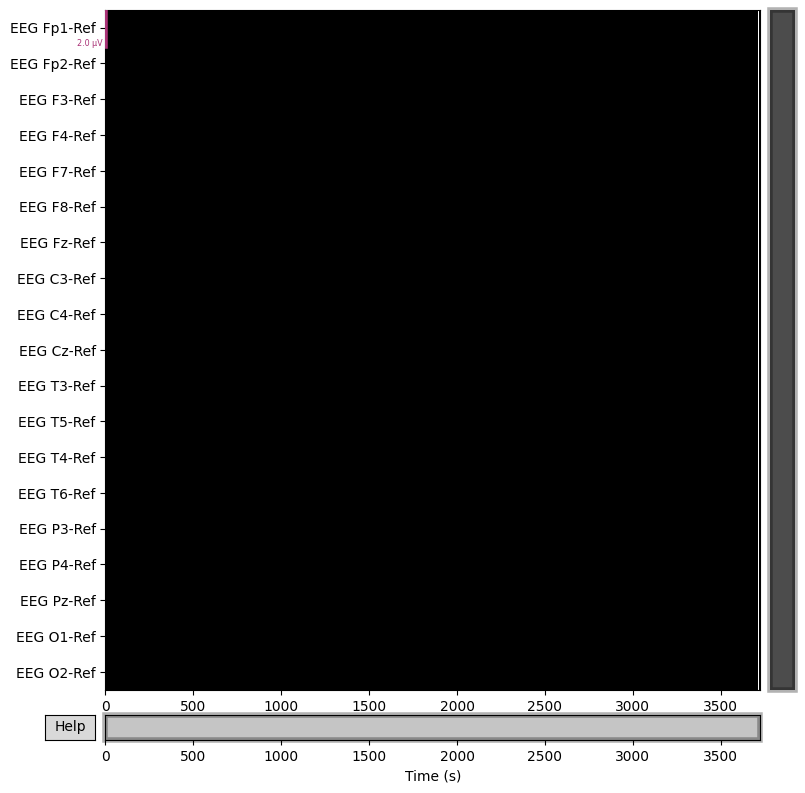

Index: 11
EEG:15


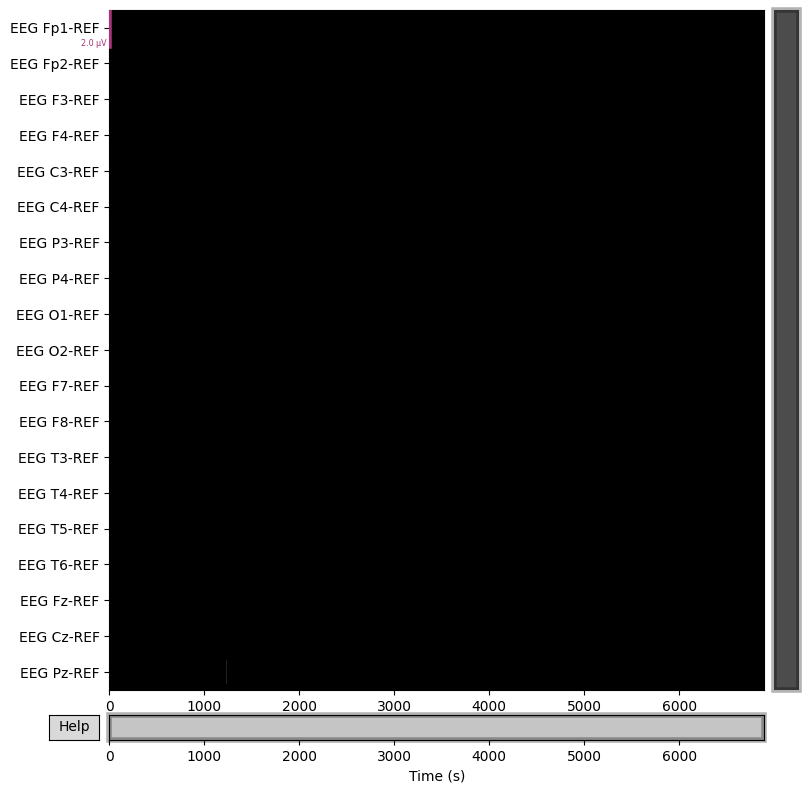

Index: 12
EEG:16


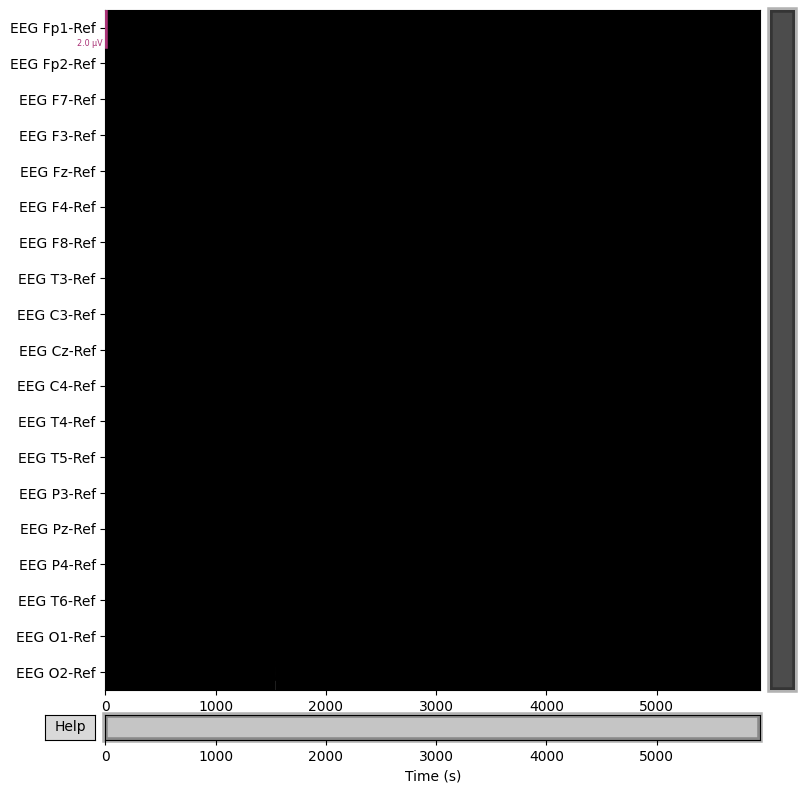

Index: 13
EEG:17


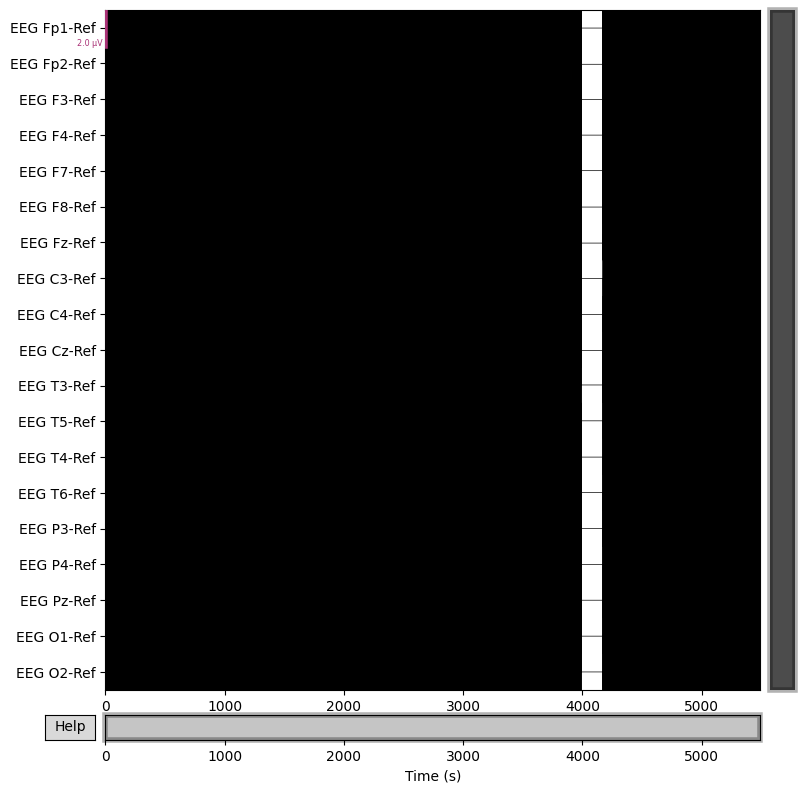

Index: 14
EEG:19


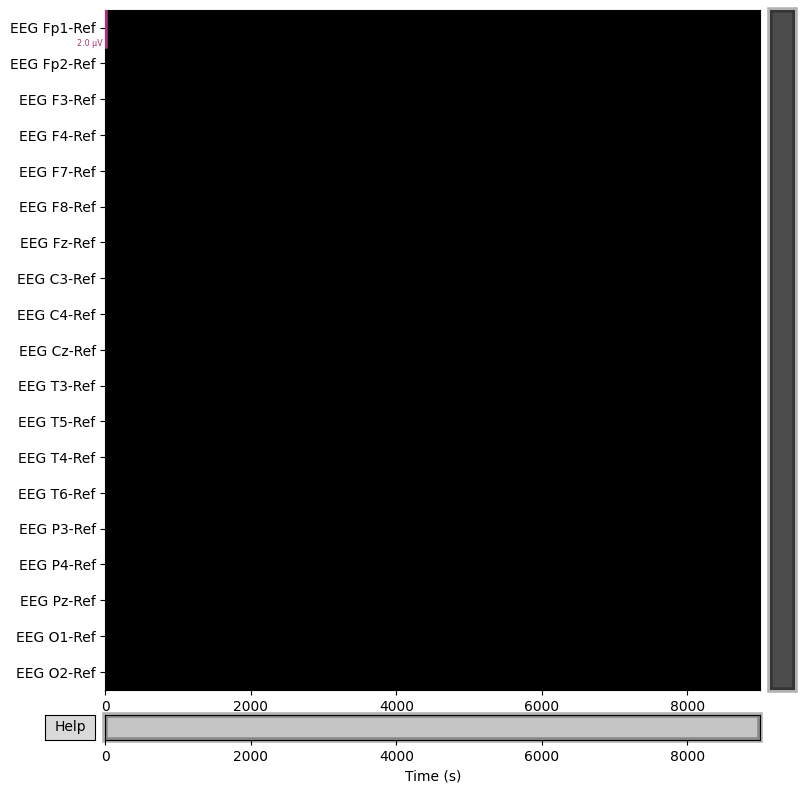

Index: 15
EEG:20


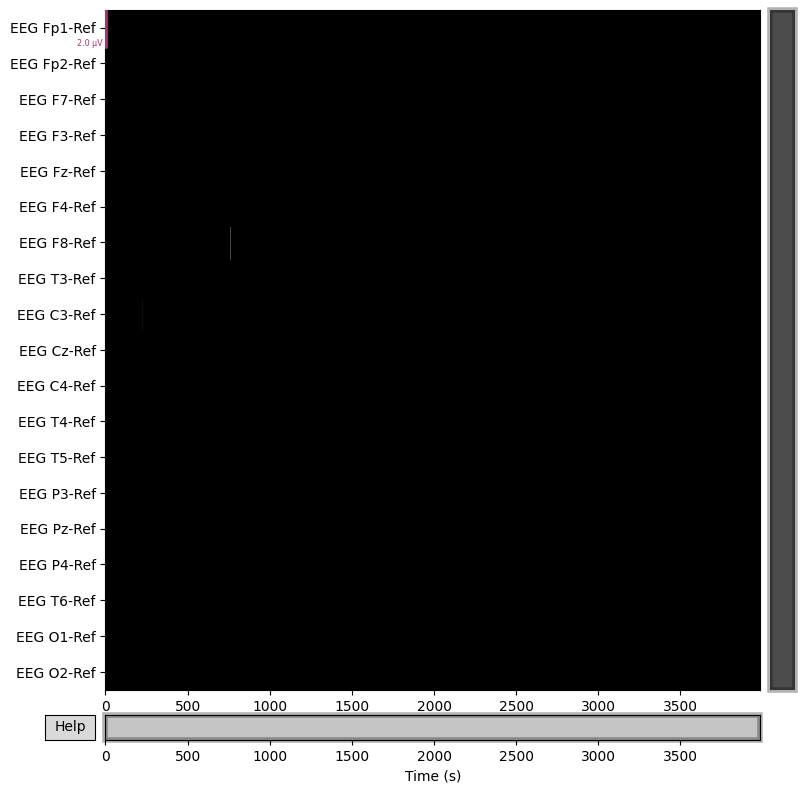

Index: 16
EEG:21


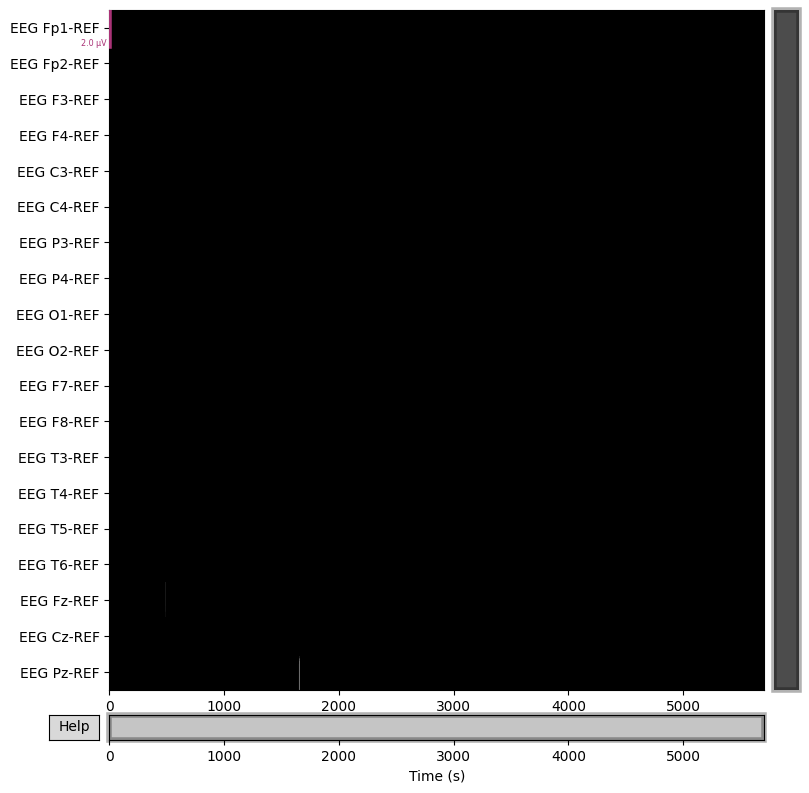

Index: 17
EEG:22


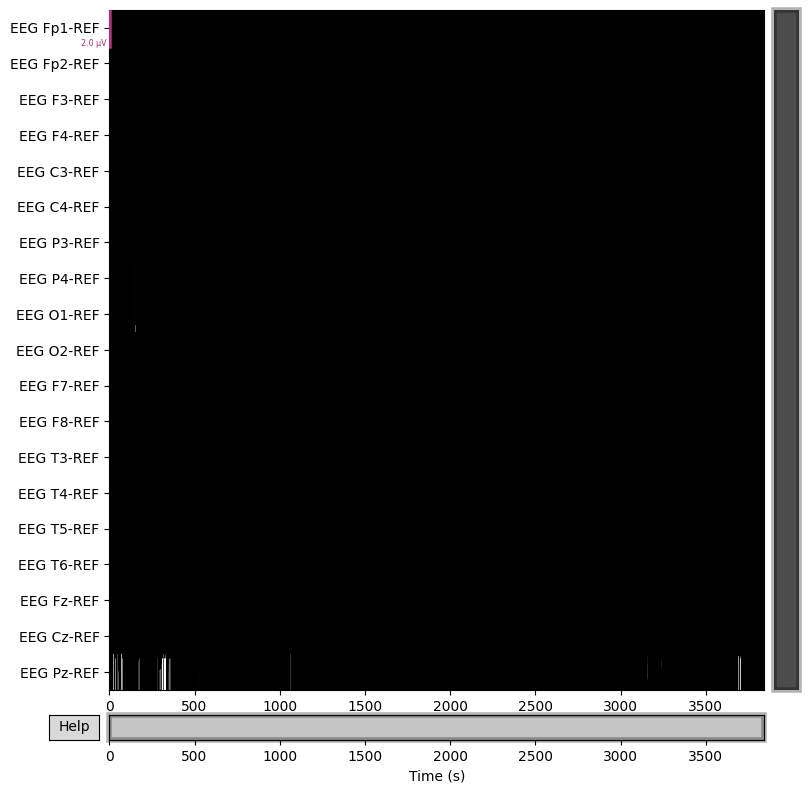

Index: 18
EEG:24


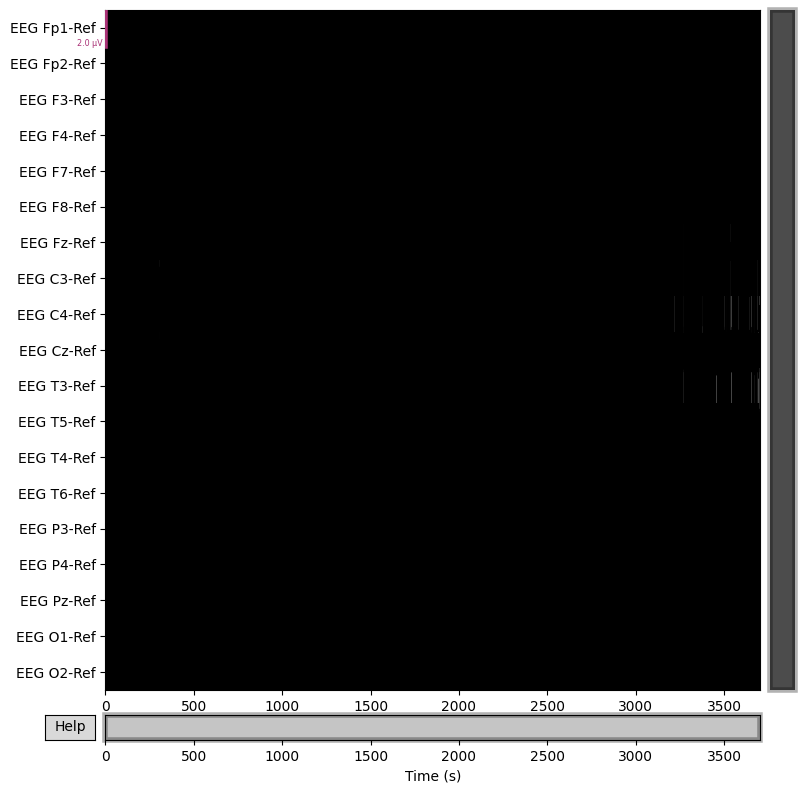

Index: 19
EEG:25


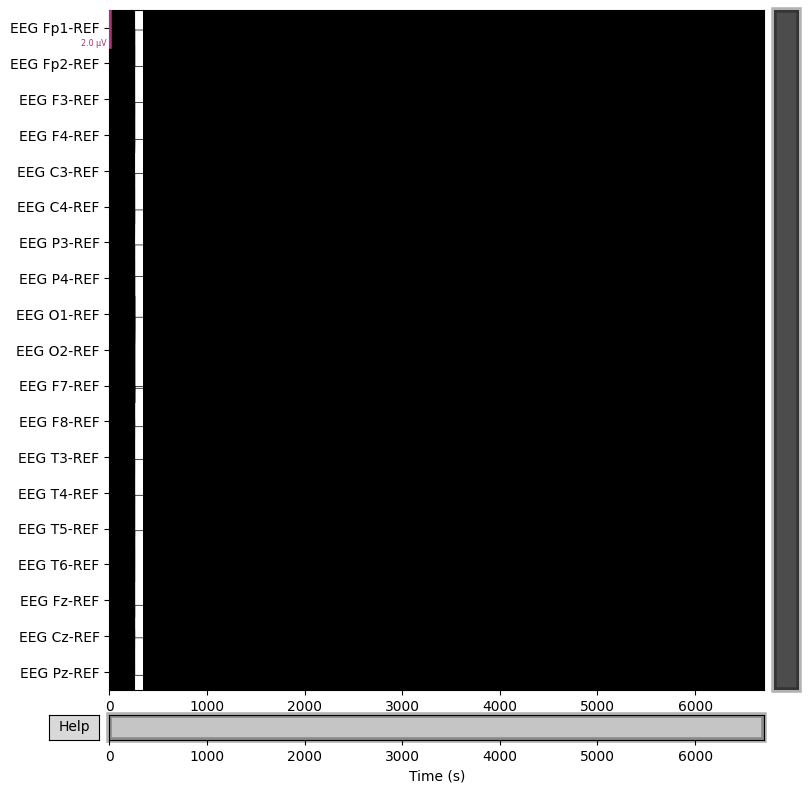

Index: 20
EEG:26


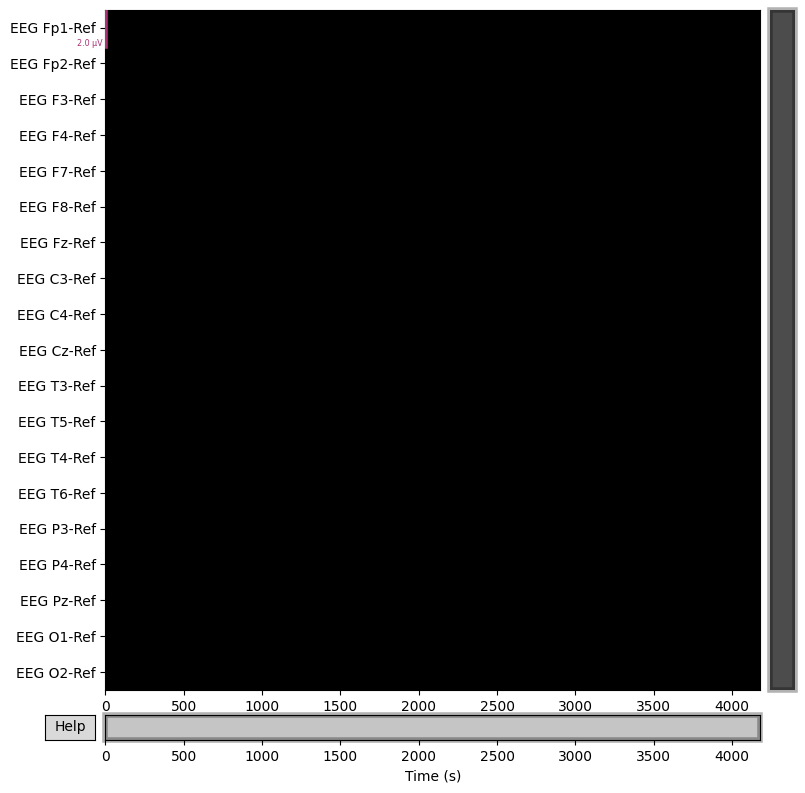

Index: 21
EEG:31


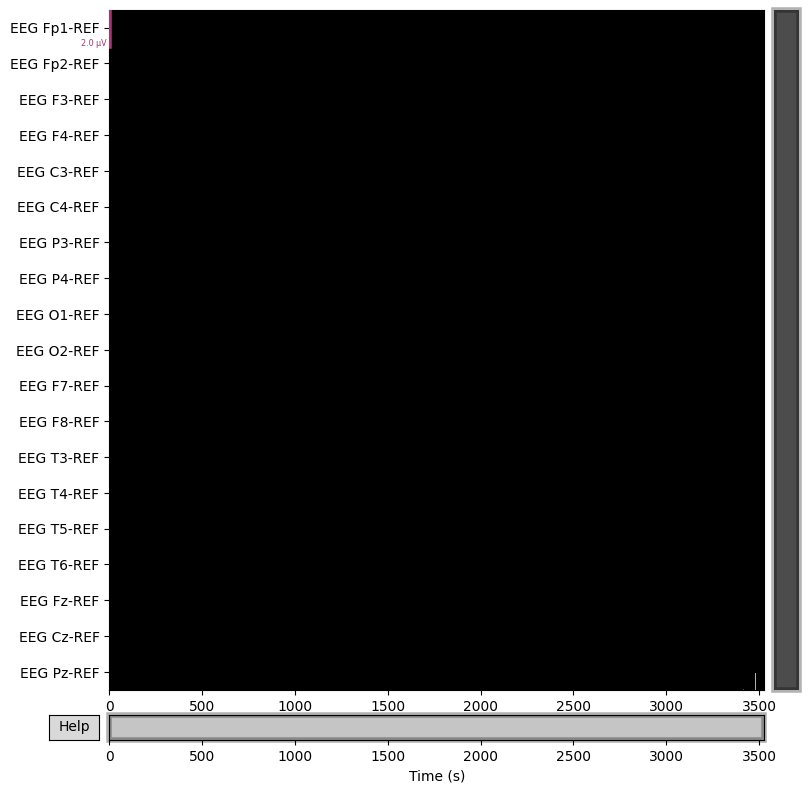

Index: 22
EEG:34


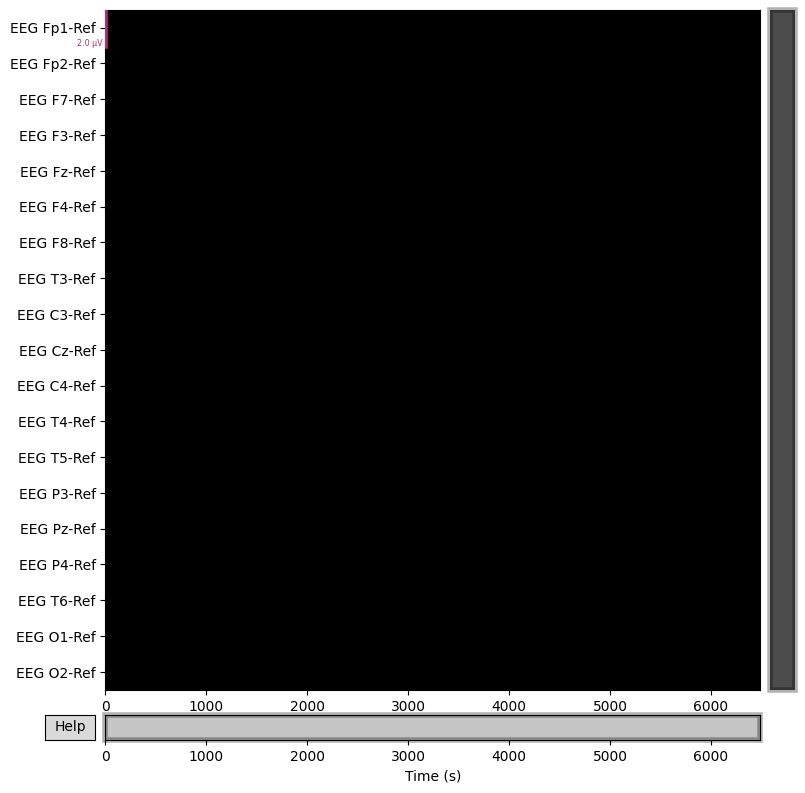

Index: 23
EEG:36


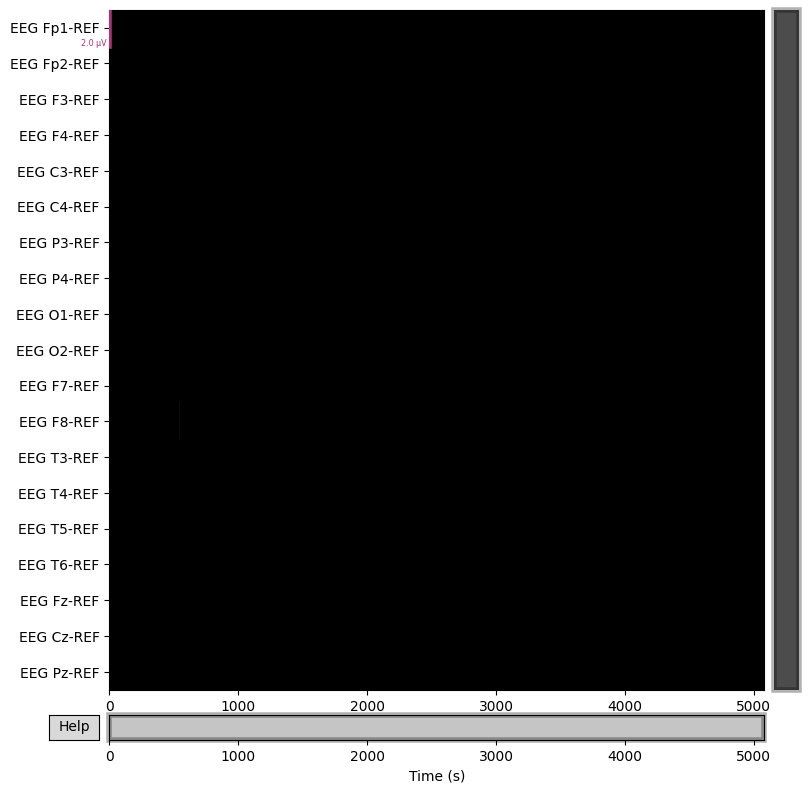

Index: 24
EEG:38


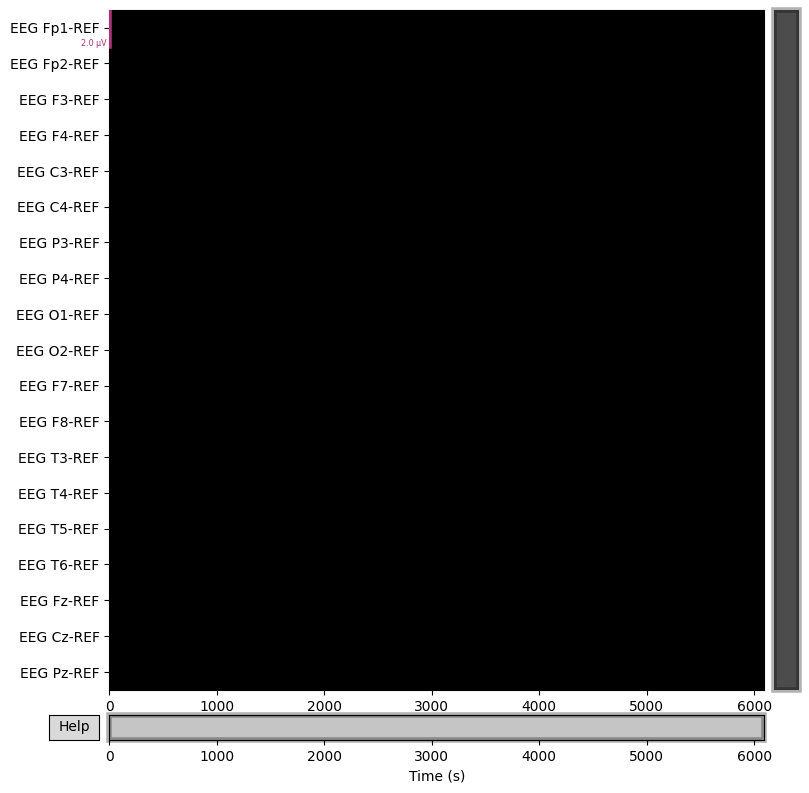

Index: 25
EEG:39


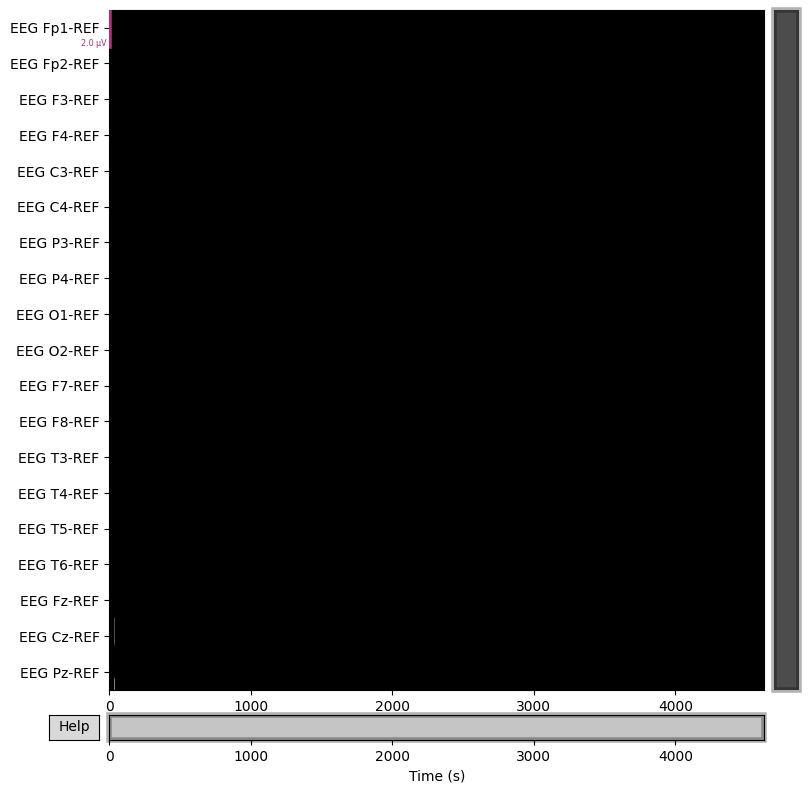

Index: 26
EEG:40


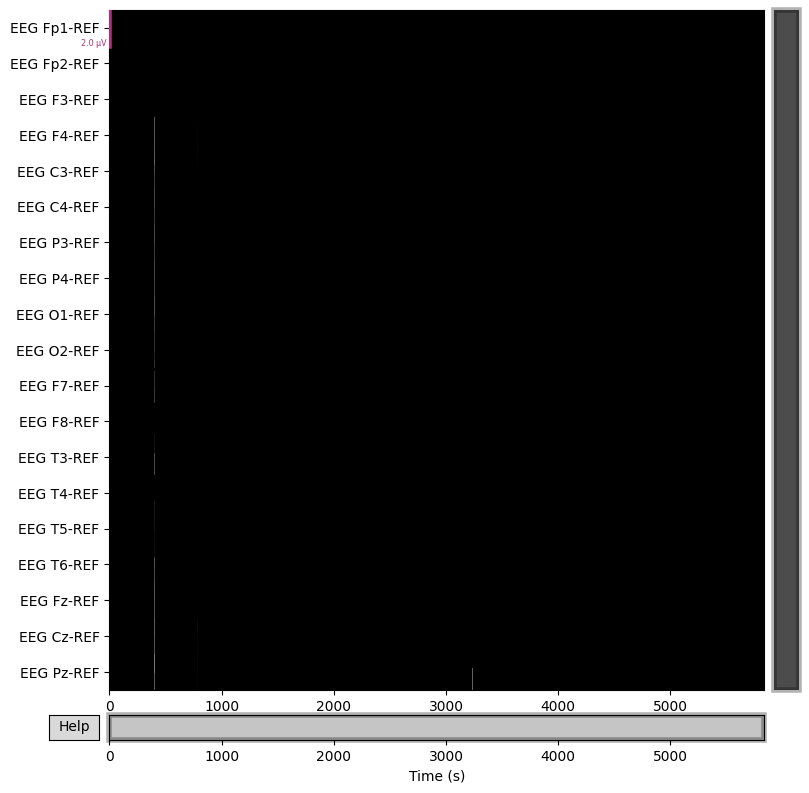

Index: 27
EEG:41


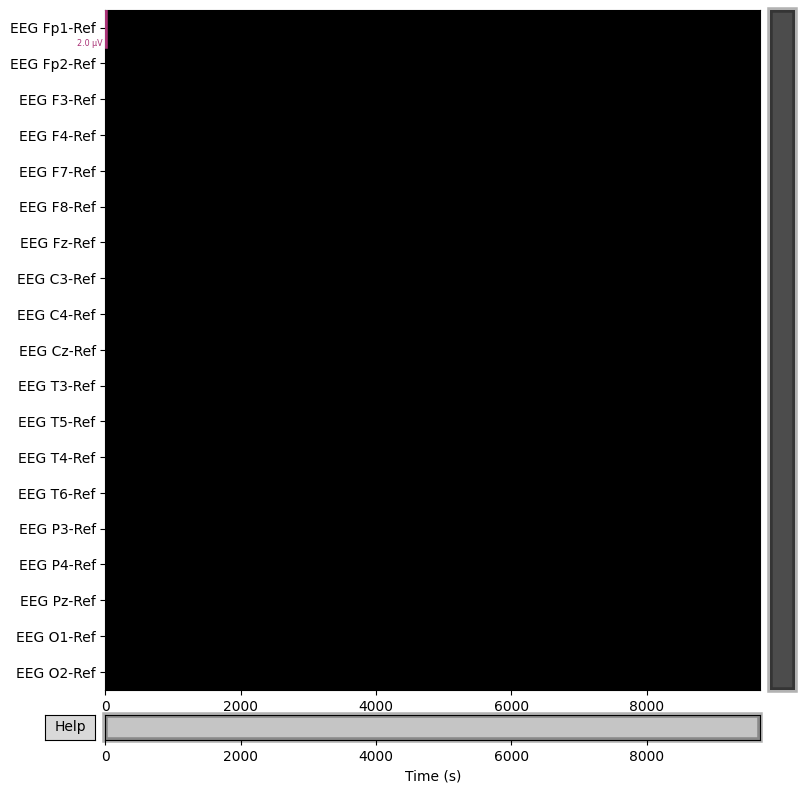

Index: 28
EEG:43


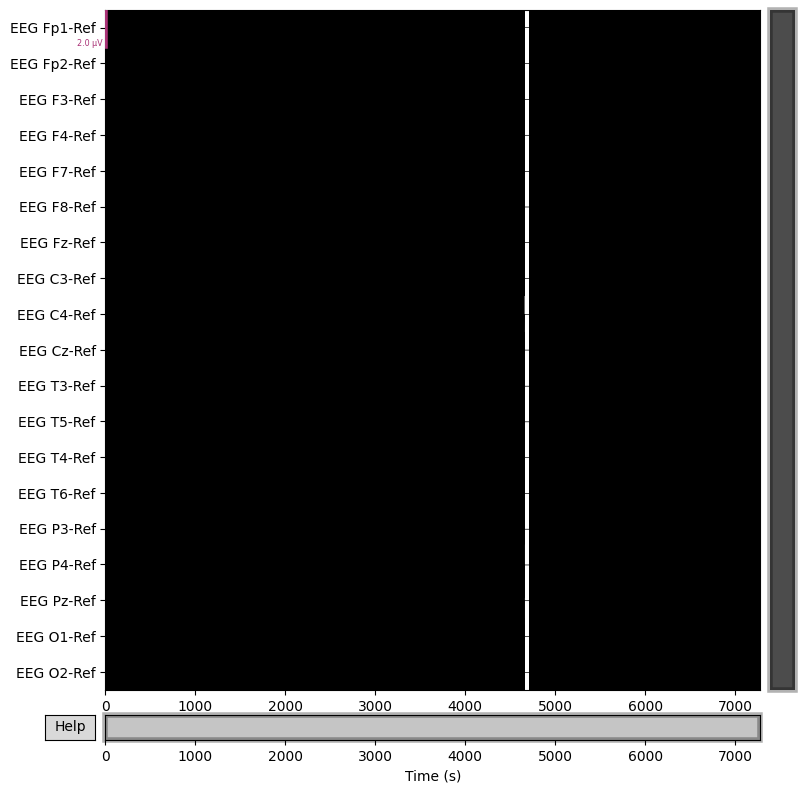

Index: 29
EEG:44


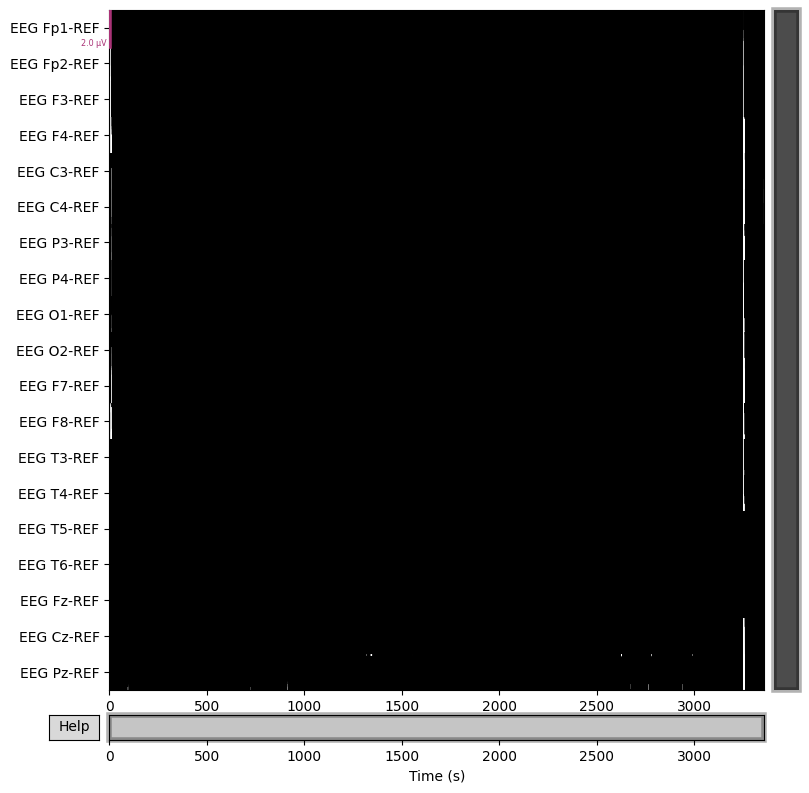

Index: 30
EEG:46


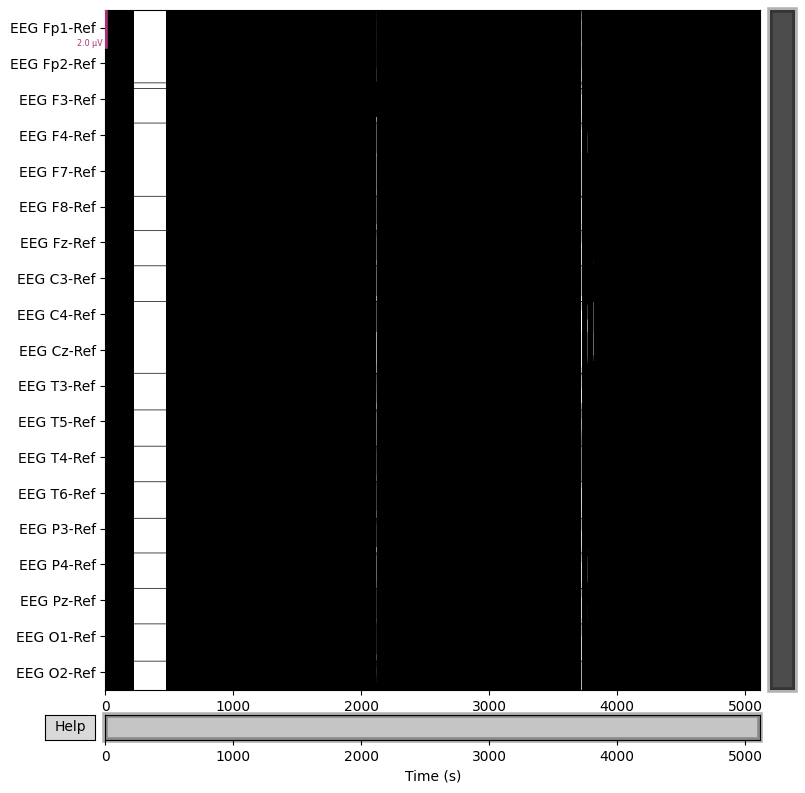

Index: 31
EEG:47


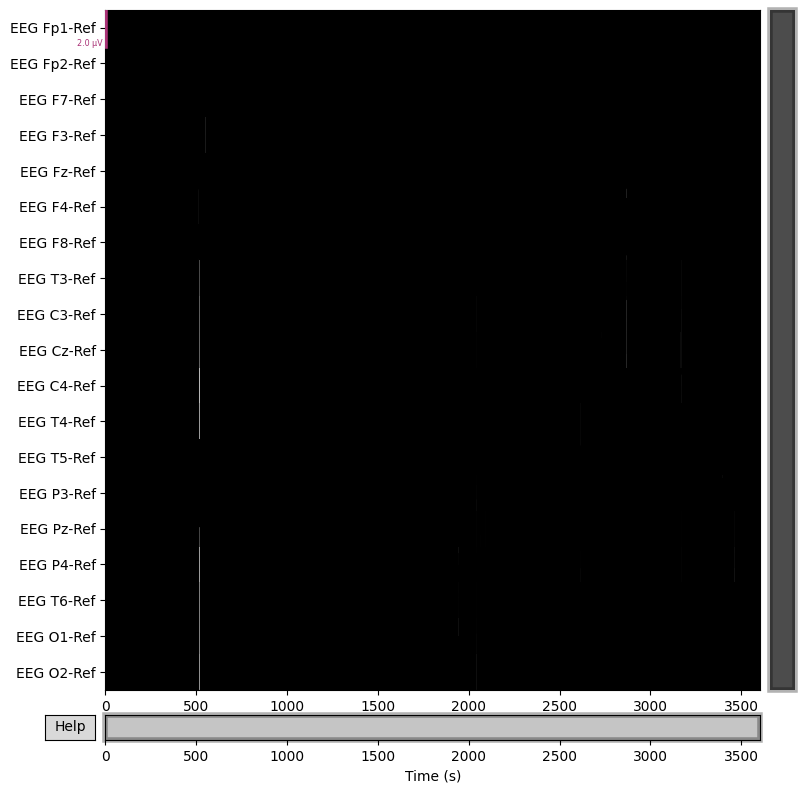

Index: 32
EEG:50


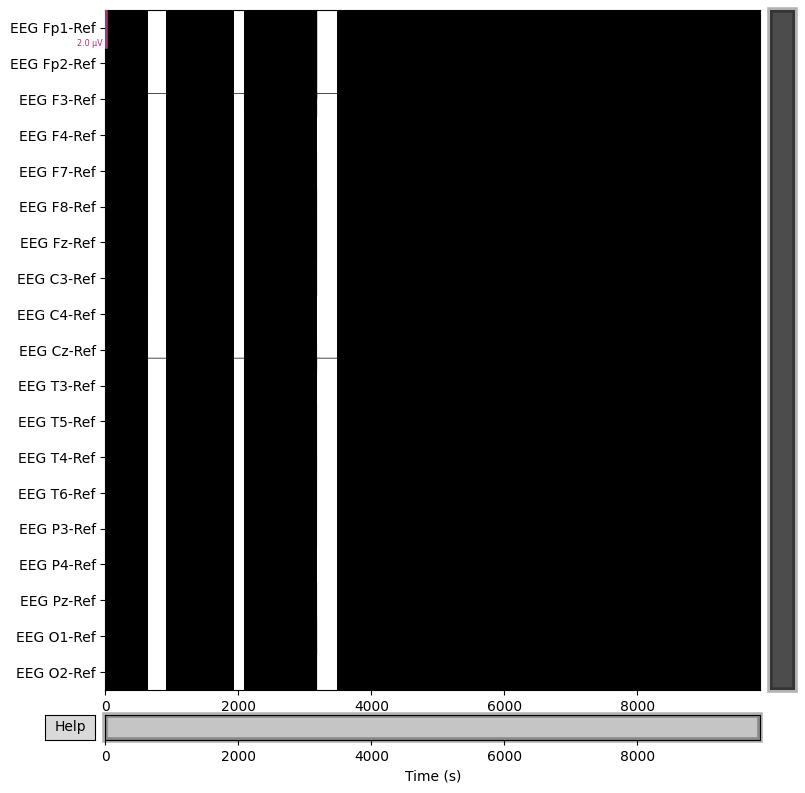

Index: 33
EEG:51


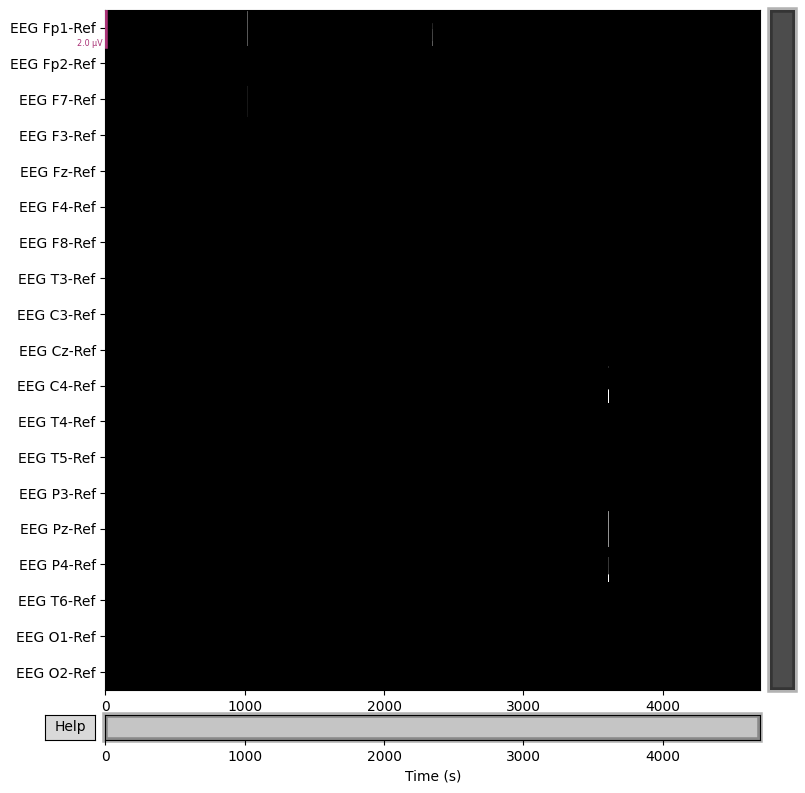

Index: 34
EEG:52


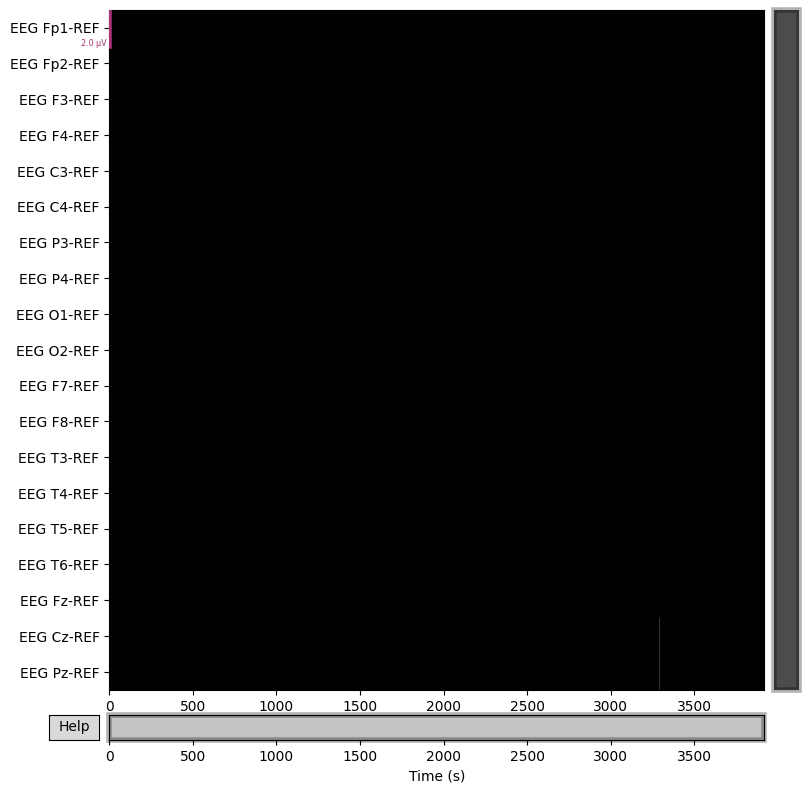

Index: 35
EEG:56


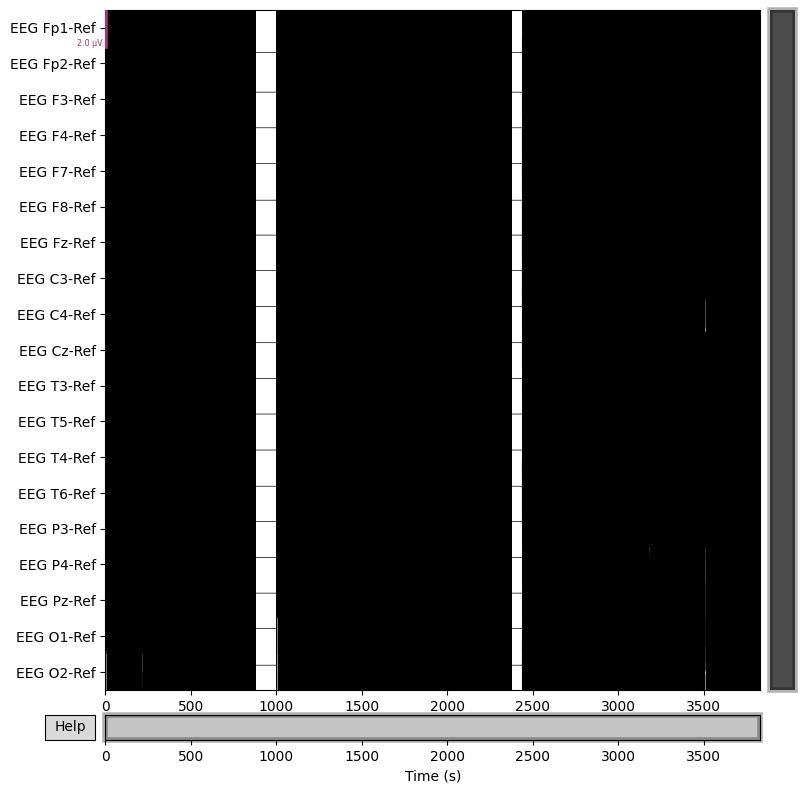

Index: 36
EEG:62


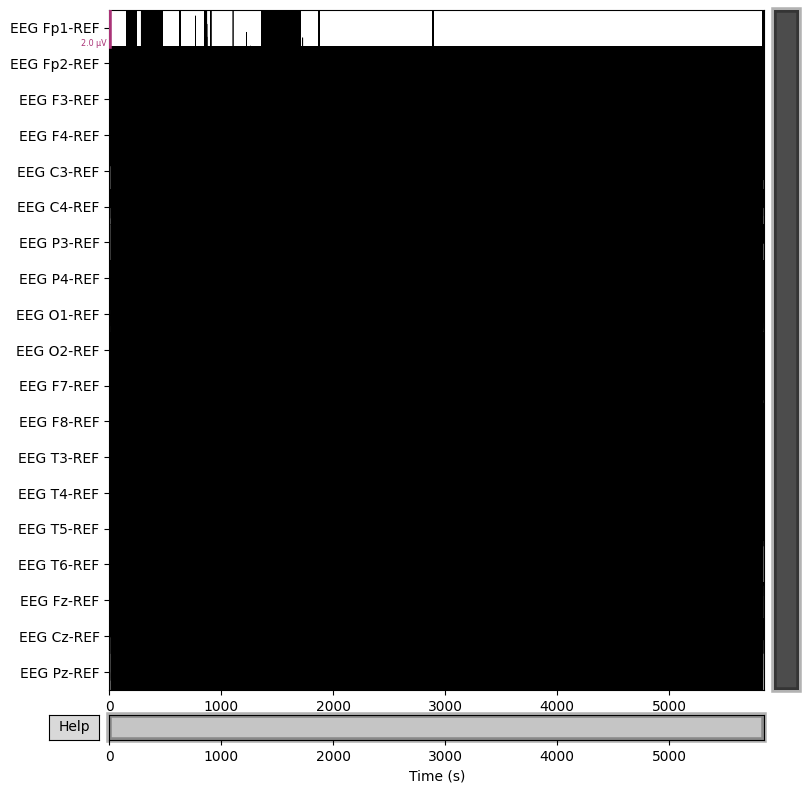

Index: 37
EEG:63


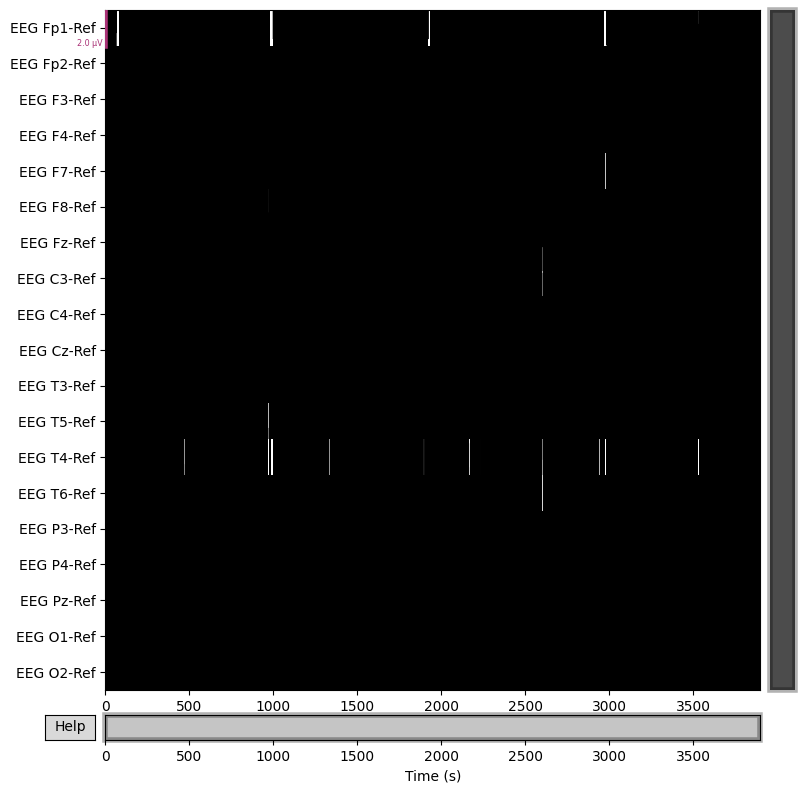

Index: 38
EEG:65


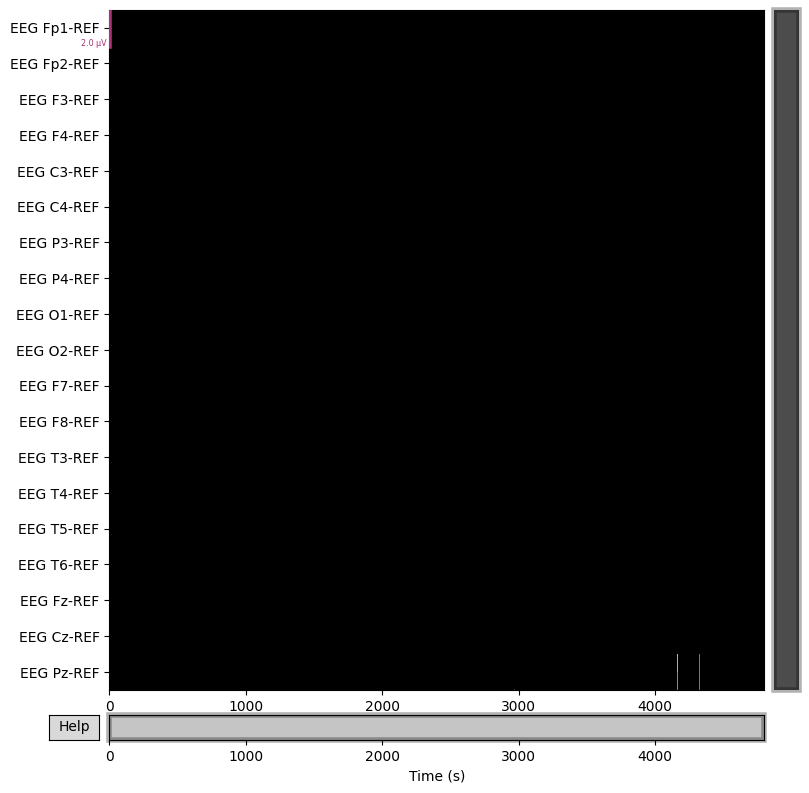

Index: 39
EEG:66


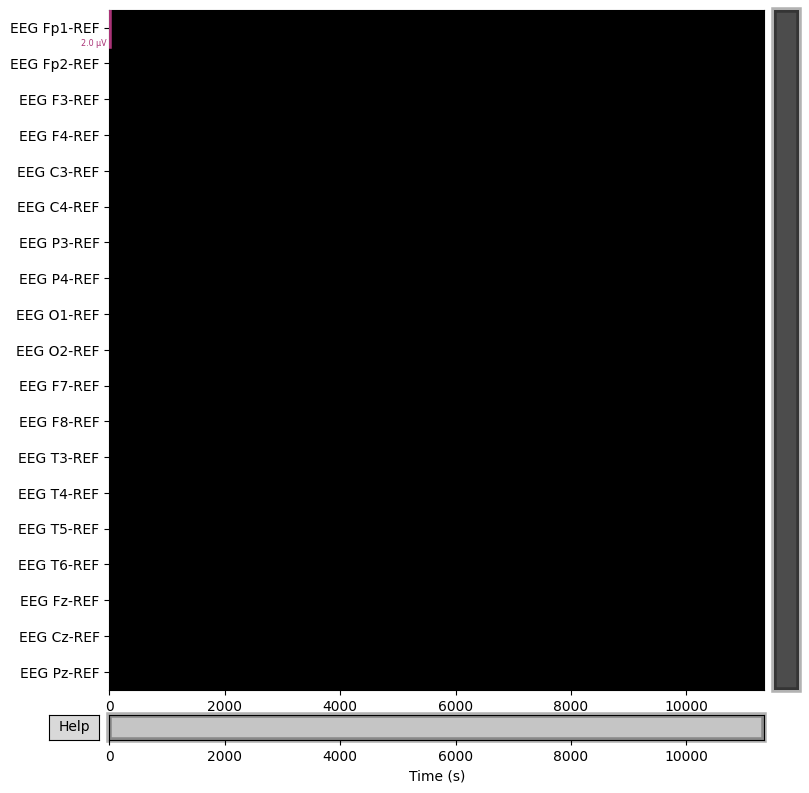

Index: 40
EEG:67


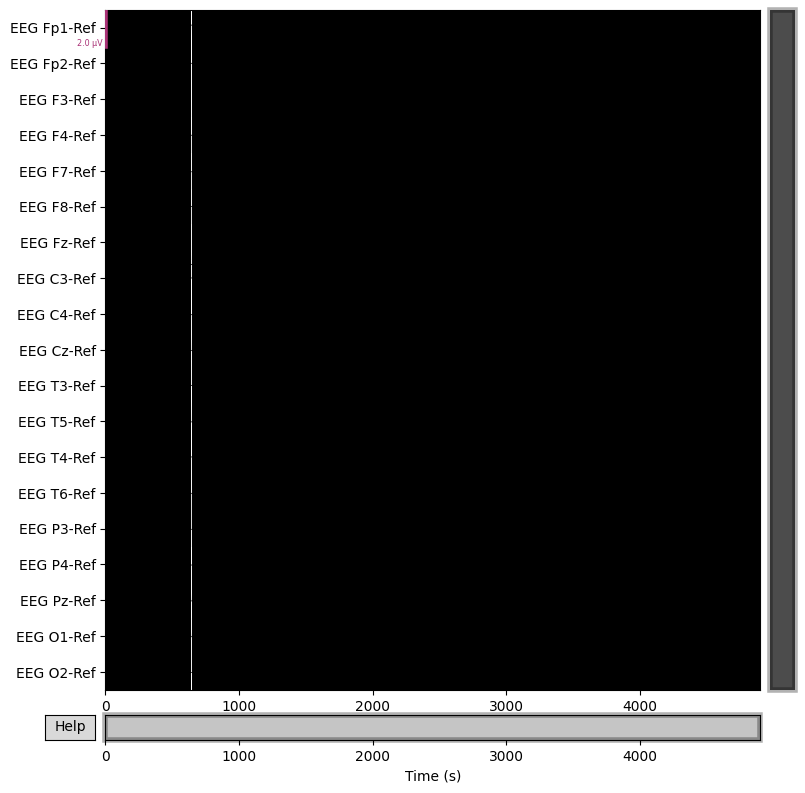

Index: 41
EEG:69


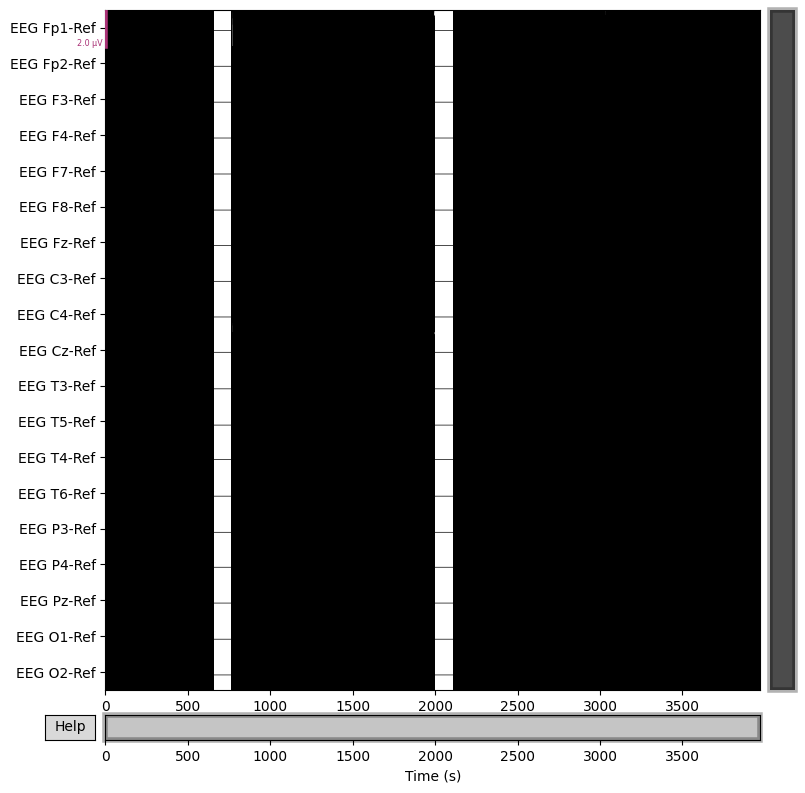

Index: 42
EEG:71


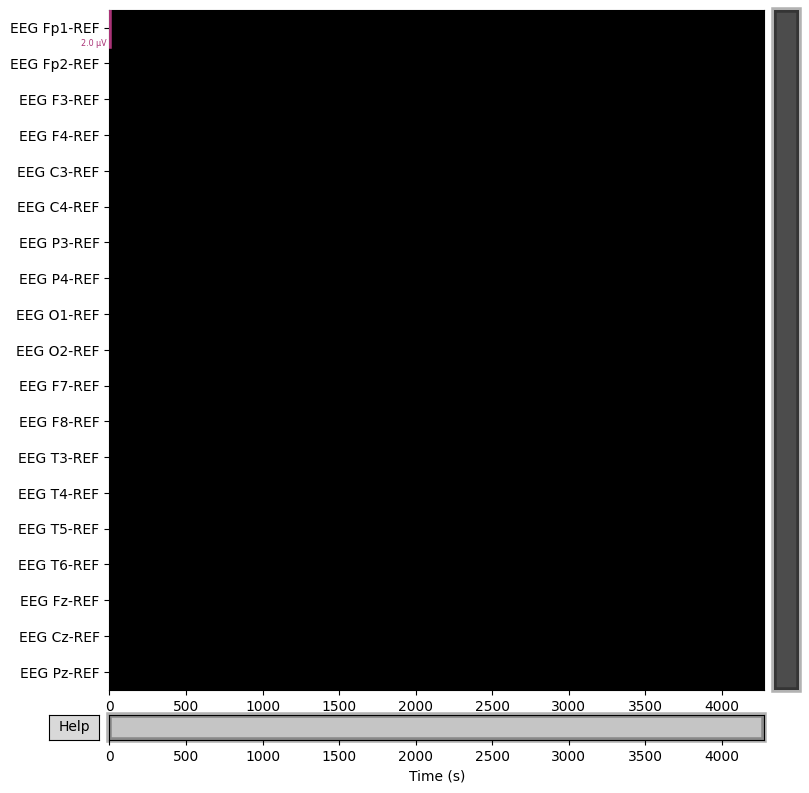

Index: 43
EEG:73


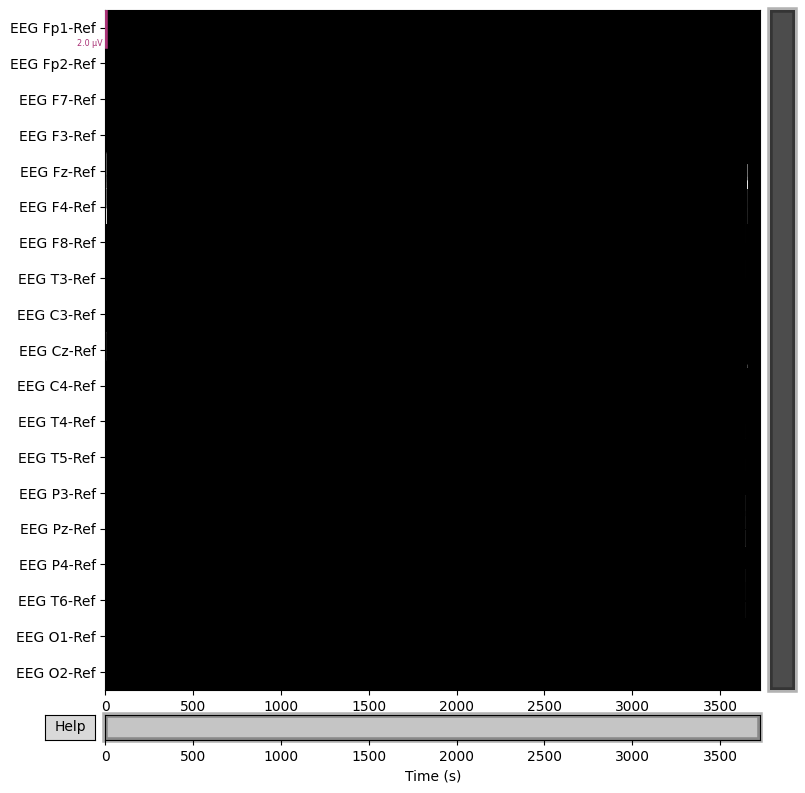

Index: 44
EEG:75


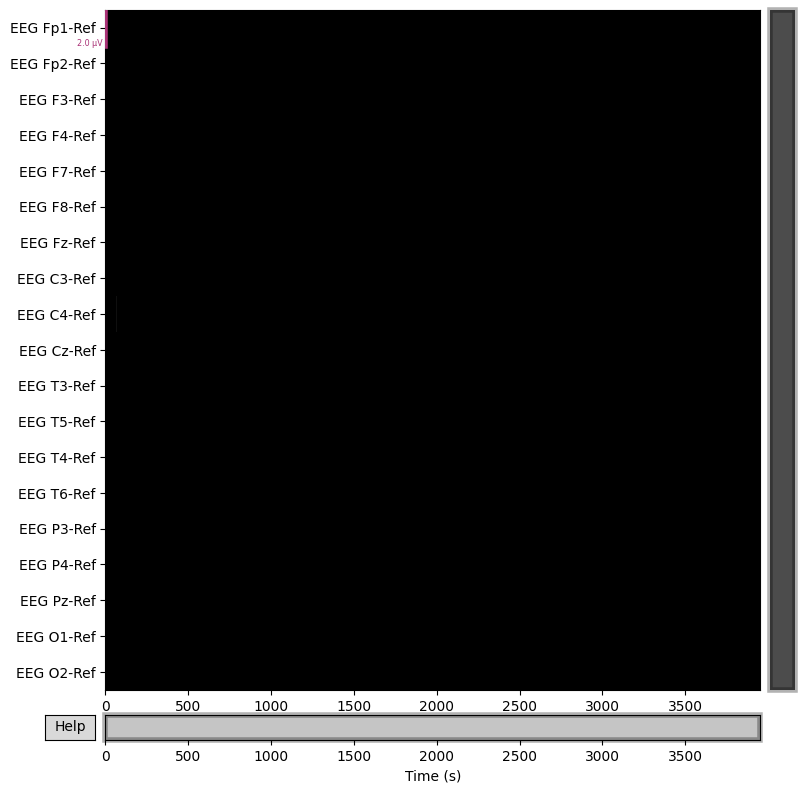

Index: 45
EEG:76


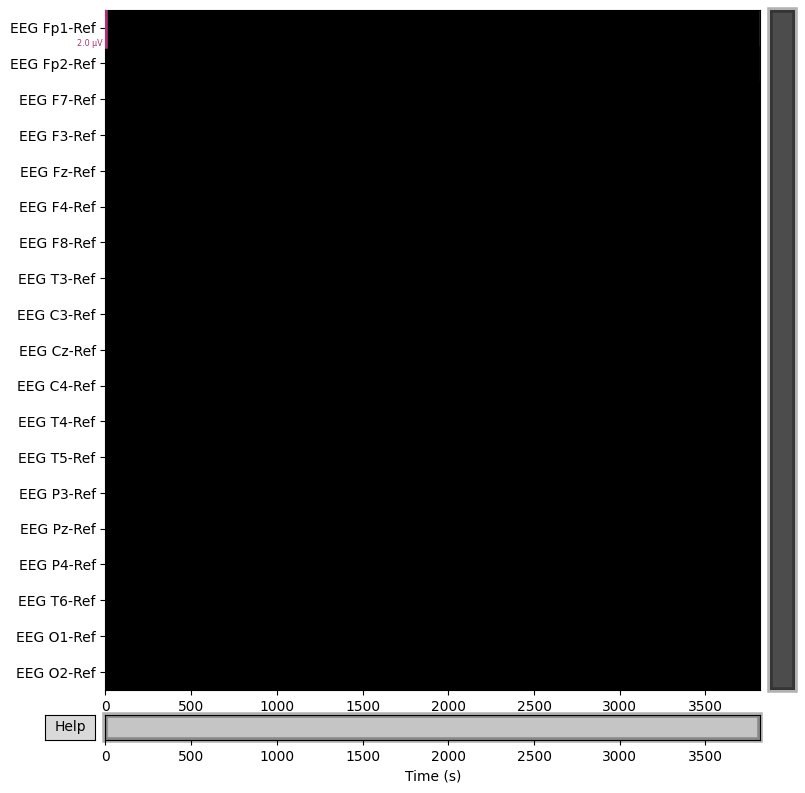

Index: 46
EEG:77


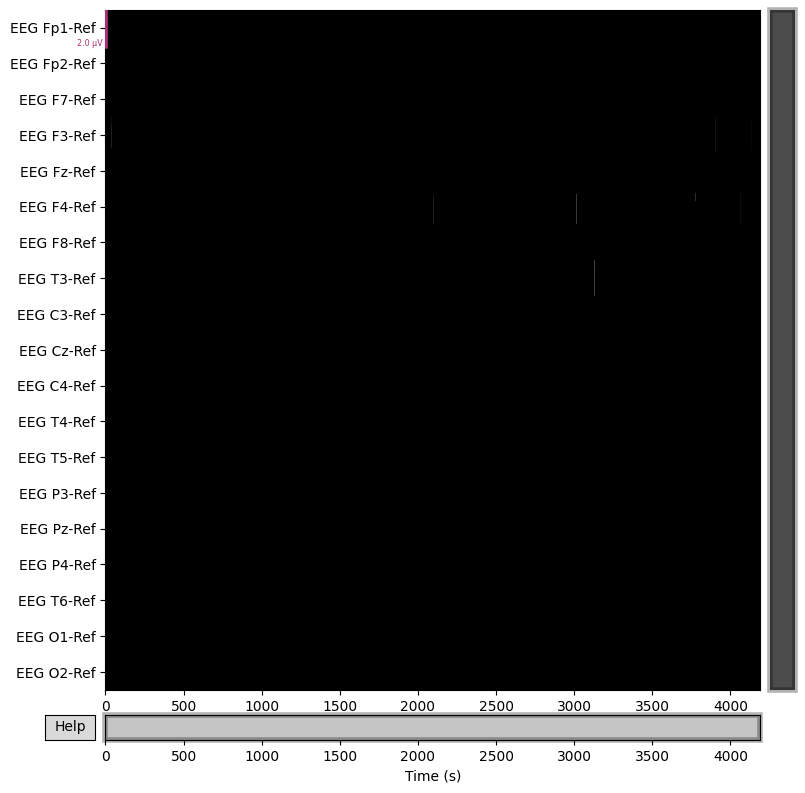

Index: 47
EEG:78


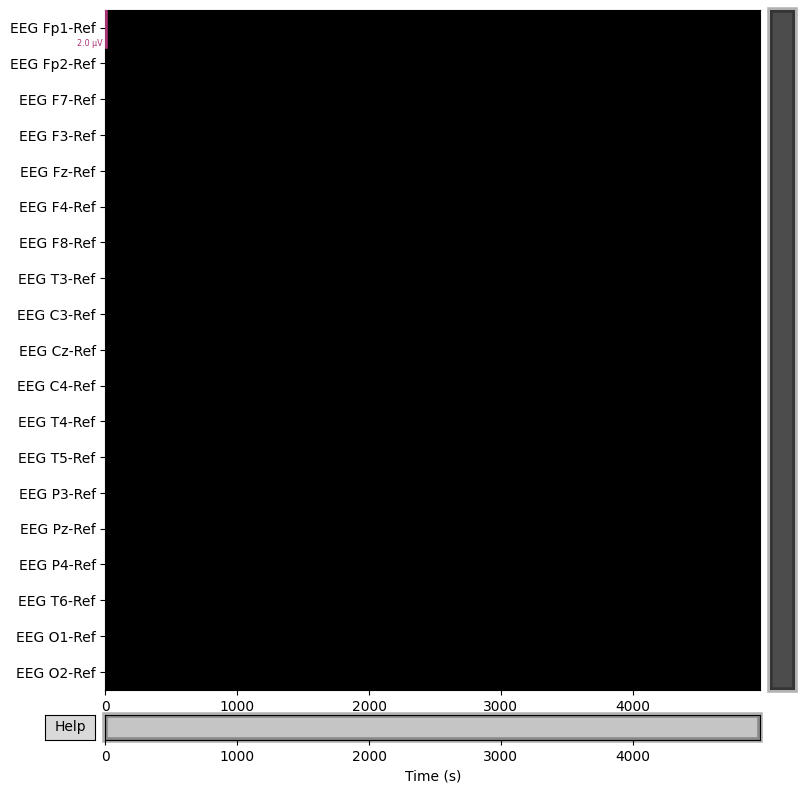

Index: 48
EEG:79


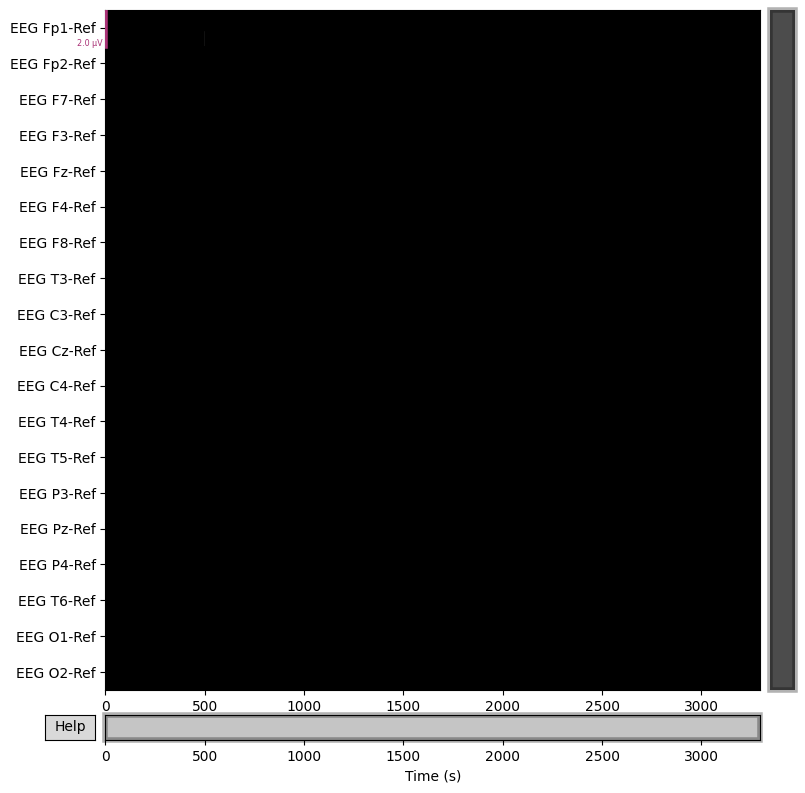

In [17]:
start_index = 5
for i in annot_eeg_indices[start_index:]:
    print("Index:", start_index)
    print('EEG:'+i)
    end_time = max(eeg_dict['eeg'+i].times)
    eeg_dict['eeg'+i].plot(duration=end_time, scalings=10**(-6))
    start_index = start_index + 1

Index: 0
EEG:1


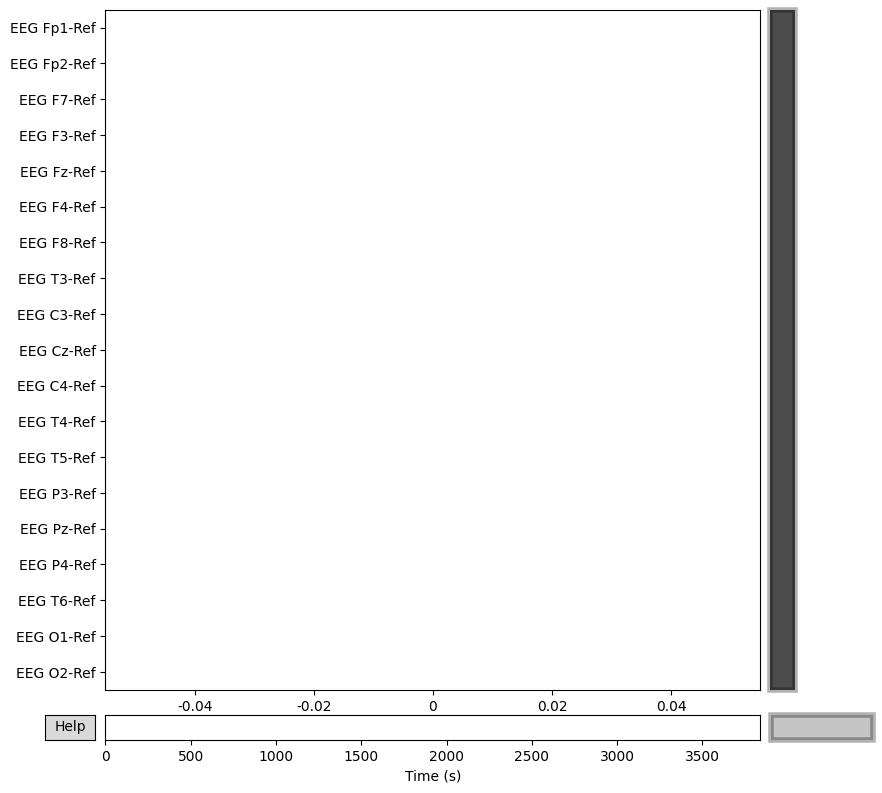

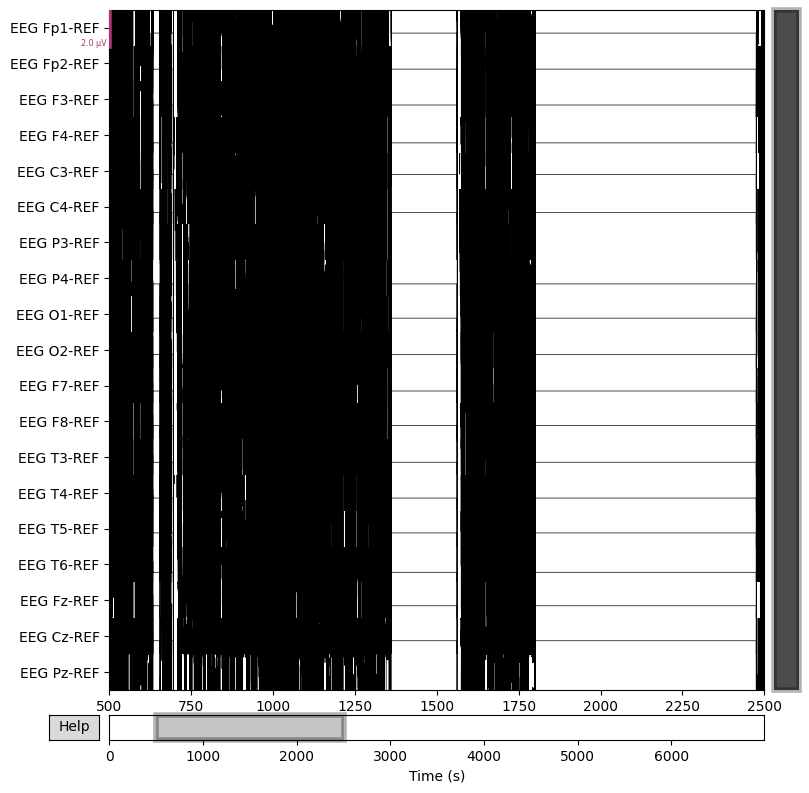

Index: 5
EEG:7


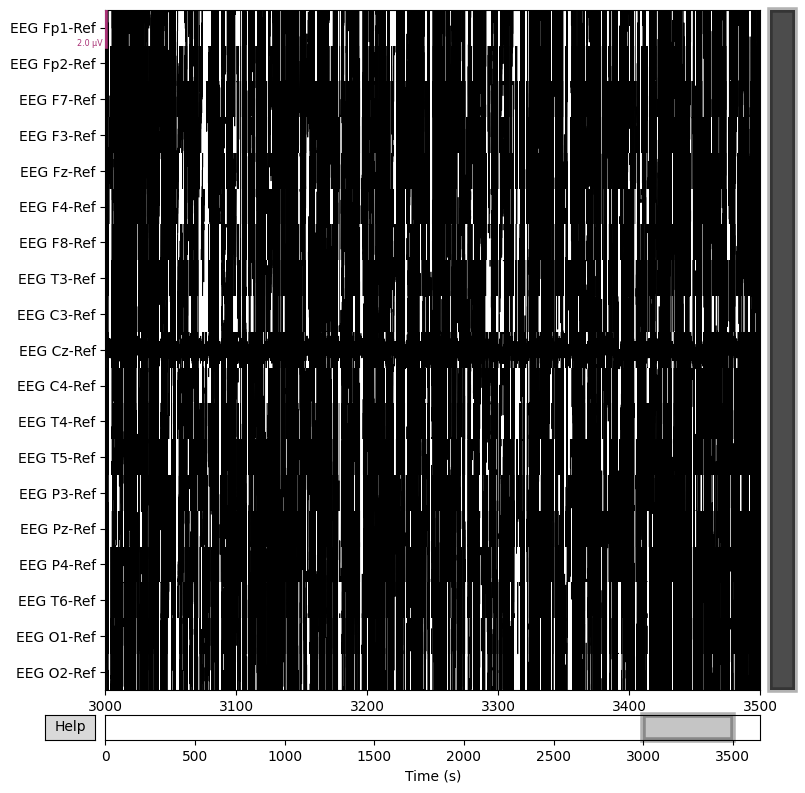

Index: 8
EEG:12


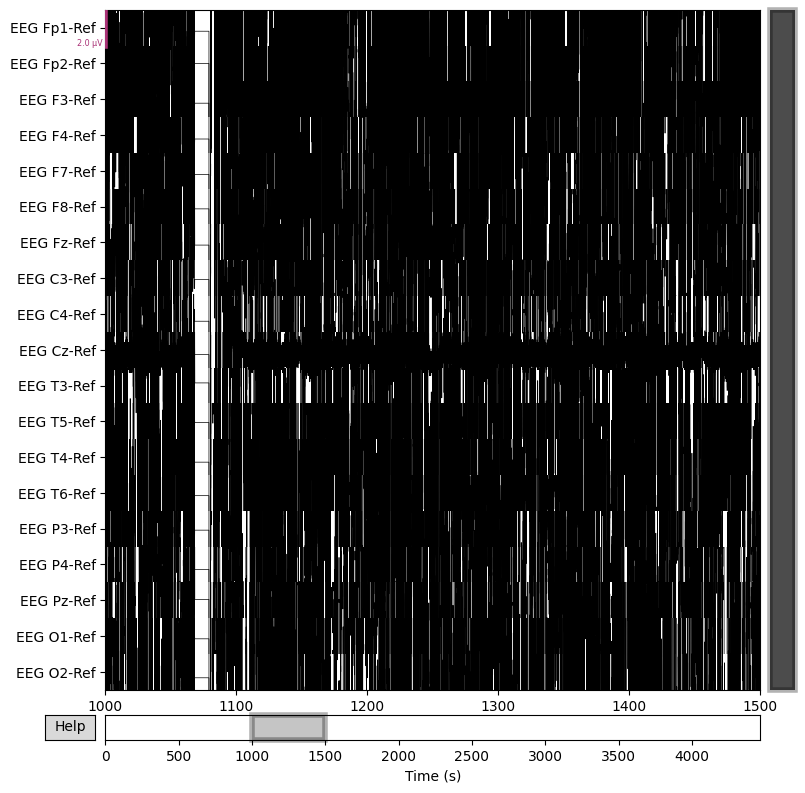

Index: 13
EEG:17


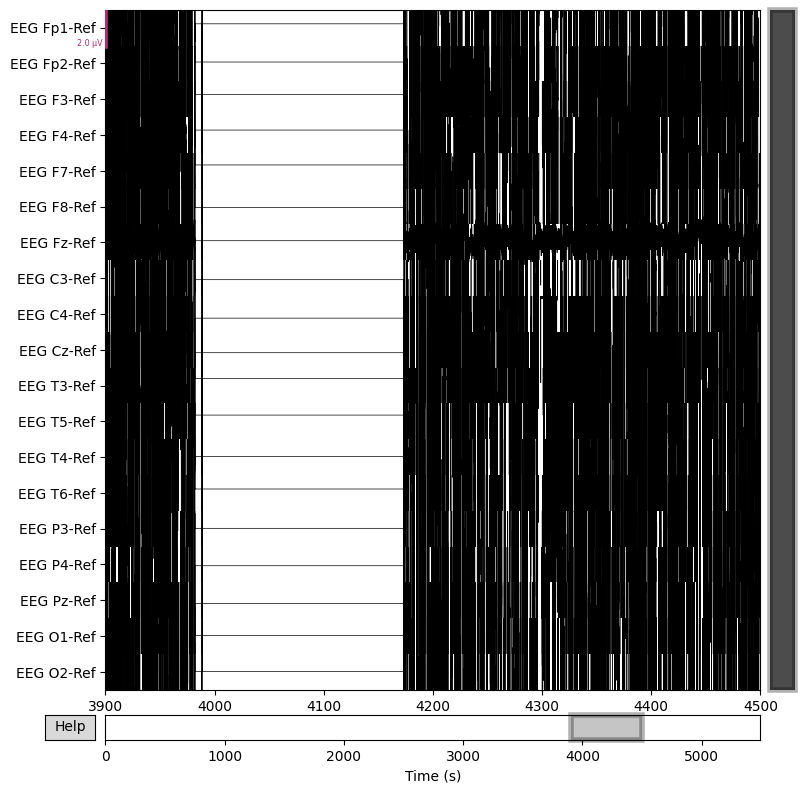

Index: 15
EEG:20


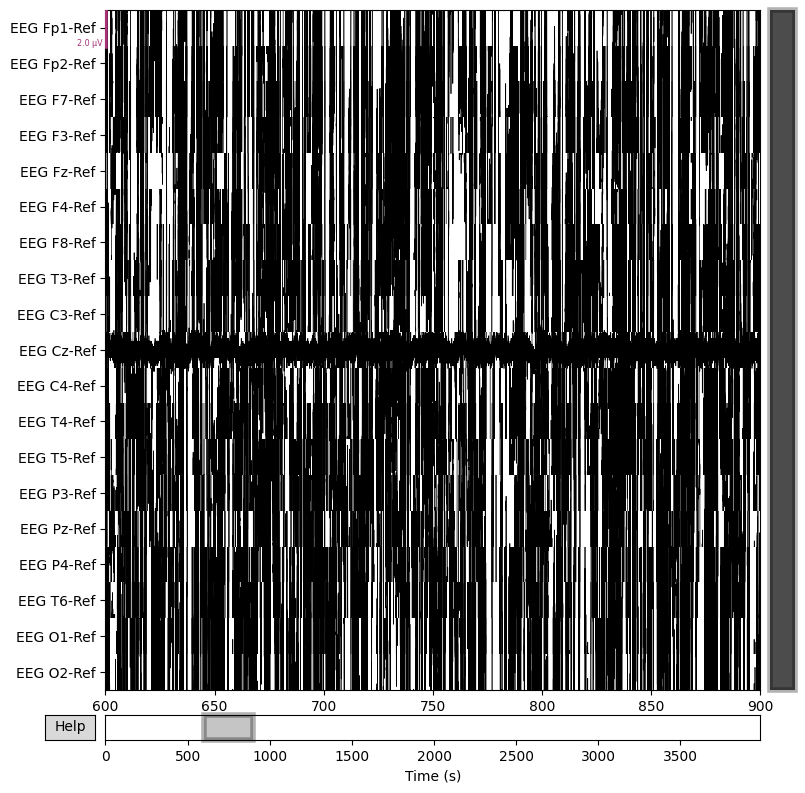

Index: 16
EEG:21


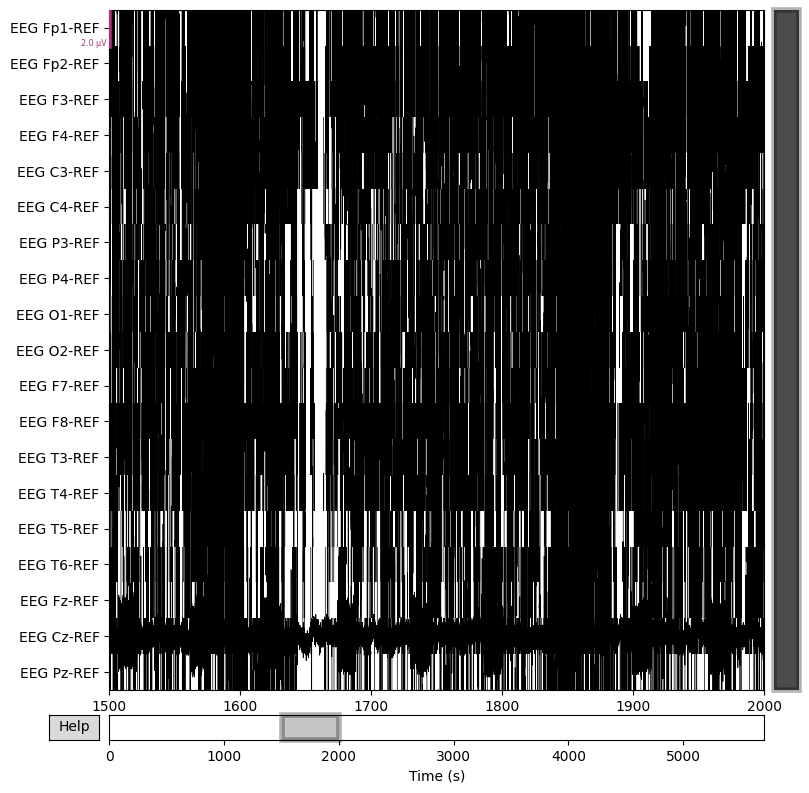

Index: 17
EEG:22


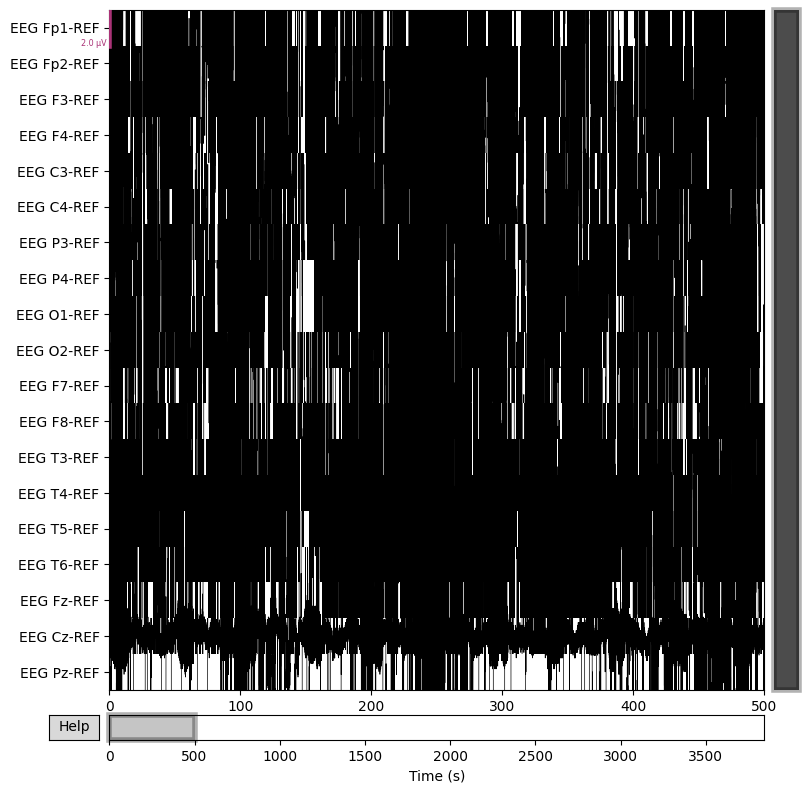

Index: 17
EEG:22


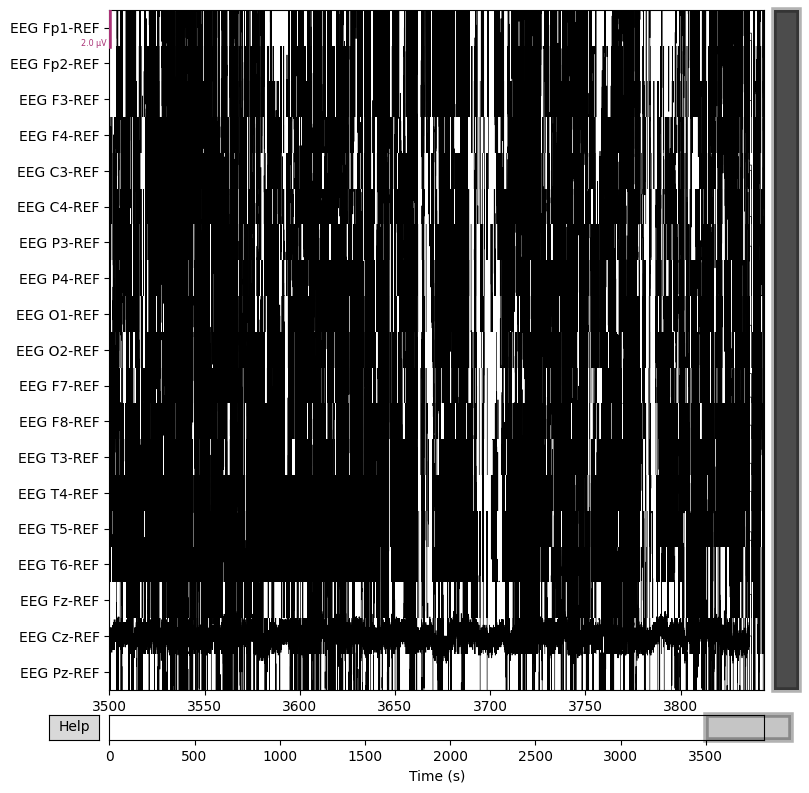

Index: 19
EEG:25


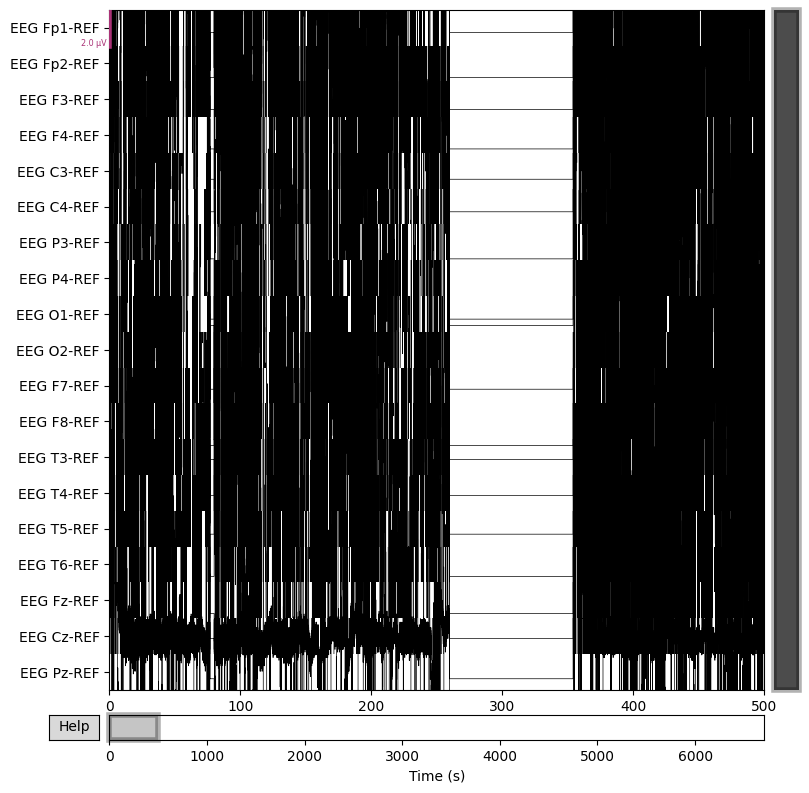

Index: 26
EEG:40


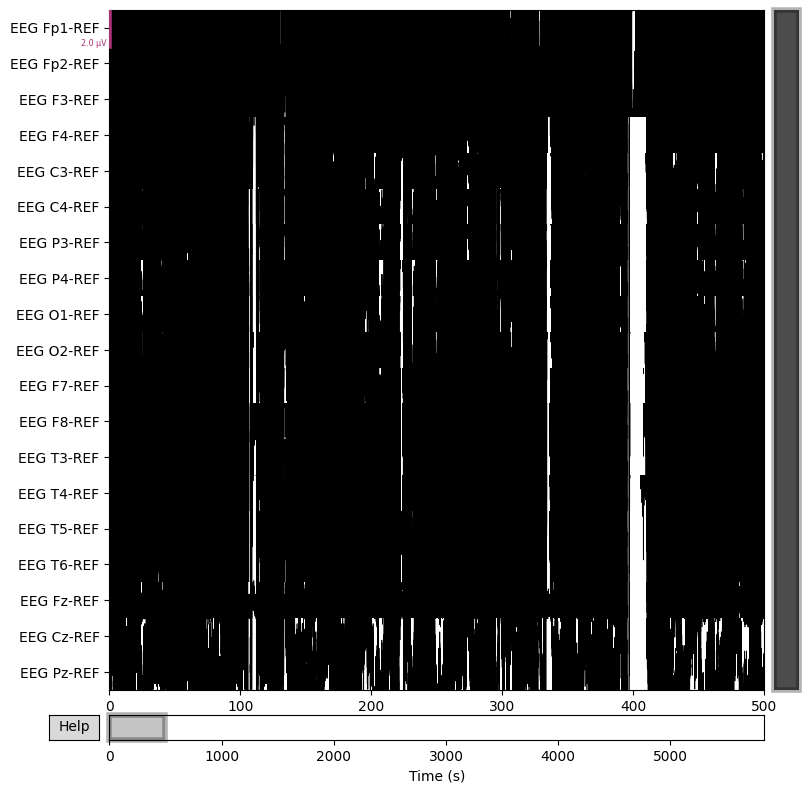

Index: 28
EEG:43


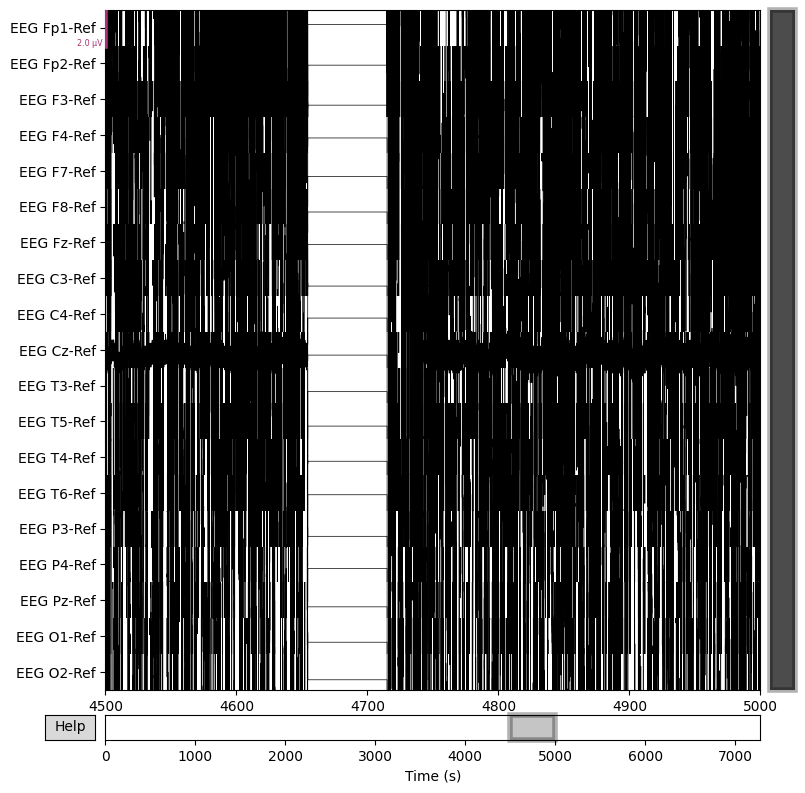

Index: 29
EEG:44


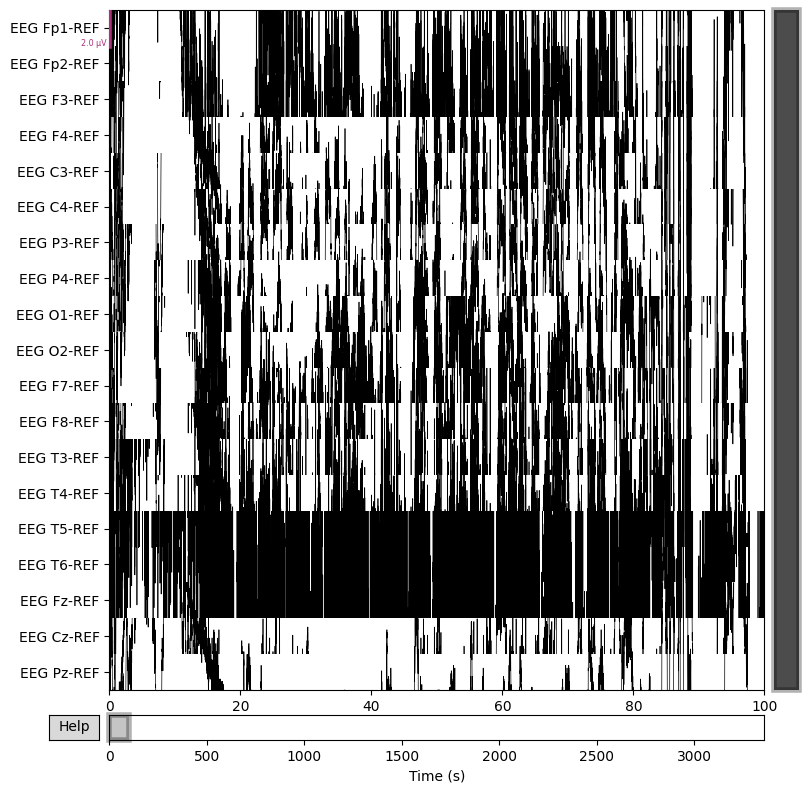

Index: 29
EEG:44


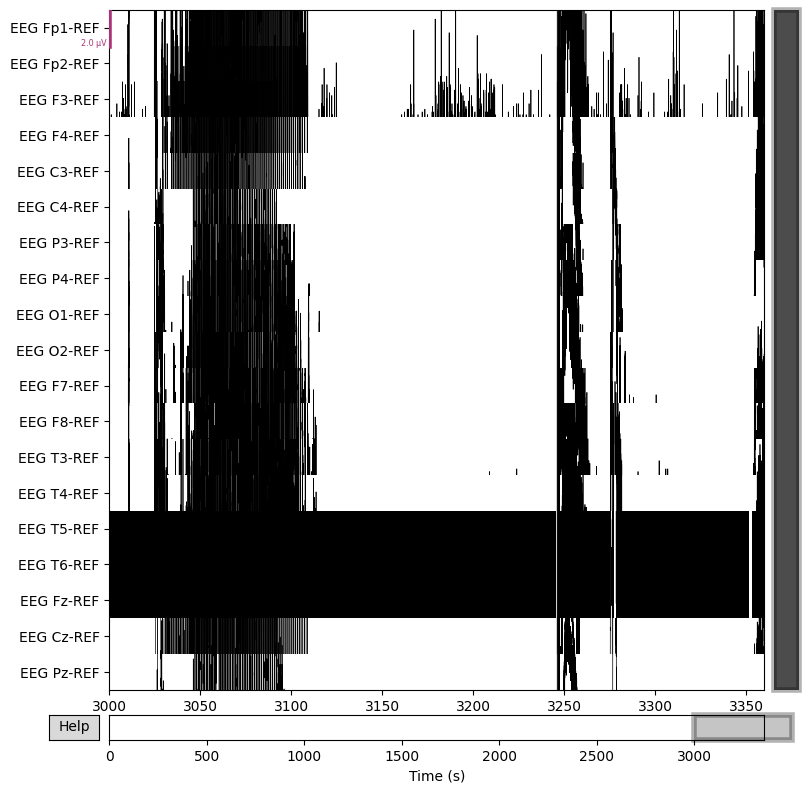

Index: 30
EEG:46


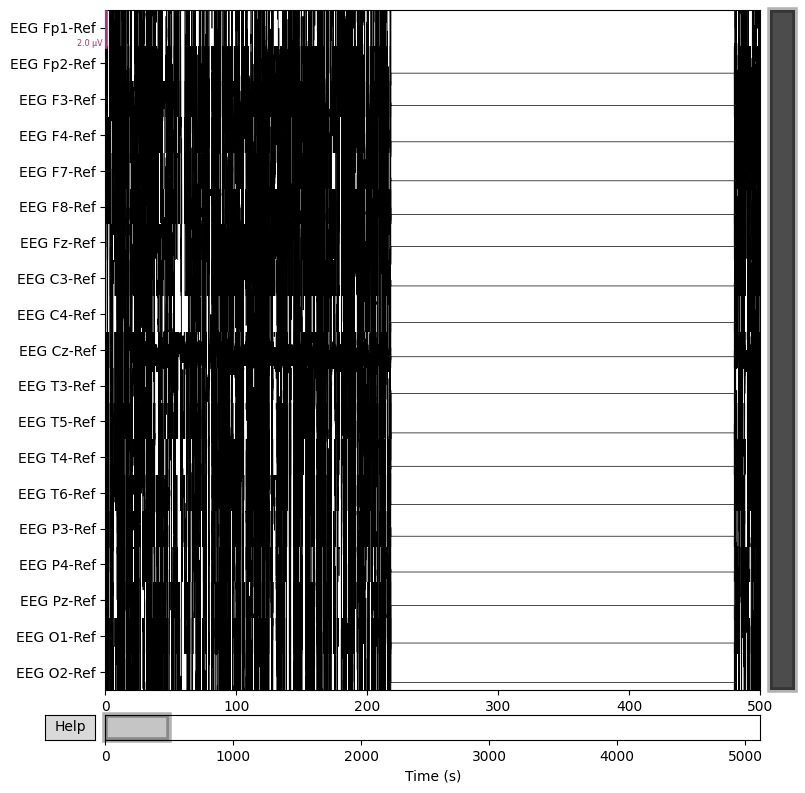

Index: 30
EEG:46


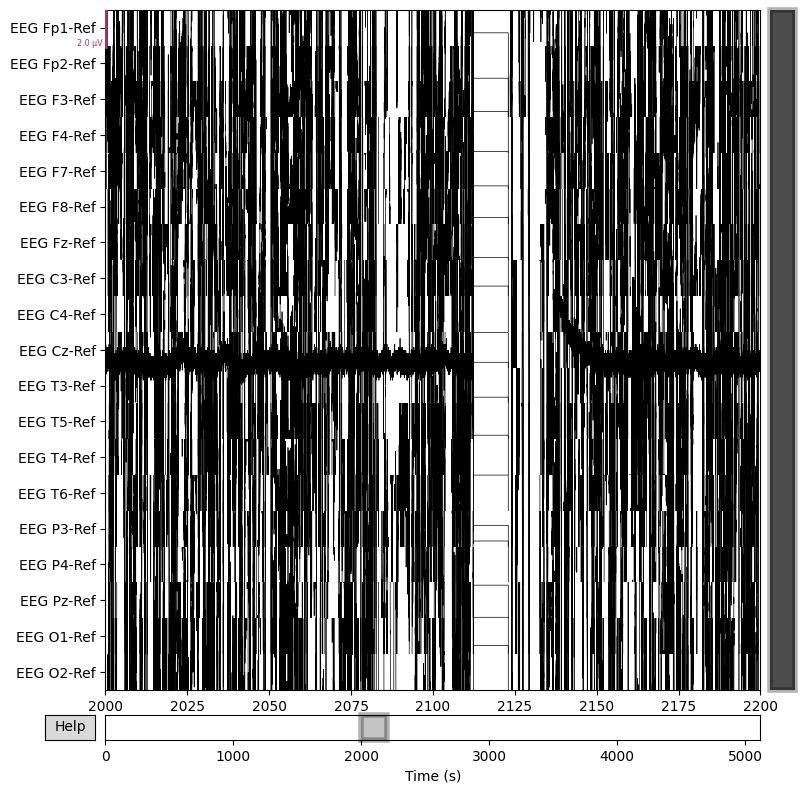

Index: 30
EEG:46


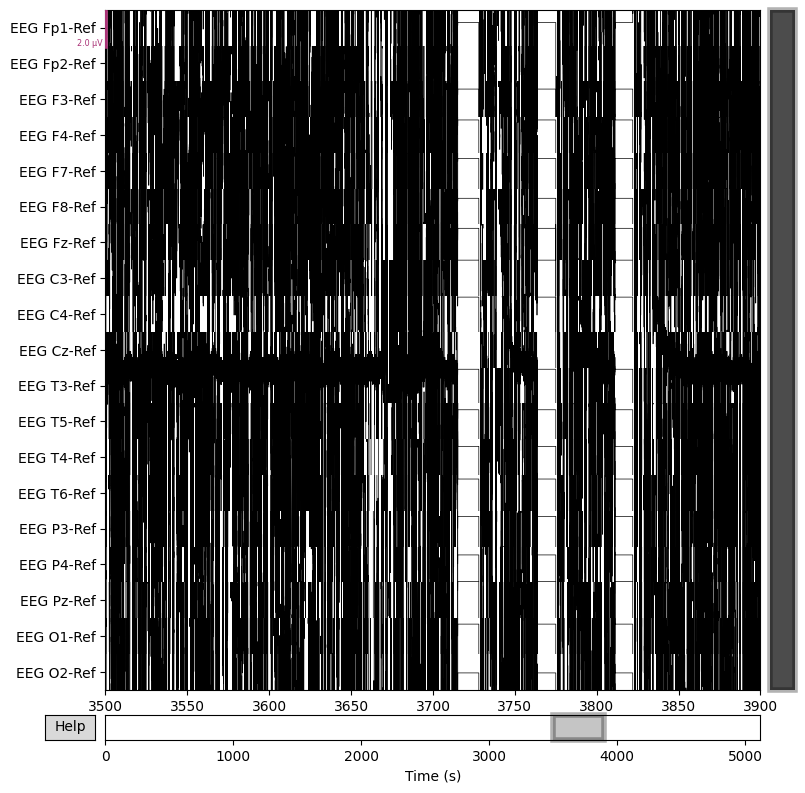

TypeError: 'int' object is not subscriptable

In [26]:
eegs_w_blanks = [[0, [500, 2500]],
                 # [5, [3000, 3250]],
                 [8, [1050, 1100]], #1068 - 1079
                 [13, [3900, 4500]],
                 # [15, [600, 900]],
                 # [16, [1500, 2000]],
                 [17, [3800, 3850]], #3836, 3837, 3843
                 [19, [0, 500]],
                 [26, [140, 400]], # 158, 395, 
                 [28, [4500, 5000]],
                 [29, [0, 100], [3340, 3360]],   # 3351, 3352
                 [30, [0, 500], [2000, 2200], [3500, 3900]],
                 # [31, [500, 600]],
                 [32, [100, 600], [1900, 2100], [3000, 3600]],
                 # [33, [3500, 3800]],
                 [34, [3100, 3400]],
                 [35, [700, 1000], [2200, 2500], [3490, 3550]],
                 [36, [0, 6000]], # just drop channel EEG Fp1-REF
                 [37, [0, 500], [700, 1100], [1200, 1500], [1700, 2200], [2500, 2700], [2800, 3100], [3400, 3600]],
                 # [38, [4000, 4500]],
                 [40, [500, 800]],
                 [41, [500, 800], [1800, 2200]],
                 [43, [0, 50], [3500, 4000]],
                 [46, [2800, 3200]]
                ]

for i in range(len(eegs_w_blanks)):
    eeg_index = eegs_w_blanks[i][0]
    section_count = len(eegs_w_blanks[i]) - 1
    for j in np.arange(section_count)+1:
        start_time = eegs_w_blanks[i][j][0]
        dur = eegs_w_blanks[i][j][1] - start_time
        print("Index:", eeg_index)
        print('EEG:'+annot_eeg_indices[eeg_index])
        eeg_dict['eeg'+annot_eeg_indices[eeg_index]].plot(start=start_time, duration=dur, scalings=10**(-6))

In [90]:
eeg_dict['eeg44'].get_data()[:, 256*3351+90:256*3351+100]

array([[-1.49087771e-07,  1.56087771e-07,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,
         3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09],
       [ 3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,
         3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09],
       [ 3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,
         3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09],
       [ 3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,
         3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09],
       [ 3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,
         3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09,  3.50000000e-09],
       [ 1.56087771e-07,  3.50000000e-09,  3.50000000e-09,  3.500

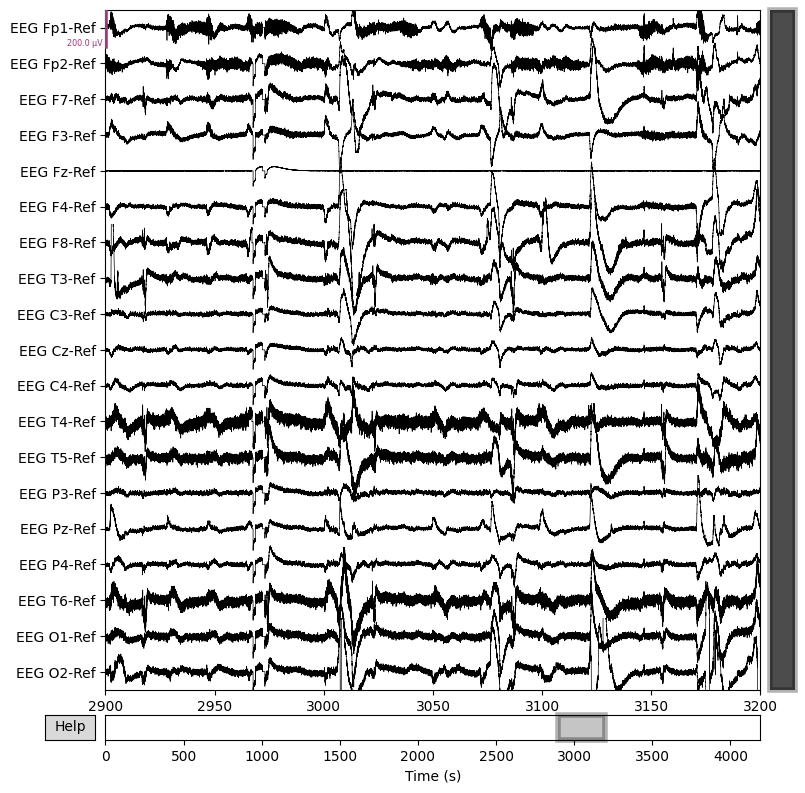

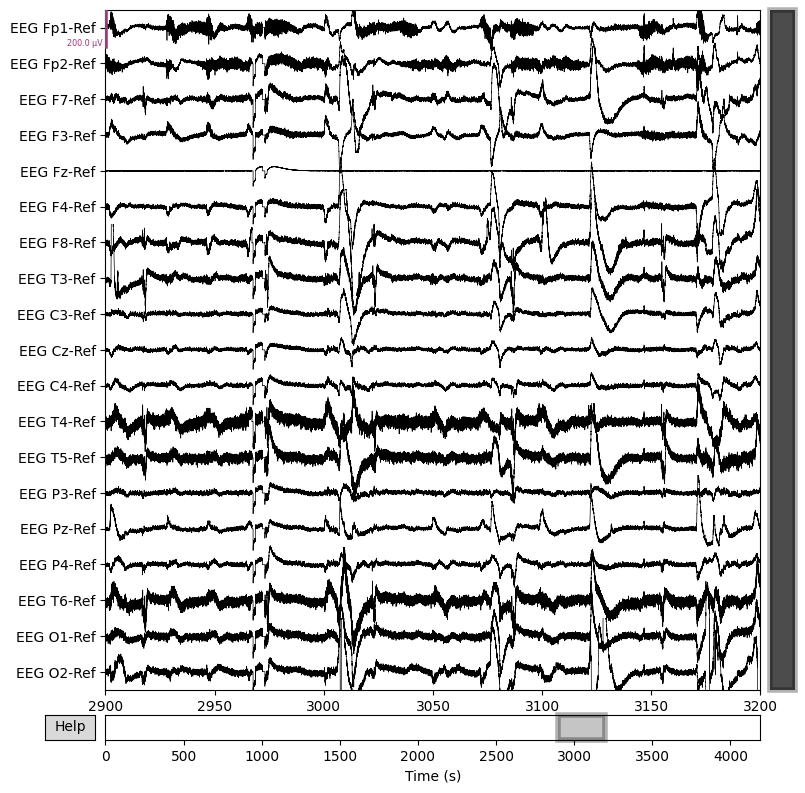

In [261]:
eeg_dict['eeg77'].copy().plot(start=2900, duration=300, scalings=0.0001)#get_data()[:, :256*100]

In [67]:
np.where(eeg_dict['eeg'+annot_eeg_indices[37]].get_data()[0]==0)

(array([], dtype=int64),)

In [118]:
bad_voltage = eeg_dict['eeg'+annot_eeg_indices[41]].get_data()[0,256*660]#.plot(start=650, duration=125)
(np.where(eeg_dict['eeg'+annot_eeg_indices[41]].get_data()[0] == bad_voltage)[0])#.round(3)

array([     60,      94,     209, ..., 1017085, 1017086, 1017087], dtype=int64)

In [130]:
np.where(eeg_dict['eeg'+annot_eeg_indices[41]].get_data()[0] == bad_voltage)[0][:9]

array([ 60,  94, 209, 224, 513, 623, 690, 715, 723], dtype=int64)

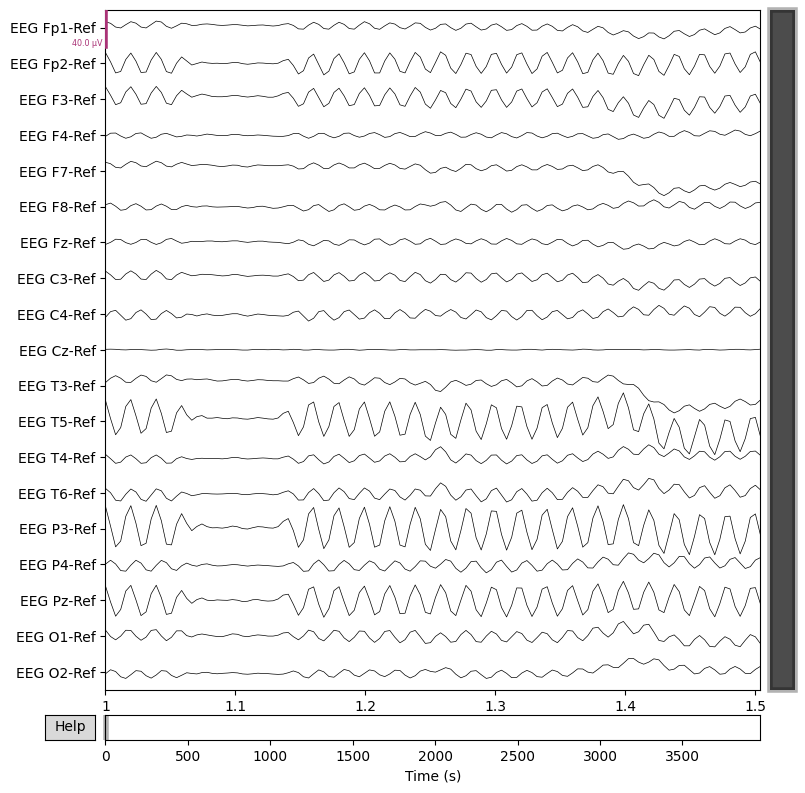

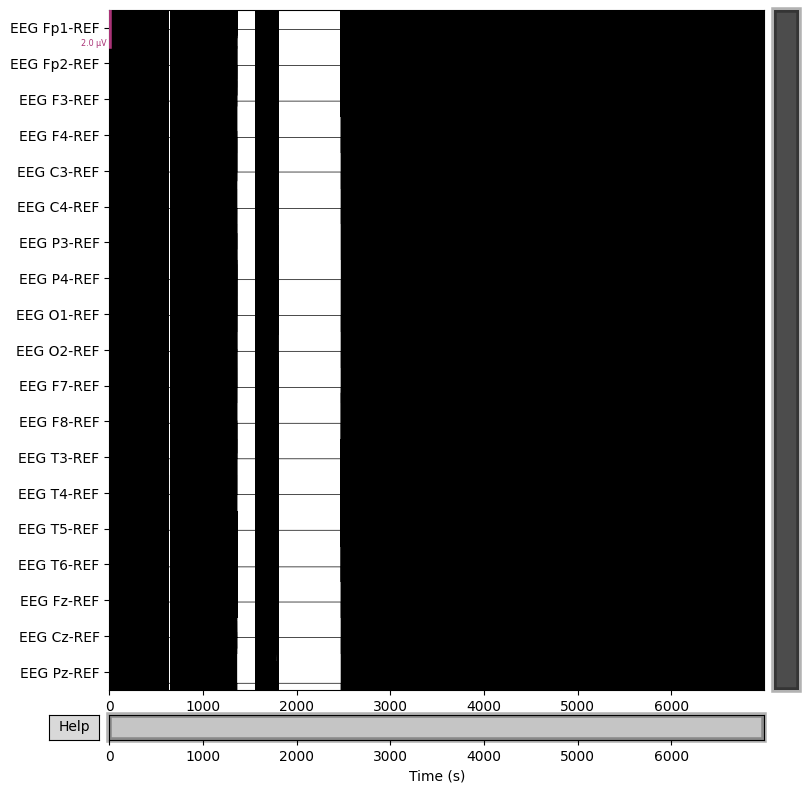

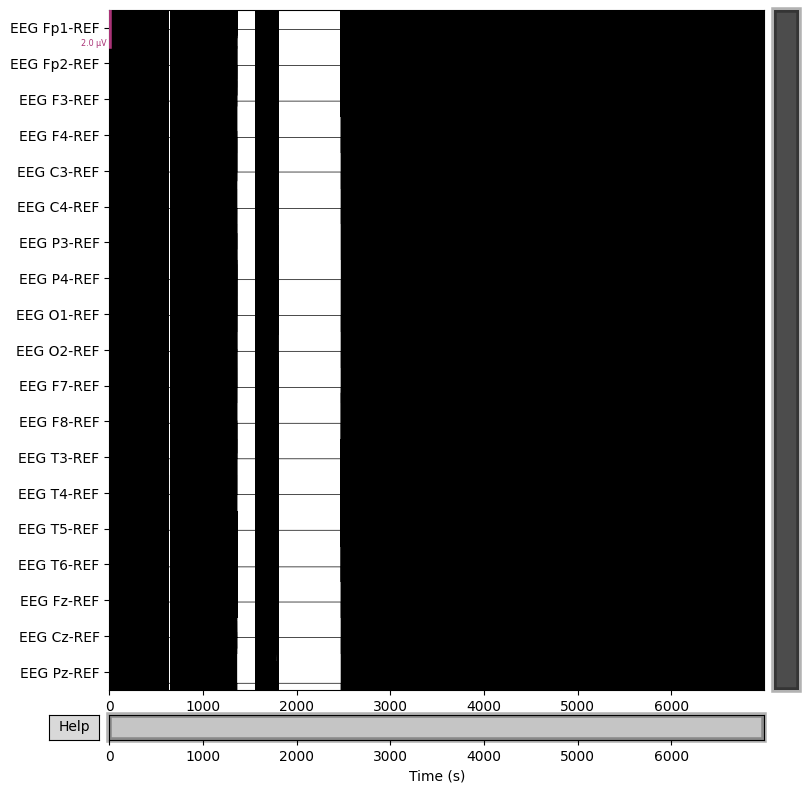

In [19]:
eeg_dict['eeg'+annot_eeg_indices[41]].plot(start=1, duration=0.5)
eeg_dict['eeg1'].plot(duration = max(eeg_dict['eeg1'].times), scalings= 10**(-6))

In [206]:
example_eeg.times.max()

6992.99609375

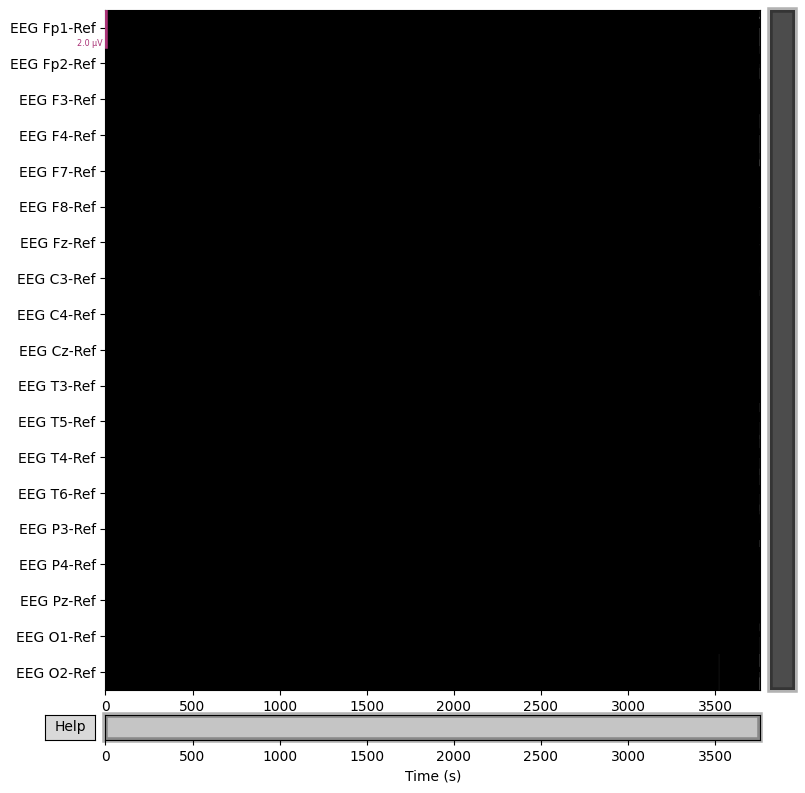

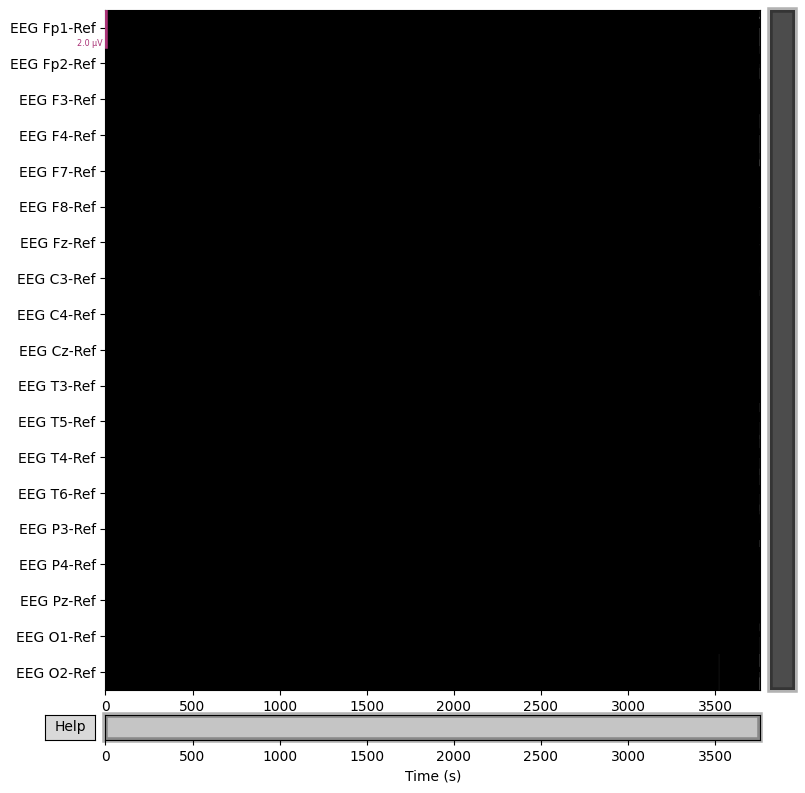

In [214]:
clean_dict['eeg2'].copy().plot(start=0, duration=7000, scalings=10**(-6))
# pick(['EEG T5-REF'])

In [166]:
np.where(clean_dict['eeg1'].get_data()[0]==clean_dict['eeg1'].get_data()[0,2000*256])[0]/256

array([ 235.27734375,  235.609375  ,  235.76953125, ..., 6992.98828125, 6992.9921875 , 6992.99609375])

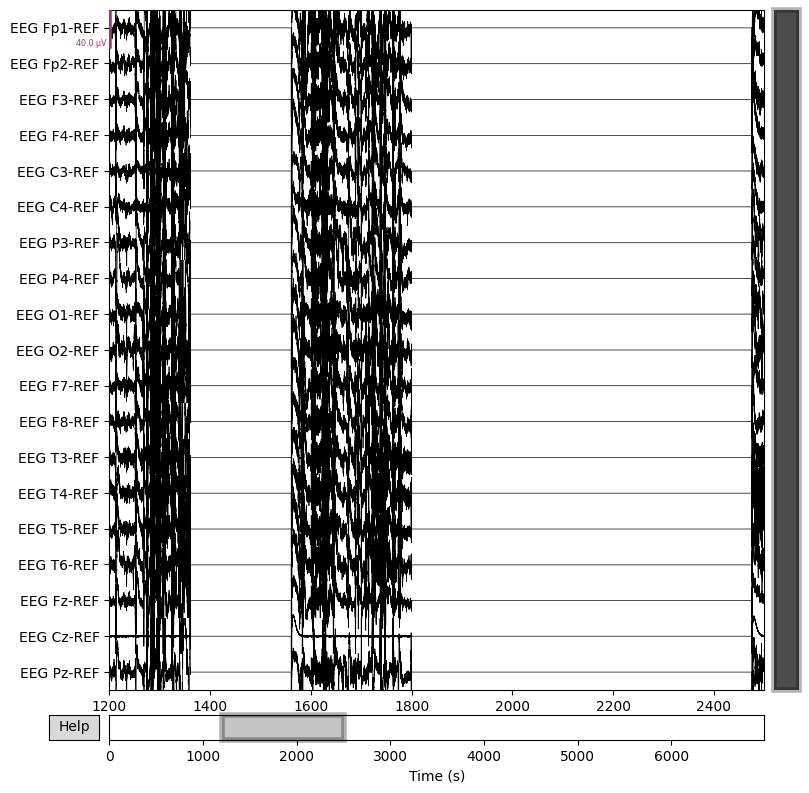

3.999999999905412e-09


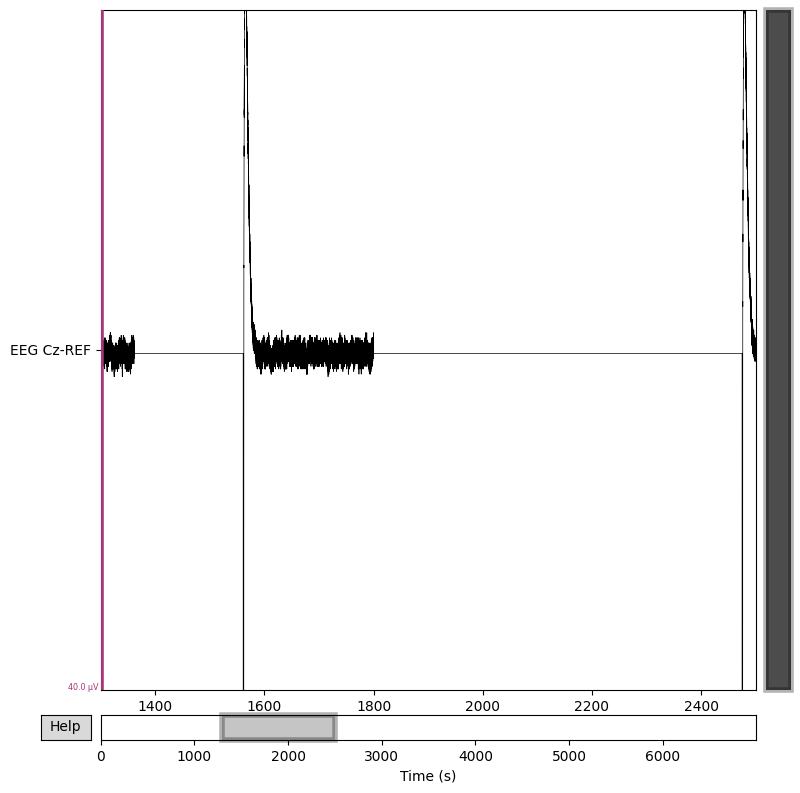

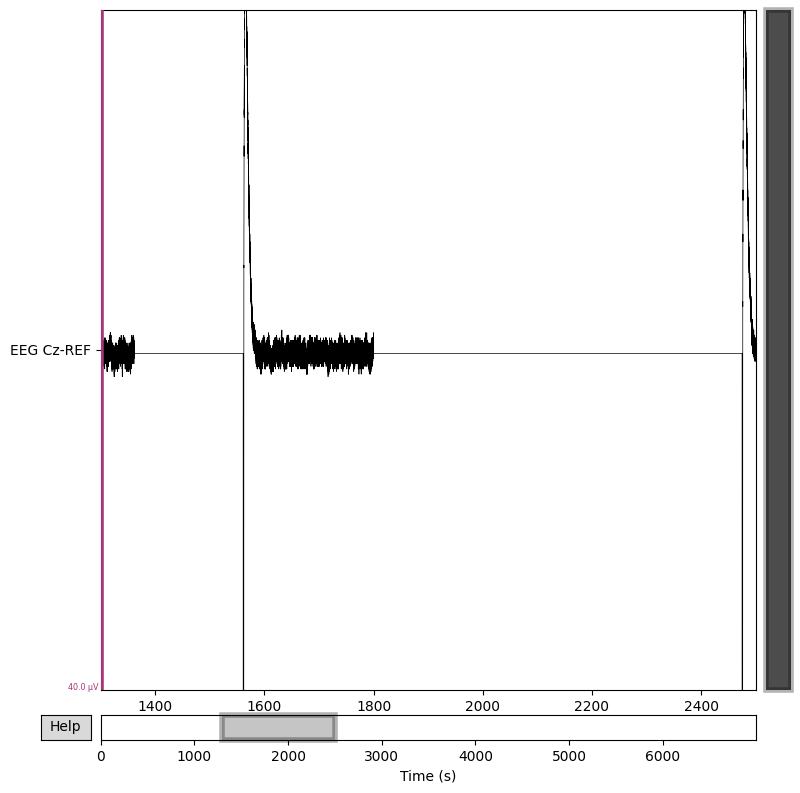

In [162]:
eeg_dict['eeg1'].plot(start =1200, duration=1300)
example_eeg = eeg_dict['eeg1'].copy()
print(bad_voltage)
example_eeg.drop_channels(['EEG F7-REF',
                           'EEG F8-REF',
                           'EEG T3-REF',
                           'EEG T4-REF',
                           'EEG T5-REF',
                           'EEG Fz-REF',
                           'EEG C3-REF',
                           'EEG C4-REF',
                           'EEG P3-REF',
                           'EEG P4-REF',
                           'EEG F4-REF',
                           'EEG Pz-REF',
                           'EEG Fp1-REF',
                           'EEG Fp2-REF',
                           'EEG F3-REF',
                           'EEG O2-REF',
                           'EEG O1-REF',
                           'EEG T6-REF',
                          ]).plot(start=1300, duration=1200)

In [38]:
band_list = ['delta', 'theta', 'alpha', 'beta']
band_bounds = {
    'delta': [0.1,  5],
    'theta':   [5,  8],
    'alpha':   [8, 12],
    'beta':   [12, 30]
}
pwr_in_band_ict = {}
pwr_in_band_non_ict = {}

for band in band_list:
    # pwr_in_band_ict[band] = power_in_range(band_name = band,
    #                                        eeg_data = clean_dict,
    #                                        sampled_times = ictal_times_sample,
    #                                        eeg_indices = annot_eeg_indices
    #                                       )
    pwr_in_band_non_ict[band] = power_in_range(band_name = band,
                                               eeg_data = clean_dict,
                                               sampled_times = non_ictal_times_sample,
                                               eeg_indices = annot_eeg_indices
                                              )

Frequency Band: delta
EEG: 1    1 / 49
Time: 2146
Effective window size : 1.004 (s)
0

	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

1


C:\Users\victo\AppData\Local\Temp\ipykernel_19836\160006373.py:15: UserWarning: Zero value in spectrum for channels EEG Fp2-REF, EEG F3-REF, EEG P3-REF
  psd = eeg.compute_psd(fmin=lower_freq,
C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\specparam\objs\fit.py:1408: RuntimeWarning: divide by zero encountered in log10
  power_spectrum = np.log10(power_spectrum)


DataError: The input power spectra data, after logging, contains NaNs or Infs. This will cause the fitting to fail. One reason this can happen is if inputs are already logged. Input data should be in linear spacing, not log.

In [338]:
pw

KeyError: 'delta'

#### non-ictal power

In [ ]:
# pwr_in_delta_non_ict = np.array([])
# sample_eeg_index = 0

# for i in annot_eeg_indices:
#     pwr_per_time = np.array([])
        
#     for j in list(non_ictal_times_sample[sample_eeg_index]):
#         clear_output(wait=True)
#         print("EEG: ", i)
#         print("Time: ", j)
#         temp_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
#                                                   fmax=upper_freq,
#                                                   tmin=j,
#                                                   tmax=j+1
#                                                  ).get_data()
#         pwr_per_chan = np.array([])
#         for k in range(len(temp_psd)):
#             pwr_per_chan = np.append(pwr_per_chan,
#                                      power_in_freq_range(temp_psd[k])
#                                     )
        
#         pwr_per_time = np.append(pwr_per_time,
#                                  np.mean(pwr_per_chan)
#                                 )
        
#     pwr_in_delta_non_ict = np.append(pwr_in_delta_non_ict, pwr_per_time)
#     sample_eeg_index = sample_eeg_index + 1

## Delta Range

In [17]:
lower_freq, upper_freq = 0.1, 4
pwr_in_delta_ict = np.array([])
sample_eeg_index = 0

for i in annot_eeg_indices:
    pwr_per_time = np.array([])
    
    for j in list(ictal_times_sample[sample_eeg_index]):
        clear_output(wait=True)
        print("EEG: ", i)
        print("Time: ", j)
        test_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
                                                  fmax=upper_freq,
                                                  tmin=j,
                                                  tmax=j+1
                                                 ).get_data()
        pwr_per_chan = np.array([])
        for k in range(len(test_psd)):
            pwr_per_chan = np.append(pwr_per_chan,
                                     power_in_freq_range(test_psd[k])
                                    )
        
        pwr_per_time = np.append(pwr_per_time,
                                 np.mean(pwr_per_chan)
                                )
        
    pwr_in_delta_ict = np.append(pwr_in_delta_ict, pwr_per_time)
    sample_eeg_index = sample_eeg_index + 1

pwr_in_delta_non_ict = np.array([])
sample_eeg_index = 0

for i in annot_eeg_indices:
    pwr_per_time = np.array([])
        
    for j in list(non_ictal_times_sample[sample_eeg_index]):
        clear_output(wait=True)
        print("EEG: ", i)
        print("Time: ", j)
        test_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
                                                  fmax=upper_freq,
                                                  tmin=j,
                                                  tmax=j+1
                                                 ).get_data()
        pwr_per_chan = np.array([])
        for k in range(len(test_psd)):
            pwr_per_chan = np.append(pwr_per_chan,
                                     power_in_freq_range(test_psd[k])
                                    )
        
        pwr_per_time = np.append(pwr_per_time,
                                 np.mean(pwr_per_chan)
                                )
        
    pwr_in_delta_non_ict = np.append(pwr_in_delta_non_ict, pwr_per_time)
    sample_eeg_index = sample_eeg_index + 1

EEG:  79
Time:  1967
Effective window size : 1.004 (s)


## Theta Range

In [18]:
lower_freq, upper_freq = 4, 8
pwr_in_theta_ict = np.array([])
sample_eeg_index = 0

for i in annot_eeg_indices:
    pwr_per_time = np.array([])
    
    for j in list(ictal_times_sample[sample_eeg_index]):
        clear_output(wait=True)
        print("EEG: ", i)
        print("Time: ", j)
        test_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
                                                  fmax=upper_freq,
                                                  tmin=j,
                                                  tmax=j+1
                                                 ).get_data()
        pwr_per_chan = np.array([])
        for k in range(len(test_psd)):
            pwr_per_chan = np.append(pwr_per_chan,
                                     power_in_freq_range(test_psd[k])
                                    )
        
        pwr_per_time = np.append(pwr_per_time,
                                 np.mean(pwr_per_chan)
                                )
        
    pwr_in_theta_ict = np.append(pwr_in_theta_ict, pwr_per_time)
    sample_eeg_index = sample_eeg_index + 1

pwr_in_theta_non_ict = np.array([])
sample_eeg_index = 0

for i in annot_eeg_indices:
    pwr_per_time = np.array([])
        
    for j in list(non_ictal_times_sample[sample_eeg_index]):
        clear_output(wait=True)
        print("EEG: ", i)
        print("Time: ", j)
        test_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
                                                  fmax=upper_freq,
                                                  tmin=j,
                                                  tmax=j+1
                                                 ).get_data()
        pwr_per_chan = np.array([])
        for k in range(len(test_psd)):
            pwr_per_chan = np.append(pwr_per_chan,
                                     power_in_freq_range(test_psd[k])
                                    )
        
        pwr_per_time = np.append(pwr_per_time,
                                 np.mean(pwr_per_chan)
                                )
        
    pwr_in_theta_non_ict = np.append(pwr_in_theta_non_ict, pwr_per_time)
    sample_eeg_index = sample_eeg_index + 1

EEG:  79
Time:  1967
Effective window size : 1.004 (s)


## Alpha Range

In [19]:
lower_freq, upper_freq = 8, 13
pwr_in_alpha_ict = np.array([])
sample_eeg_index = 0

for i in annot_eeg_indices:
    pwr_per_time = np.array([])
    
    for j in list(ictal_times_sample[sample_eeg_index]):
        clear_output(wait=True)
        print("EEG: ", i)
        print("Time: ", j)
        test_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
                                                  fmax=upper_freq,
                                                  tmin=j,
                                                  tmax=j+1
                                                 ).get_data()
        pwr_per_chan = np.array([])
        for k in range(len(test_psd)):
            pwr_per_chan = np.append(pwr_per_chan,
                                     power_in_freq_range(test_psd[k])
                                    )
        
        pwr_per_time = np.append(pwr_per_time,
                                 np.mean(pwr_per_chan)
                                )
        
    pwr_in_alpha_ict = np.append(pwr_in_alpha_ict, pwr_per_time)
    sample_eeg_index = sample_eeg_index + 1

pwr_in_alpha_non_ict = np.array([])
sample_eeg_index = 0

for i in annot_eeg_indices:
    pwr_per_time = np.array([])
        
    for j in list(non_ictal_times_sample[sample_eeg_index]):
        clear_output(wait=True)
        print("EEG: ", i)
        print("Time: ", j)
        test_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
                                                  fmax=upper_freq,
                                                  tmin=j,
                                                  tmax=j+1
                                                 ).get_data()
        pwr_per_chan = np.array([])
        for k in range(len(test_psd)):
            pwr_per_chan = np.append(pwr_per_chan,
                                     power_in_freq_range(test_psd[k])
                                    )
        
        pwr_per_time = np.append(pwr_per_time,
                                 np.mean(pwr_per_chan)
                                )
        
    pwr_in_alpha_non_ict = np.append(pwr_in_alpha_non_ict, pwr_per_time)
    sample_eeg_index = sample_eeg_index + 1

EEG:  79
Time:  1967
Effective window size : 1.004 (s)


## Beta Range

In [20]:
lower_freq, upper_freq = 13, 30
pwr_in_beta_ict = np.array([])
sample_eeg_index = 0

for i in annot_eeg_indices:
    pwr_per_time = np.array([])
    
    for j in list(ictal_times_sample[sample_eeg_index]):
        clear_output(wait=True)
        print("EEG: ", i)
        print("Time: ", j)
        test_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
                                                  fmax=upper_freq,
                                                  tmin=j,
                                                  tmax=j+1
                                                 ).get_data()
        pwr_per_chan = np.array([])
        for k in range(len(test_psd)):
            pwr_per_chan = np.append(pwr_per_chan,
                                     power_in_freq_range(test_psd[k])
                                    )
        
        pwr_per_time = np.append(pwr_per_time,
                                 np.mean(pwr_per_chan)
                                )
        
    pwr_in_beta_ict = np.append(pwr_in_beta_ict, pwr_per_time)
    sample_eeg_index = sample_eeg_index + 1

pwr_in_beta_non_ict = np.array([])
sample_eeg_index = 0

for i in annot_eeg_indices:
    pwr_per_time = np.array([])
        
    for j in list(non_ictal_times_sample[sample_eeg_index]):
        clear_output(wait=True)
        print("EEG: ", i)
        print("Time: ", j)
        test_psd =  eeg_dict['eeg'+i].compute_psd(fmin=lower_freq,
                                                  fmax=upper_freq,
                                                  tmin=j,
                                                  tmax=j+1
                                                 ).get_data()
        pwr_per_chan = np.array([])
        for k in range(len(test_psd)):
            pwr_per_chan = np.append(pwr_per_chan,
                                     power_in_freq_range(test_psd[k])
                                    )
        
        pwr_per_time = np.append(pwr_per_time,
                                 np.mean(pwr_per_chan)
                                )
        
    pwr_in_beta_non_ict = np.append(pwr_in_beta_non_ict, pwr_per_time)
    sample_eeg_index = sample_eeg_index + 1

EEG:  79
Time:  1967
Effective window size : 1.004 (s)


## Combine Power Data

In [344]:
### This is saving data after ICA and Z-scoring, before specparam

import pickle

## Step 2: Saving Variables
# file_path = 'ictal_powers.pickle'

# # Open the file in binary mode
# with open(file_path, 'wb') as file:
#     # Serialize and write the variable to the file
#     pickle.dump(ictal_powers, file)

# file_path = 'non_ictal_powers.pickle'

# with open(file_path, 'wb') as file:
#     # Serialize and write the variable to the file
#     pickle.dump(non_ictal_powers, file)

In [262]:
ictal_powers = np.transpose(np.array([pwr_in_band_ict['delta'],
                                      pwr_in_band_ict['theta'],
                                      pwr_in_band_ict['alpha'],
                                      pwr_in_band_ict['beta']
                                     ]
                                    )
                           )

non_ictal_powers = np.transpose(np.array([pwr_in_band_non_ict['delta'],
                                          pwr_in_band_non_ict['theta'],
                                          pwr_in_band_non_ict['alpha'],
                                          pwr_in_band_non_ict['beta']
                                         ]
                                        )
                               )

## Seperate Train and Test Data

In [263]:
random.seed(1)
ict_test_indices = random.sample(range(len(ictal_powers)), 304)
non_ict_test_indices = random.sample(range(len(non_ictal_powers)), 304)

test_data = np.append(ictal_powers[ict_test_indices], non_ictal_powers[non_ict_test_indices], axis=0)
y_test = np.append(np.ones((304, 1)), np.zeros((304, 1)), axis=0)
train_data = np.append(np.delete(ictal_powers, ict_test_indices, axis=0), np.delete(non_ictal_powers, non_ict_test_indices, axis=0), axis=0)

train_data.shape

(2430, 4)

In [265]:
random.seed(1)
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

y_train = np.append(np.ones((1215, 1)), np.zeros((1215, 1)), axis=0)

scaler = StandardScaler()
x_train = scaler.fit_transform(train_data)
x_test = scaler.fit_transform (test_data)

kernel = "rbf"
model = svm.SVC(kernel=kernel, C=10000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test).reshape(y_test.shape)

clear_output(wait=True)

# Evaluating accuracy of the model.
correct = (y_test == y_pred)
accuracy = np.sum(correct) / len(y_pred)
print("SVM Accuracy: ",accuracy)

SVM Accuracy:  0.5131578947368421


In [231]:
print("SVM Accuracy: ",accuracy)

SVM Accuracy:  0.5542763157894737


In [249]:
# plt.hist(x_train[:,0], bins=)
# plt.show()
np.where(x_train[:,0] == max(x_train[:,0]))[0][0]

594

In [261]:
# x_train[:, 0]
train_data[]

array([3.04853292e-08, 1.68809936e-09, 1.04811556e-10, 4.08516352e-11])

## Bootstraping

In [219]:
def bootstrap_svm_test(x_test, y_test):
    accuracies = []
    k = len(x_test)
    tic = time.perf_counter()

    for i in range(1000):
        clear_output(wait=True)
        print(i)
        toc = time.perf_counter() - tic
        print('Time Elapsed', int(toc / 60), ":", int(toc % 60))
        selection = random.sample(range(k), k = k)
        y_pred = model.predict(x_test).reshape(y_test.shape)
        
        accuracy = sum(y_test[selection] == y_pred) / k
        accuracies.append(accuracy[0])
        
        
    return accuracies

In [220]:
boots_acc = bootstrap_svm_test(test_data, y_test)

999
Time Elapsed 4 : 49


In [342]:
file_path = 'boots_acc.pickle'
with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(boots_acc, file)
file_path = 'boots_full_acc.pickle'
with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(boots_full_acc, file)
file_path = 'norm_boots_full_acc.pickle'
with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(norm_boots_full_acc, file)

In [222]:
np.mean(boots_acc)

0.49981907894736843

In [266]:
# boots_acc_simple = boots_acc
st.t.interval(0.99, df=999, loc=np.mean(boots_acc), scale=st.sem(boots_acc))

(0.4982733630494424, 0.5013647948452944)

In [195]:
import time

def bootstrap_svm_full(x_train, y_train, x_test, y_test):
    accuracies = []
    j = len(x_train)
    k = len(x_test)
    kernel = "rbf"
    tic = time.perf_counter()

    for i in range(1000):
        clear_output(wait=True)
        print(i)
        toc = time.perf_counter() - tic
        print('Time Elapsed', int(toc / 60), ":", int(toc % 60))
        test_selection = random.choices(range(k), k = k)
        train_selection = random.choices(range(j), k = j)

        model = svm.SVC(kernel=kernel, C=10000)
        model.fit(x_train[train_selection], y_train[train_selection])
        y_pred = model.predict(x_test[test_selection]).reshape(y_test.shape)

        accuracy = sum(y_test[test_selection] == y_pred) / k
        accuracies.append(accuracy[0])

    return accuracies

In [176]:
random.seed(1)
boots_full_acc = bootstrap_svm_full(train_data, y_train, test_data, y_test)

999
Seconds Elapsed 729.6676448999206


C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [267]:
random.seed(1)
norm_boots_full_acc = bootstrap_svm_full(x_train, y_train, x_test, y_test)

999
Time Elapsed 60 48


C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [268]:
st.t.interval(0.99, df=999, loc=np.mean(norm_boots_full_acc), scale=st.sem(norm_boots_full_acc)) 

(0.5104373870839366, 0.5151218234423792)

In [194]:
76.6436%60

16.643600000000006

In [69]:
np.mean(boots_full_acc) + 1000*(np.std(boots_full_acc)/√n)

0.4961571237385873

In [180]:
import scipy.stats as st 
  
# create 90% confidence interval 
st.t.interval(0.99, df=999, loc=np.mean(boots_full_acc), scale=st.sem(boots_full_acc)) 
#              scale=st.sem(boots_full_acc))

(0.5538822564890499, 0.5574203750898977)

In [272]:
np.mean(norm_boots_full_acc)

0.5127796052631579

In [358]:
pwr_per_time = np.array([])
for j in list(ictal_times_sample[0]):
    test_psd =  example_eeg.compute_psd(fmin=0.1,
                                        fmax=3,
                                        tmin=j,
                                        tmax=j+1
                                       ).get_data()
    pwr_per_chan = np.array([])
    for i in range(len(test_psd)):
        pwr_per_chan = np.append(pwr_per_chan,
                                 power_in_freq_range(test_psd[i])
                                )
    
    pwr_per_time = np.append(pwr_per_time,
                             np.mean(pwr_per_chan)
                            )

Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective window size : 1.004 (s)
Effective wind

In [333]:
pwr_per_time

array([6.31742960e-11, 1.74946377e-11, 3.74476827e-10, 2.94029086e-10,
       3.50693845e-10, 2.11599492e-11, 5.16930139e-10, 1.95766190e-11,
       1.47036500e-11, 8.07199785e-12, 2.10072654e-11, 2.45699712e-10,
       1.54794830e-11, 3.11186586e-11, 1.07909633e-11, 4.64767430e-11,
       2.34211576e-11, 3.60051206e-11, 1.56352618e-10, 6.69752406e-11,
       6.82841937e-11, 5.66645255e-11, 1.26968219e-10, 4.94048896e-11,
       1.38636487e-11, 1.29754783e-11, 3.51205379e-11, 7.17483110e-11,
       6.41729409e-11, 2.71191186e-11, 1.45005229e-11])

In [81]:
# test_array_welch = mne.time_frequency.psd_array_welch(example_eeg.get_data(), fmin=8, fmax=12, sfreq=256)
test_array_welch[0][:,0]

array([2.84736296e-12, 2.96999528e-12, 3.52352314e-12, 2.16376303e-12, 2.62231073e-12,
       1.63219190e-12, 9.99320164e-12, 2.12846912e-12, 2.30711229e-12, 2.56296420e-12,
       3.44000849e-12, 3.08868074e-12, 3.24335523e-12, 2.87443273e-12, 3.35465487e-12,
       2.54432372e-12, 2.92755494e-12, 7.52079688e-16, 4.62507007e-12, 4.63388405e-11,
       4.64098419e-13])

In [78]:
example_psd.freqs[0]

7.968871595330739

In [4]:
np.set_printoptions(linewidth=100)
example_psd = example_eeg.compute_psd(fmin=7.9, # lowest frequency to include (if you try setting 8, then it won't include 8Hz)
                                      fmax=12,  # highest frequency to include
                                      tmin=0,   # start time in seconds
                                      tmax=1    # end time in seconds
                                     )
# this PSD is from time 0s to 1s
# in the data here: row means channel and column means frequency (8, 9, 10, 11, 12 Hz)
example_psd.get_data()

Effective window size : 1.004 (s)


array([[2.87741874e-14, 8.43972243e-15, 8.10326082e-15, 3.14649445e-14, 3.38811840e-14],
       [1.29868332e-14, 2.45191135e-14, 9.23794028e-16, 4.32648077e-14, 2.41150332e-14],
       [1.63864488e-15, 2.40136784e-15, 2.98972532e-15, 1.49836696e-14, 4.47388438e-15],
       [4.03636280e-15, 2.96572387e-14, 3.31315932e-15, 1.75238429e-14, 1.78309314e-14],
       [5.18755395e-14, 1.01420575e-13, 2.06722346e-14, 8.82377792e-14, 6.13024779e-14],
       [3.02017108e-14, 5.29829053e-14, 5.47268080e-15, 1.29214506e-14, 1.88565684e-14],
       [1.16288368e-14, 3.17455550e-14, 7.49187353e-15, 1.83327135e-14, 9.05810636e-15],
       [1.16770738e-14, 3.22418175e-14, 3.62858940e-15, 6.80411206e-15, 4.27066538e-15],
       [1.71530093e-14, 5.09248721e-14, 4.80658653e-17, 2.39050815e-16, 1.16322184e-14],
       [1.04687351e-15, 2.07703123e-14, 4.05358354e-15, 3.83278967e-15, 2.01071394e-15],
       [9.98078824e-17, 1.11714053e-14, 6.09894182e-15, 2.21513733e-14, 3.02267866e-14],
       [1.20134663e-1

C:\Users\victo\AppData\Local\Temp\ipykernel_20944\3732476071.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  example_psd.plot(picks=[18, 19])
C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


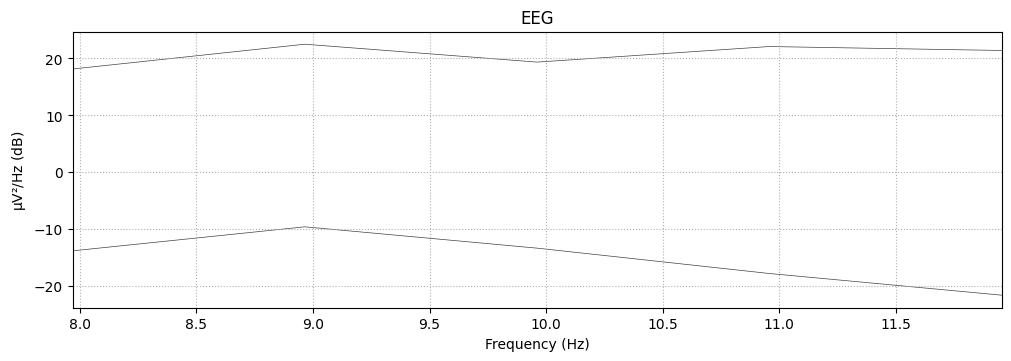

In [53]:

example_psd.plot(picks=[19])

In [40]:
power_in_freq_range(example_psd.get_data()[19])

5.282804431962137e-10

In [183]:
from sklearn import svm
# from sklearn.datasets import make_classification



In [159]:
seizure_eeg_indices = np.array([ 1, 
                                 #2, ######
                                 #3, ######
                                 4,  5, 7, 9, 11, 13, 14, 15, 16, 17,
                                #19, ######
                                20, 21, 22,
                                #25, #24, 26, ######
                                31,
                                34, 36, 38, 39, 40, 41,
                                #43, ######
                                44,
                                #46, ######
                                47, 50, 51,
                                54, ######
                                62, 63,
                                66, 67,
                                69, 71, 73,
                                75, 76, 77, 78, 79]) - 1
seizure_eeg_indices

array([ 0,  3,  4,  6,  8, 10, 12, 13, 14, 15, 16, 19, 20, 21, 30, 33, 35, 37, 38, 39, 40, 43, 46,
       49, 50, 53, 61, 62, 65, 66, 68, 70, 72, 74, 75, 76, 77, 78])

In [160]:
seizure_eeg_indices.shape

(38,)

In [164]:
# accessing ictal time step indicies
annot_A_EEG1 = annot_A.to_numpy()[:,0]

ictal_index = np.where(annot_A_EEG1[~np.isnan(annot_A_EEG1)]==1)
len(ictal_index[0])

amt_of_ictal = []

for i in seizure_eeg_indices:
    annot_A_EEG_i = annot_A.to_numpy()[:,i]
    ictal_index_i = np.where(annot_A_EEG_i[~np.isnan(annot_A_EEG_i)]==1)[0]
    if i > 9:
        print("EEG", i+1, ":", len(ictal_index_i))
    else:
        print("EEG ", i+1, ":", len(ictal_index_i))
    amt_of_ictal.append(len(ictal_index_i))

EEG  1 : 1602
EEG  4 : 925
EEG  5 : 3325
EEG  7 : 625
EEG  9 : 882
EEG 11 : 99
EEG 13 : 1271
EEG 14 : 2142
EEG 15 : 1471
EEG 16 : 620
EEG 17 : 171
EEG 20 : 751
EEG 21 : 43
EEG 22 : 697
EEG 31 : 182
EEG 34 : 455
EEG 36 : 492
EEG 38 : 2983
EEG 39 : 2259
EEG 40 : 601
EEG 41 : 8081
EEG 44 : 341
EEG 47 : 211
EEG 50 : 930
EEG 51 : 385
EEG 54 : 1267
EEG 62 : 382
EEG 63 : 373
EEG 66 : 1738
EEG 67 : 1424
EEG 69 : 2268
EEG 71 : 124
EEG 73 : 868
EEG 75 : 920
EEG 76 : 477
EEG 77 : 258
EEG 78 : 2216
EEG 79 : 198


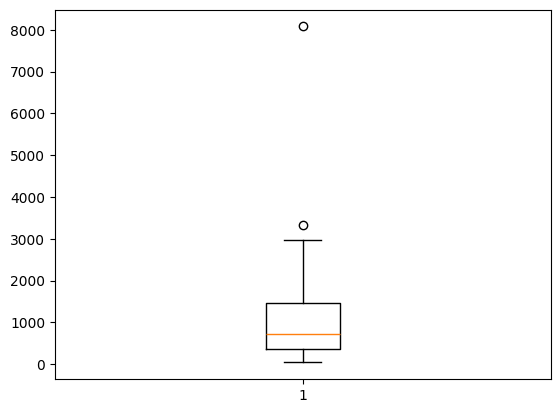

{'whiskers': [<matplotlib.lines.Line2D at 0x18ca9c489d0>,
 'caps': [<matplotlib.lines.Line2D at 0x18ca8352090>,
 'boxes': [<matplotlib.lines.Line2D at 0x18ca0cf77d0>],
 'medians': [<matplotlib.lines.Line2D at 0x18ca9c5d890>],
 'fliers': [<matplotlib.lines.Line2D at 0x18ca837cf10>],
 'means': []}

In [170]:
plt.show()
plt.boxplot(np.array(amt_of_ictal))


In [162]:
# accessing ictal time step indicies
annot_B_EEG1 = annot_B.to_numpy()[:,0]

ictal_index = np.where(annot_B_EEG1[~np.isnan(annot_B_EEG1)]==1)
len(ictal_index[0])

for i in seizure_eeg_indices:
    annot_B_EEG_i = annot_B.to_numpy()[:,i]
    ictal_index_i = np.where(annot_B_EEG_i[~np.isnan(annot_B_EEG_i)]==1)[0]
    if i > 9:
        print("EEG", i+1, ":", len(ictal_index_i))
    else:
        print("EEG ", i+1, ":", len(ictal_index_i))

EEG  1 : 3141
EEG  4 : 1161
EEG  5 : 3189
EEG  7 : 970
EEG  9 : 1041
EEG 11 : 127
EEG 13 : 1421
EEG 14 : 2413
EEG 15 : 573
EEG 16 : 4247
EEG 17 : 583
EEG 20 : 1794
EEG 21 : 42
EEG 22 : 1379
EEG 31 : 181
EEG 34 : 452
EEG 36 : 532
EEG 38 : 4505
EEG 39 : 2517
EEG 40 : 627
EEG 41 : 9450
EEG 44 : 397
EEG 47 : 312
EEG 50 : 898
EEG 51 : 320
EEG 54 : 0
EEG 62 : 390
EEG 63 : 1041
EEG 66 : 1878
EEG 67 : 1648
EEG 69 : 3455
EEG 71 : 319
EEG 73 : 1140
EEG 75 : 925
EEG 76 : 600
EEG 77 : 462
EEG 78 : 2513
EEG 79 : 475


In [163]:
# accessing ictal time step indicies
annot_C_EEG1 = annot_C.to_numpy()[:,0]

ictal_index = np.where(annot_C_EEG1[~np.isnan(annot_C_EEG1)]==1)
len(ictal_index[0])

for i in seizure_eeg_indices:
    annot_C_EEG_i = annot_C.to_numpy()[:,i]
    ictal_index_i = np.where(annot_C_EEG_i[~np.isnan(annot_C_EEG_i)]==1)[0]
    if i > 9:
        print("EEG", i+1, ":", len(ictal_index_i))
    else:
        print("EEG ", i+1, ":", len(ictal_index_i))

EEG  1 : 997
EEG  4 : 987
EEG  5 : 3184
EEG  7 : 608
EEG  9 : 862
EEG 11 : 40
EEG 13 : 1346
EEG 14 : 2314
EEG 15 : 1308
EEG 16 : 1355
EEG 17 : 60
EEG 20 : 1054
EEG 21 : 39
EEG 22 : 640
EEG 31 : 168
EEG 34 : 452
EEG 36 : 451
EEG 38 : 2864
EEG 39 : 2229
EEG 40 : 513
EEG 41 : 8542
EEG 44 : 335
EEG 47 : 201
EEG 50 : 902
EEG 51 : 491
EEG 54 : 2152
EEG 62 : 380
EEG 63 : 2040
EEG 66 : 1548
EEG 67 : 1576
EEG 69 : 2716
EEG 71 : 107
EEG 73 : 1047
EEG 75 : 918
EEG 76 : 429
EEG 77 : 520
EEG 78 : 2011
EEG 79 : 242


In [6]:
a.get_data().shape[1]/256
len(np.arange(0,a.get_data().shape[1]/256, 1/256))== a.get_data().shape[1]

True

In [7]:
b = mne.io.read_raw_edf("eeg1.edf", preload=True)
b_filt = b.filter(10, 60)

a = mne.io.read_raw_edf("eeg1.edf")

# plt.figure(figsize=(20,5))
# plt.title("eeg1, channel #0")#, unfiltered")
# plt.xlabel("Time (s)")
# plt.ylabel("Voltage (uV)")
# plt.plot(np.arange(0,a.get_data().shape[1]/256, 1/256), a.get_data()[0])

# plt.figure(figsize=(20,5))
# plt.title("eeg1, channel #0, filtered(10-50 Hz)")
# plt.xlabel("Time (s)")
# plt.ylabel("Voltage (uV)")
# plt.plot(np.arange(0,b_filt.get_data().shape[1]/256, 1/256), b_filt.get_data()[0])

Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1790207  =      0.000 ...  6992.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 339 samples (1.324 s)

Extracting EDF parameters from C:\Users\victo\jupyter_files\BIM 280\Final_Project\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [10]:
plt.plot(np.arange(0, len(a.compute_psd().get_data()[0])/10, 0.1), a.compute_psd().get_data()[0])

Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


In [11]:
a_filt.get_data()[0]

NameError: name 'a_filt' is not defined

In [12]:
# sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / / /)
raw = mne.io.read_raw(sample_data_raw_file)

SyntaxError: invalid syntax (2917044014.py, line 3)

Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\victo\AppData\Local\Temp\ipykernel_29448\497822338.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\victo\AppData\Local\Temp\ipykernel_29448\497822338.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\victo\AppData\Local\Temp\ipykernel_29448\497822338.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
C:\Users\victo\anaconda3\envs\bi

Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 1.004 (s)


C:\Users\victo\AppData\Local\Temp\ipykernel_29448\497822338.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\victo\AppData\Local\Temp\ipykernel_29448\497822338.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\victo\AppData\Local\Temp\ipykernel_29448\497822338.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
C:\Users\victo\anaconda3\envs\bi

Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 1.004 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\victo\AppData\Local\Temp\ipykernel_29448\497822338.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\victo\AppData\Local\Temp\ipykernel_29448\497822338.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
C:\Users\victo\anaconda3\envs\bim280\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


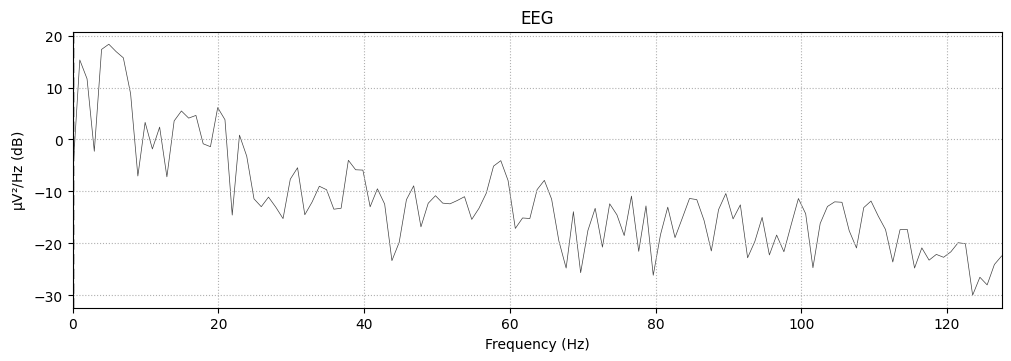

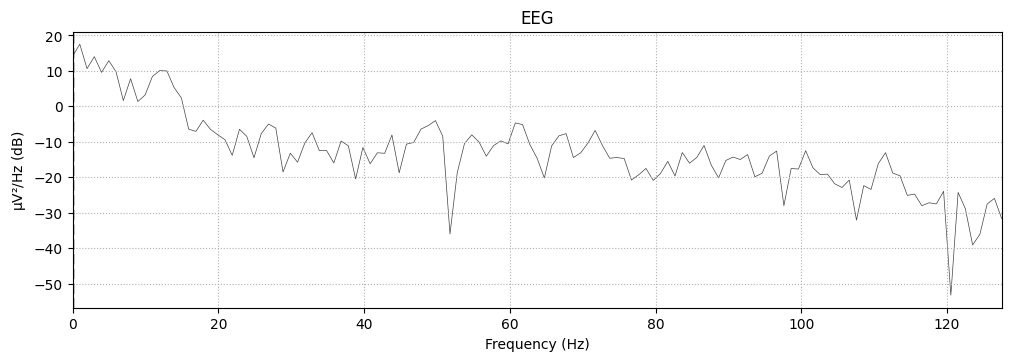

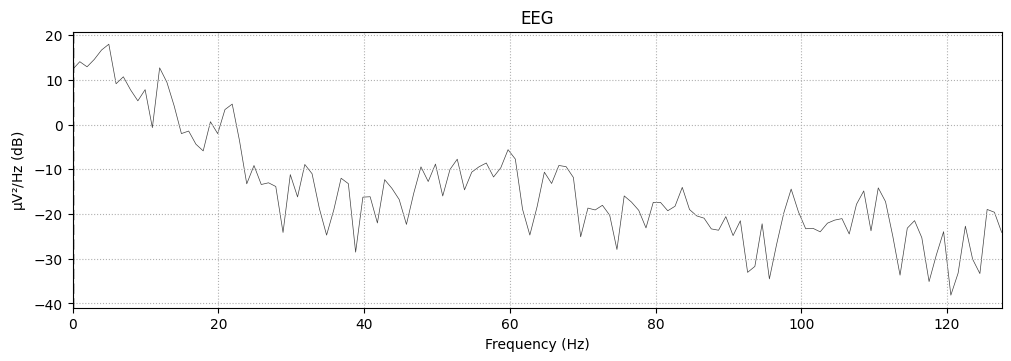

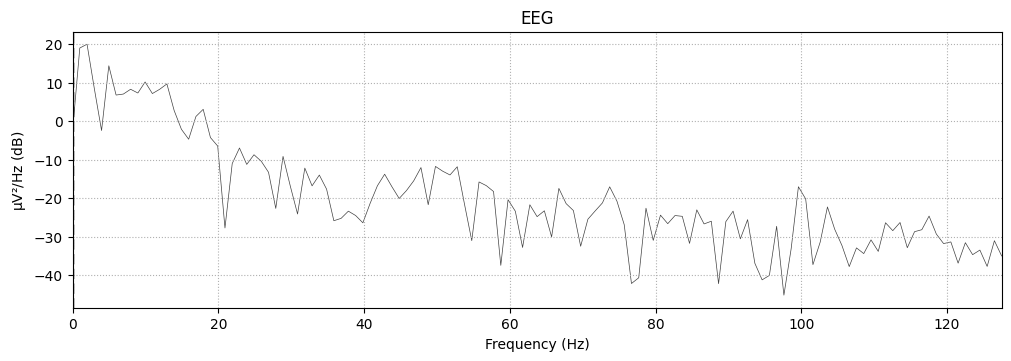

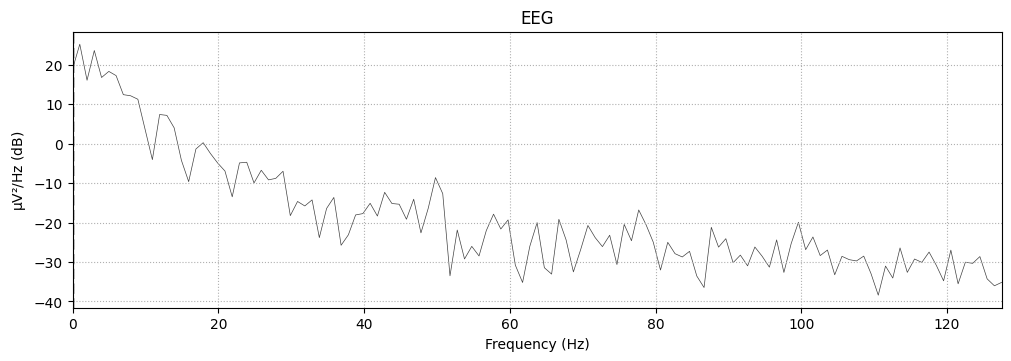

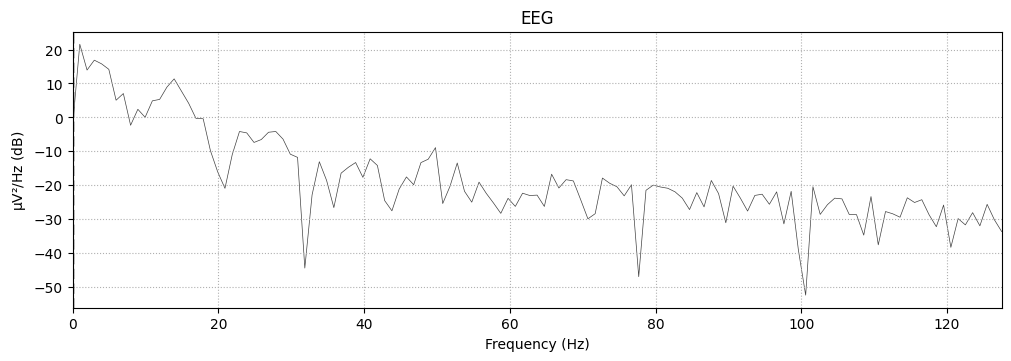

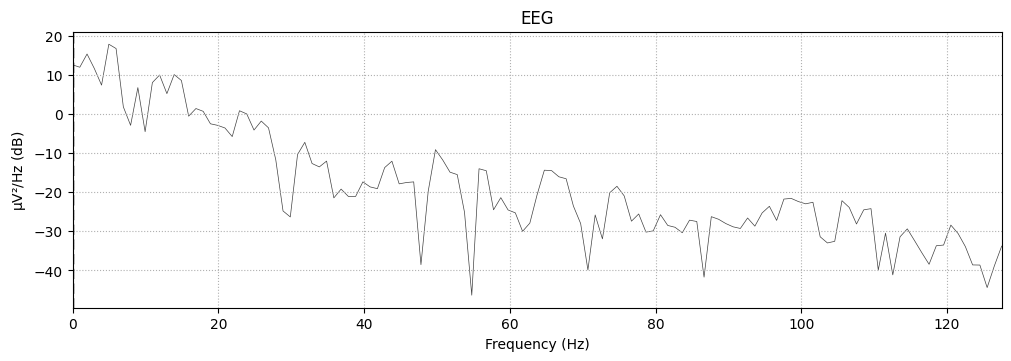

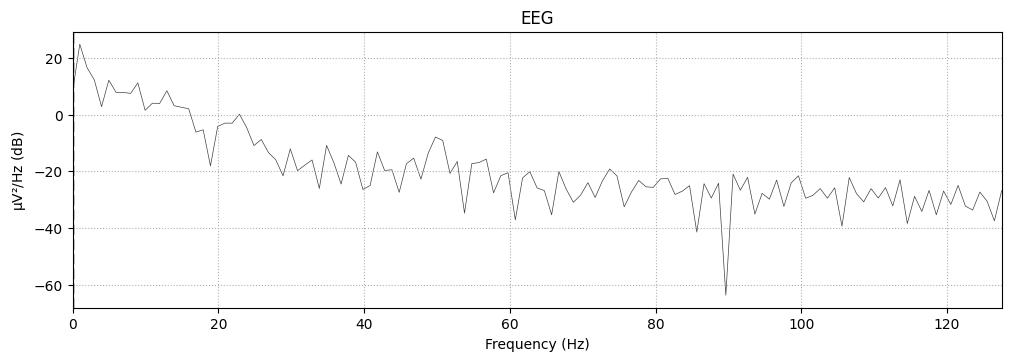

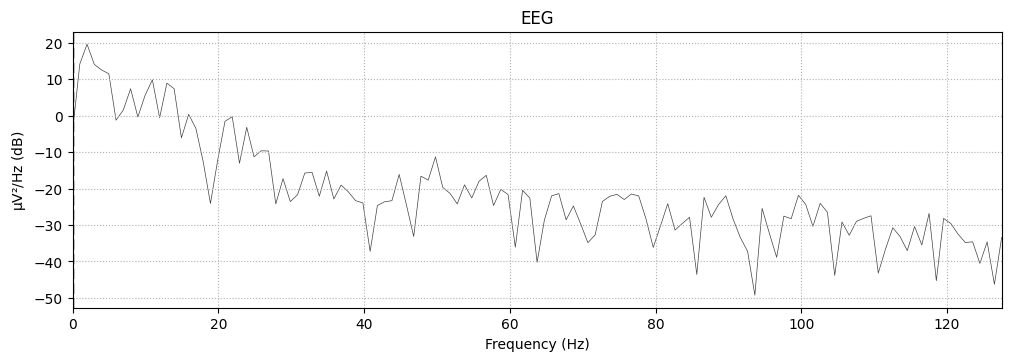

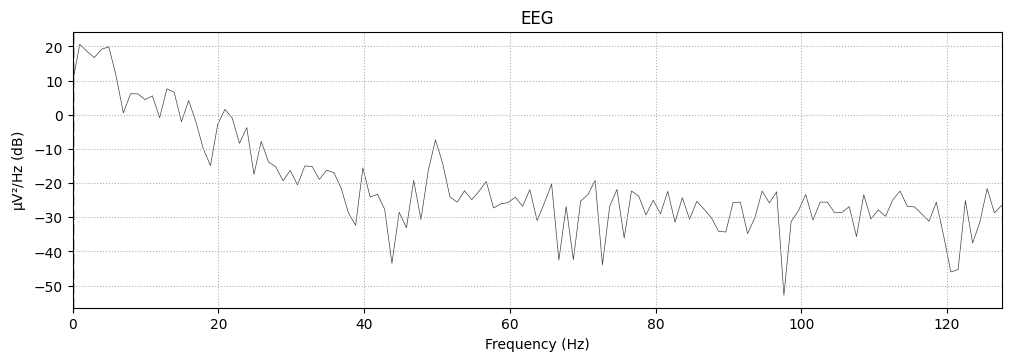

In [183]:
# eeg_dict['eeg10'].compute_psd().plot()
test = eeg_dict['eeg05'].copy()
# plt.figure(figsize=(8.7,2))
# plt.plot(np.arange(len(test.get_data()[0,:2560])), test.get_data()[0,:2560])
# plt.figure()
for i in range(10):
    test.compute_psd(picks = [0], tmin = i, tmax = i+1).plot()
# test.compute_psd().plot()

In [58]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.datasets import make_classification

In [59]:
RFC()

(100, 20)
(100,)
[0, 0, 1, 1, 0]


C:\Users\victo\AppData\Local\Temp\ipykernel_19300\3745169964.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20,5))


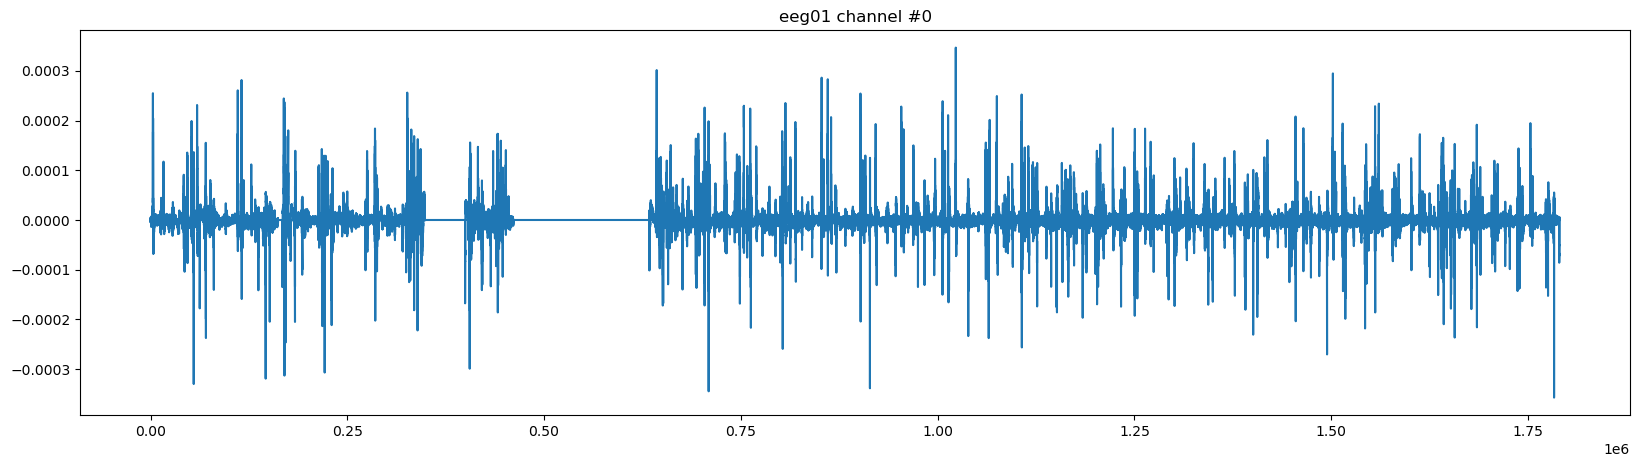

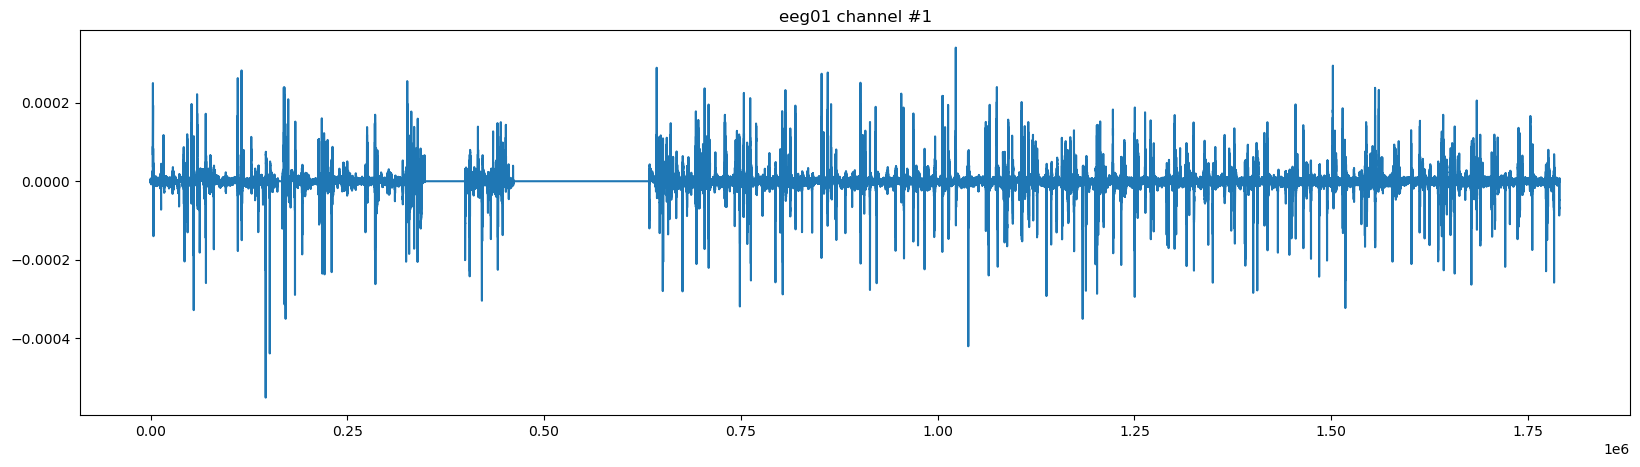

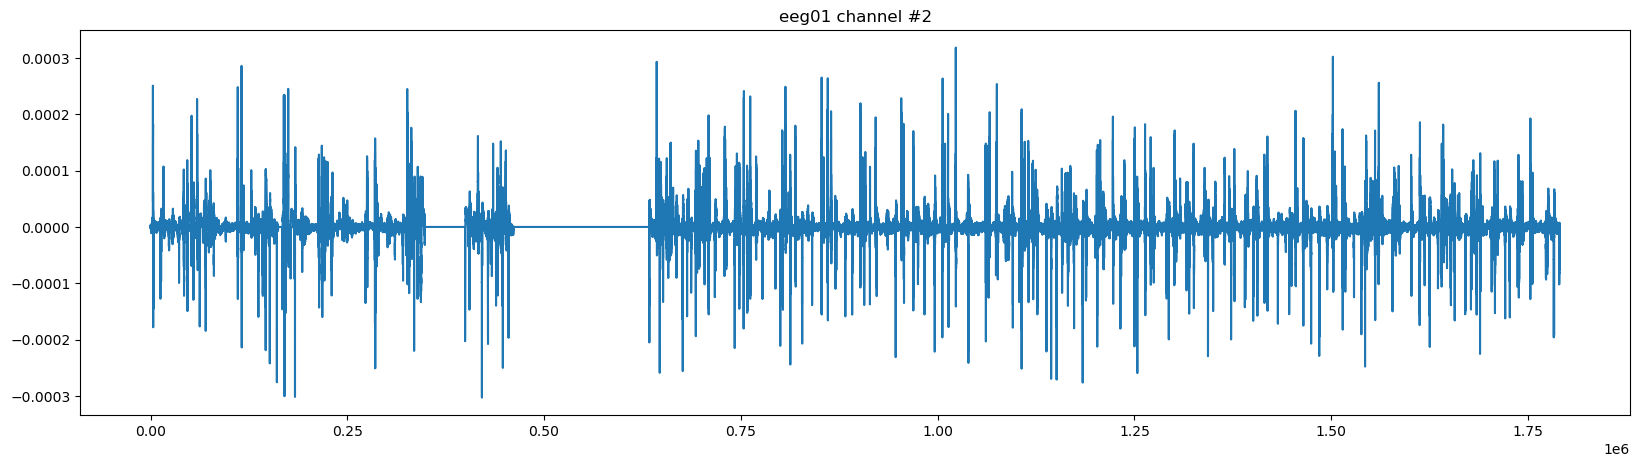

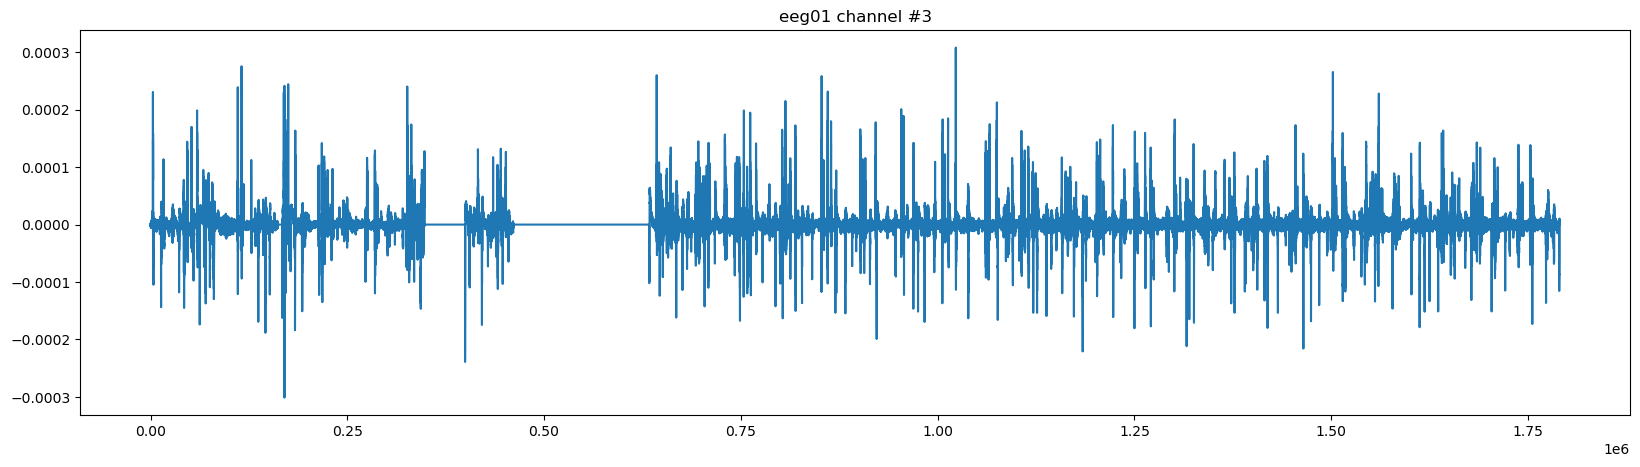

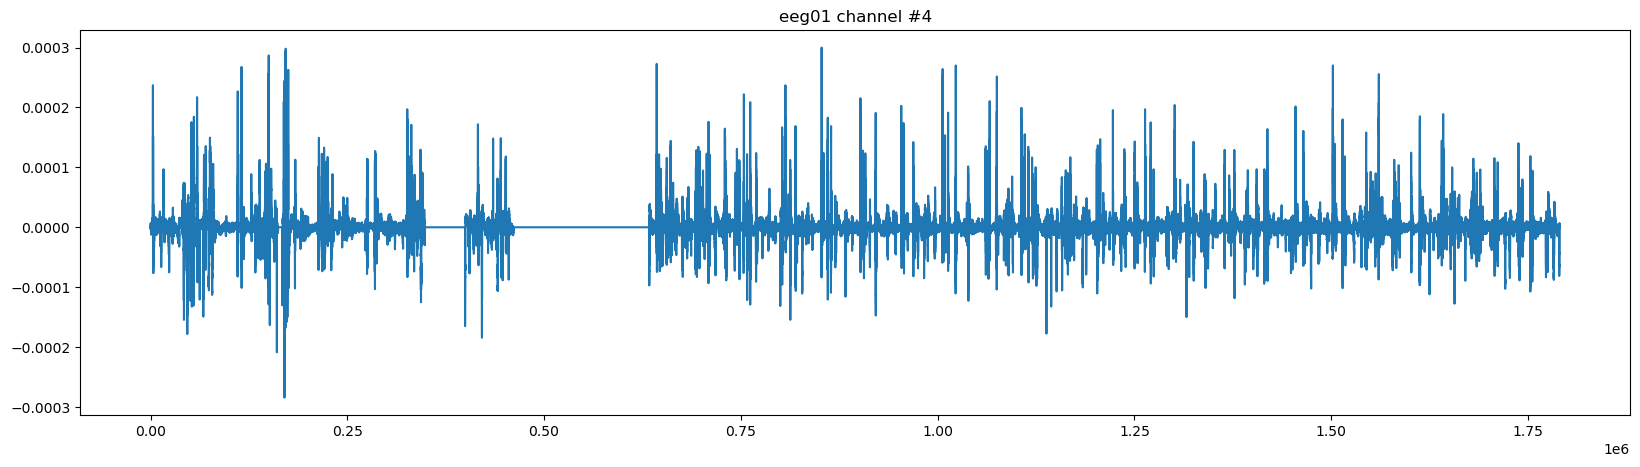

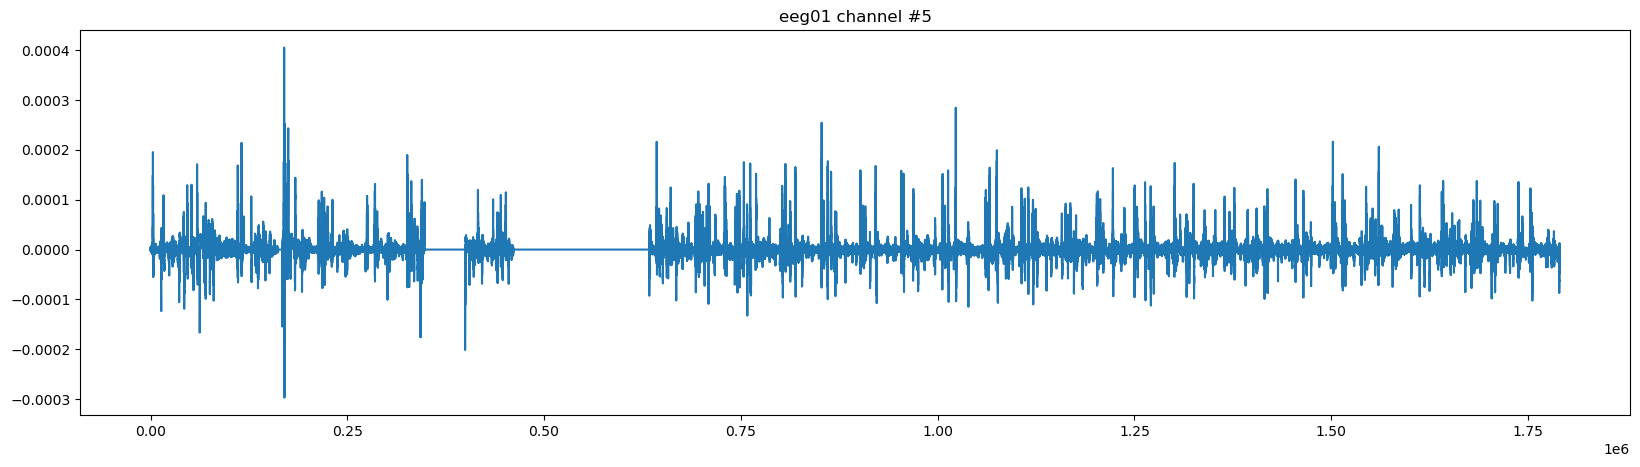

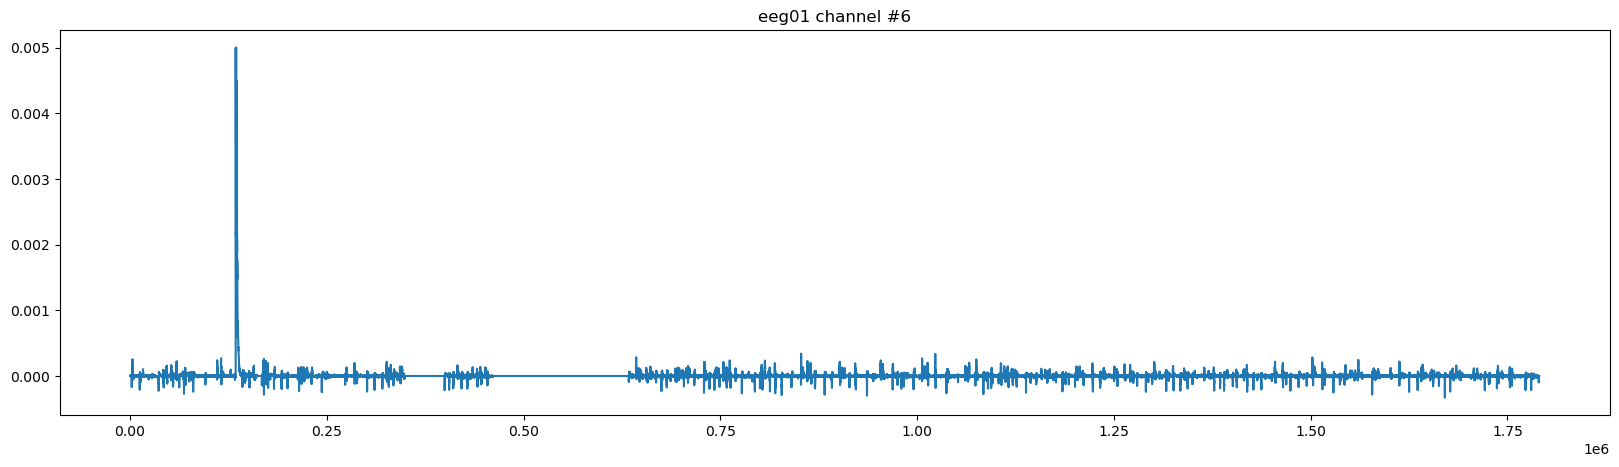

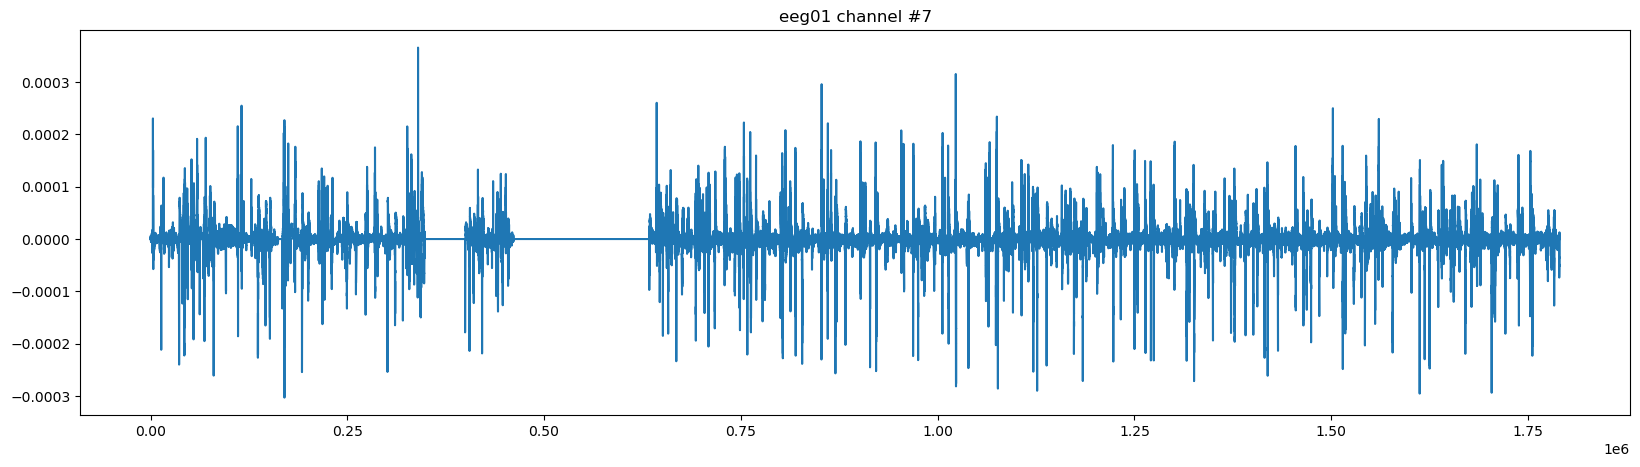

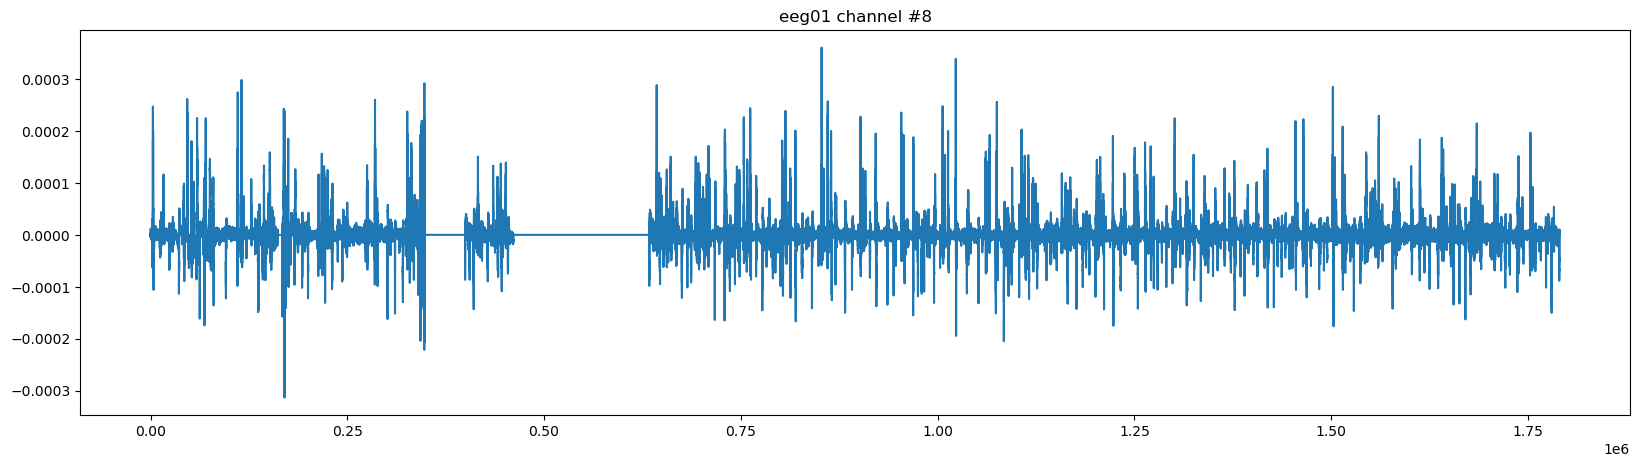

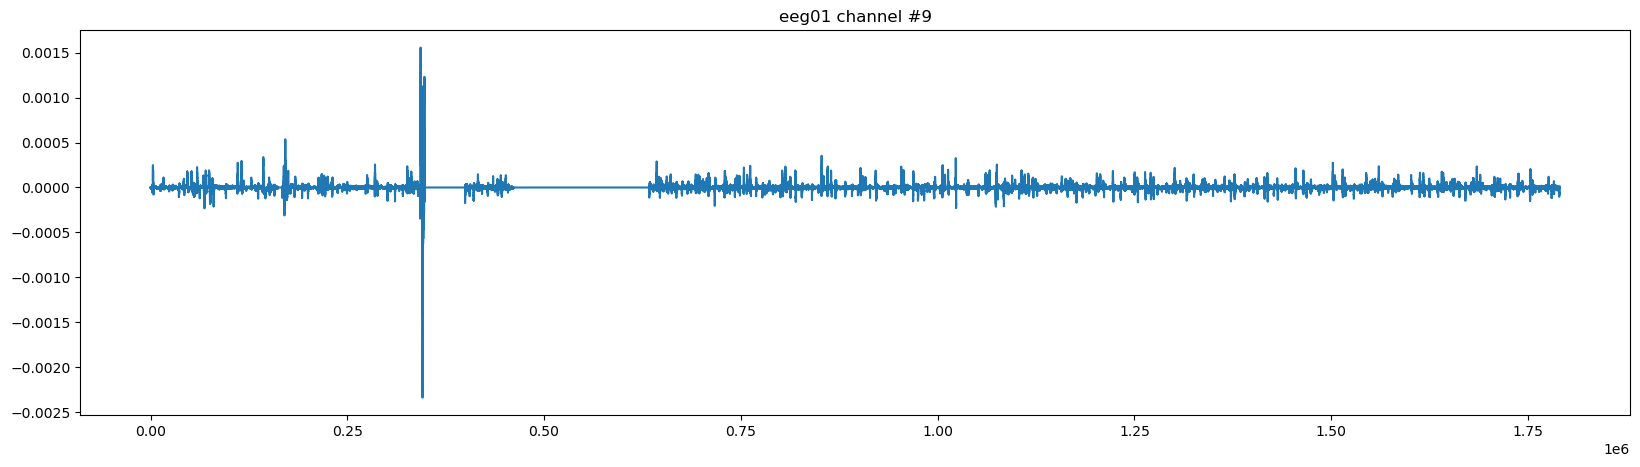

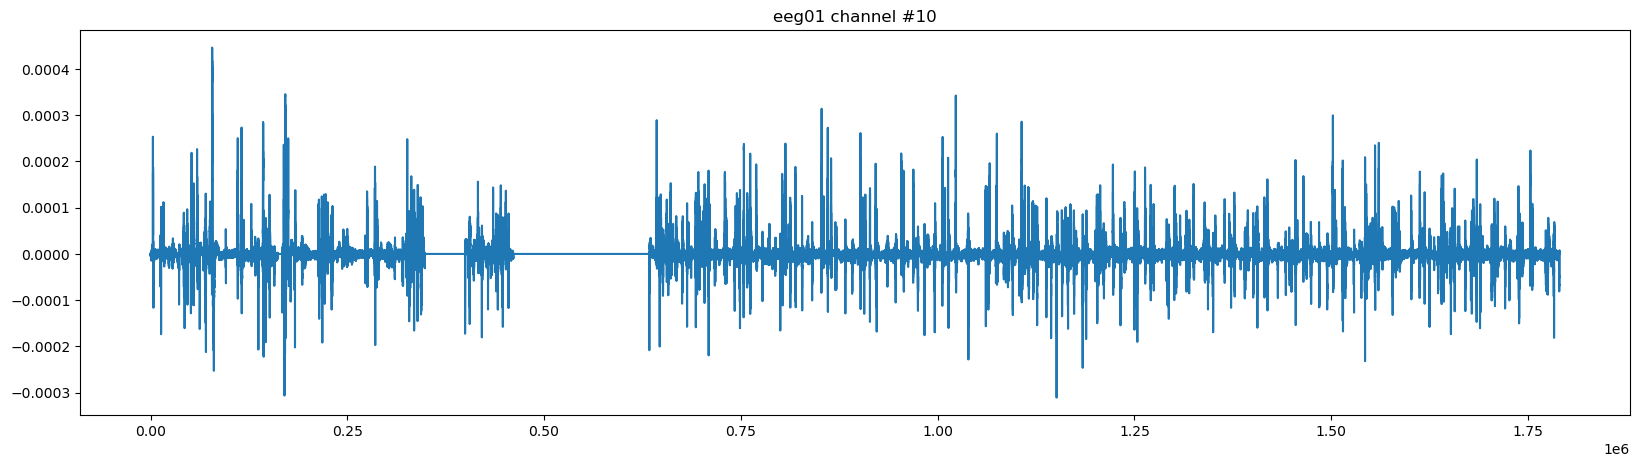

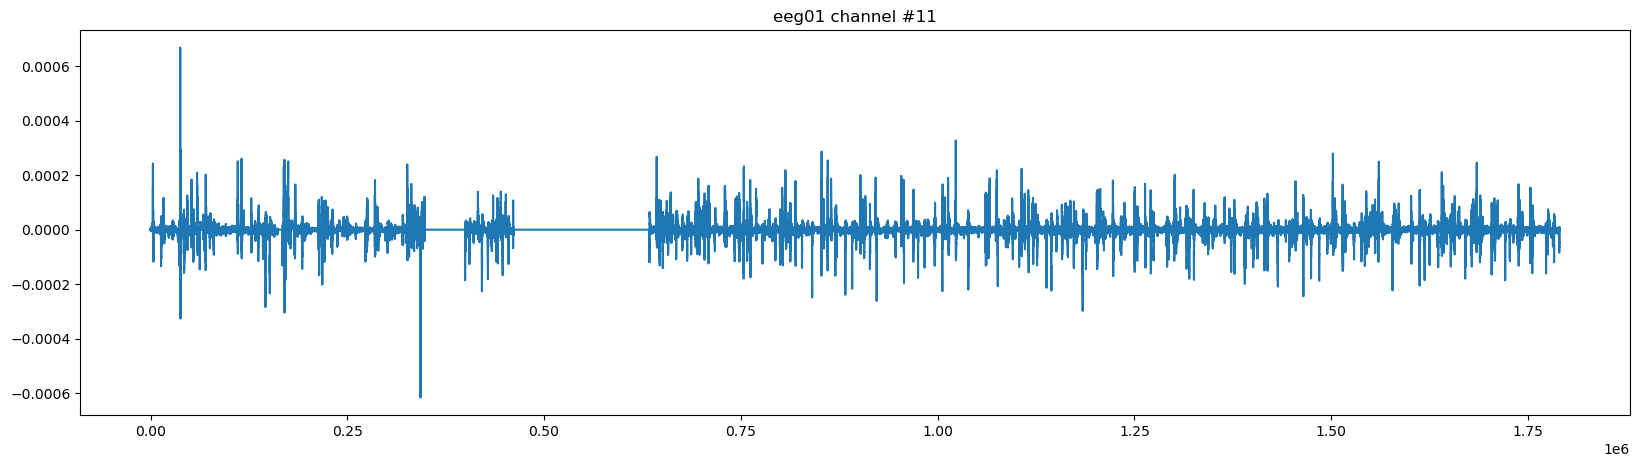

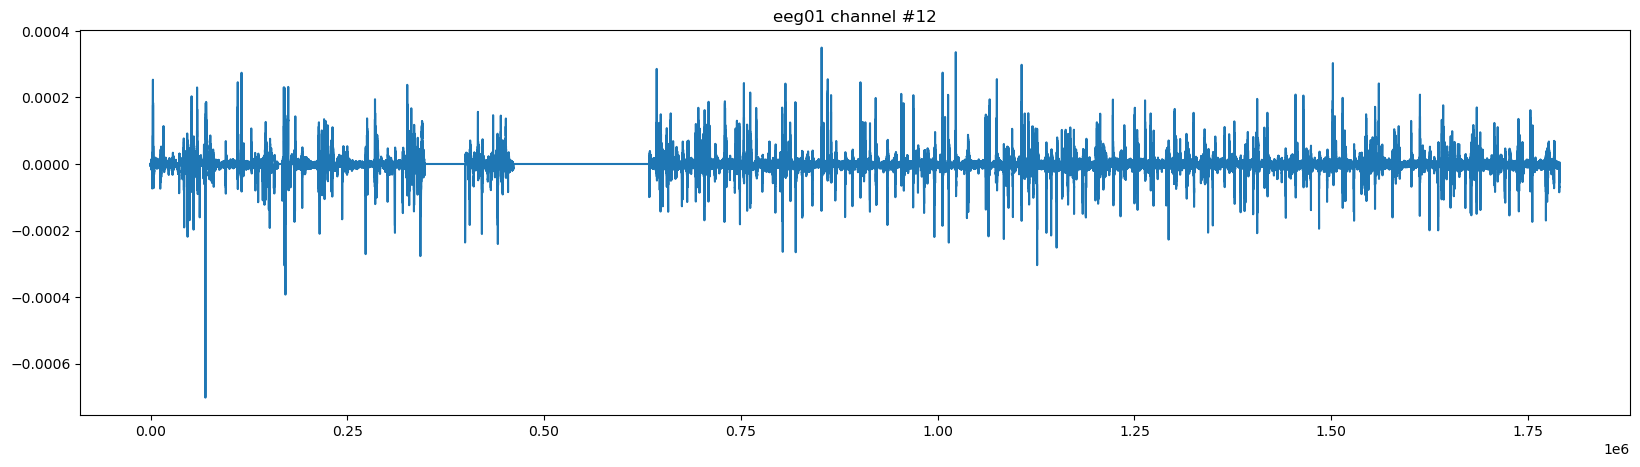

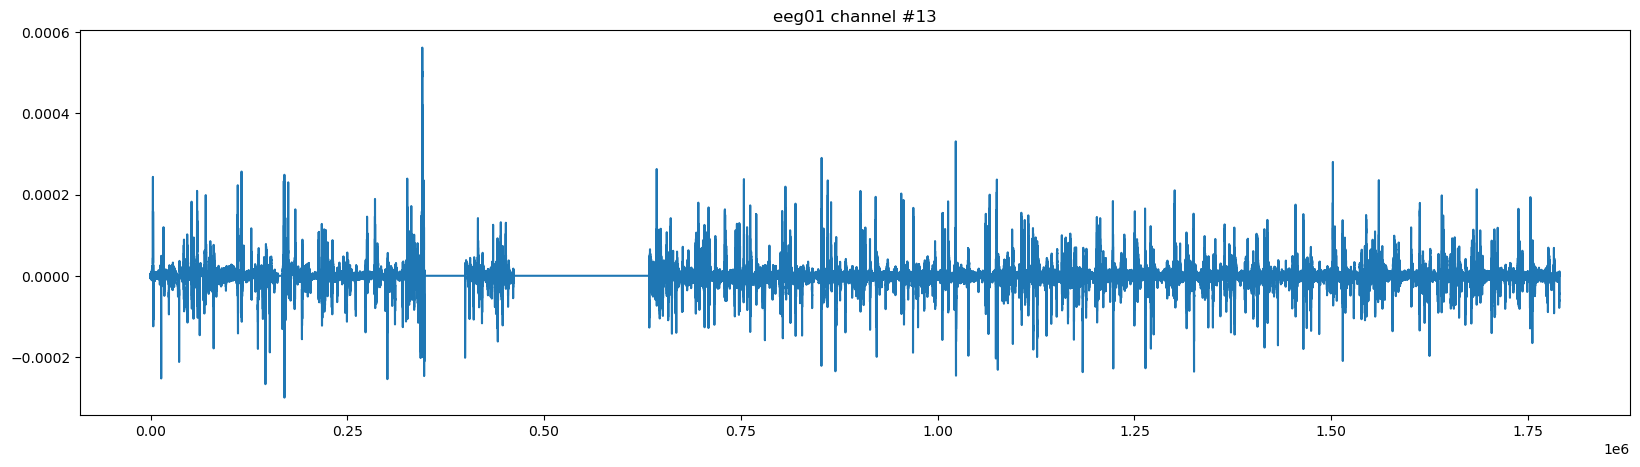

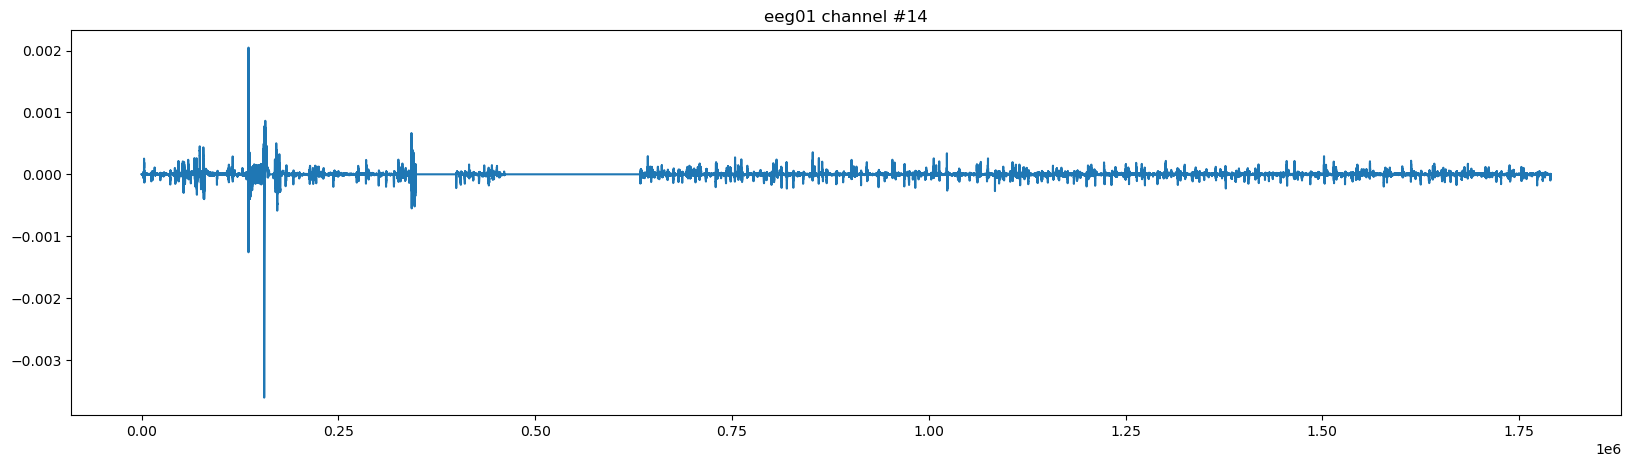

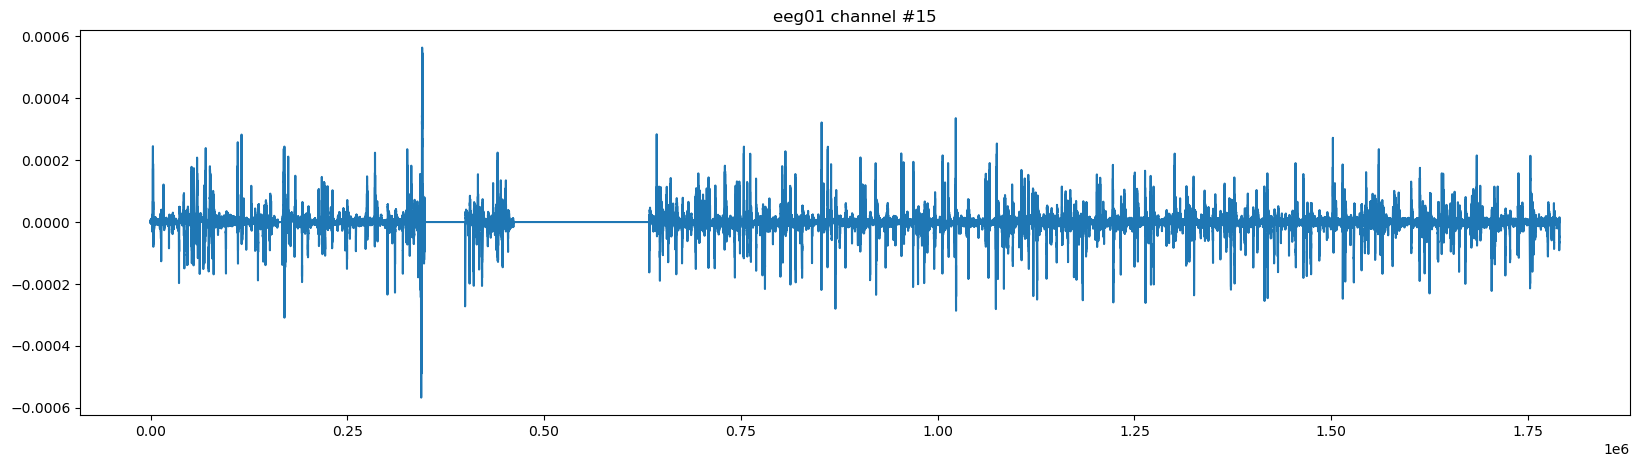

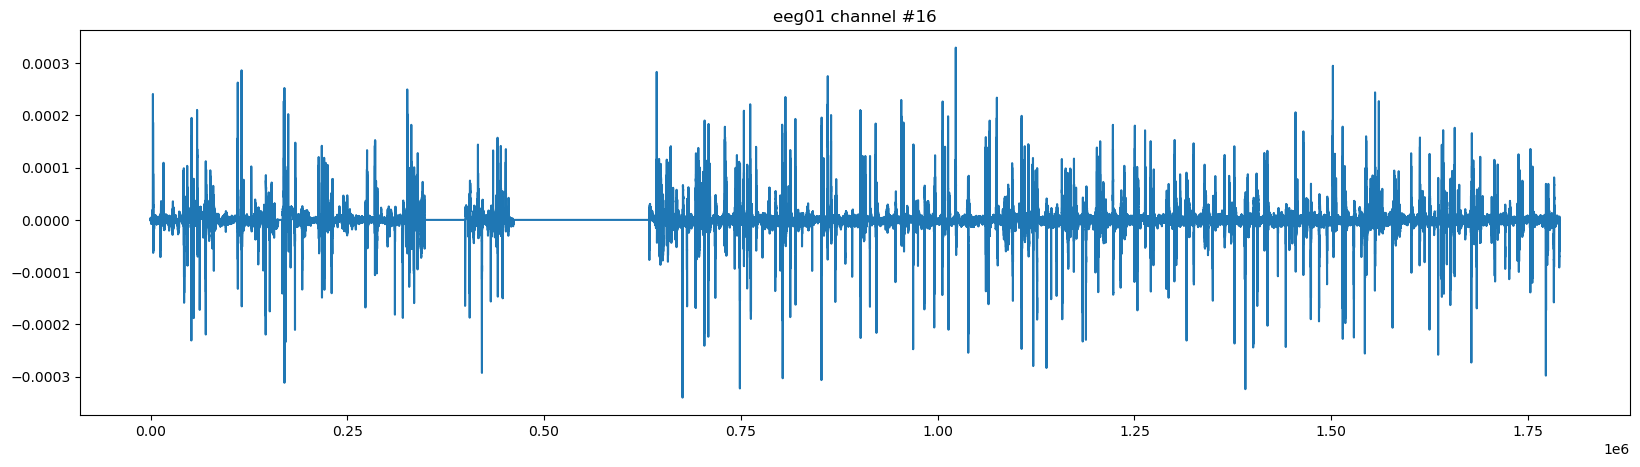

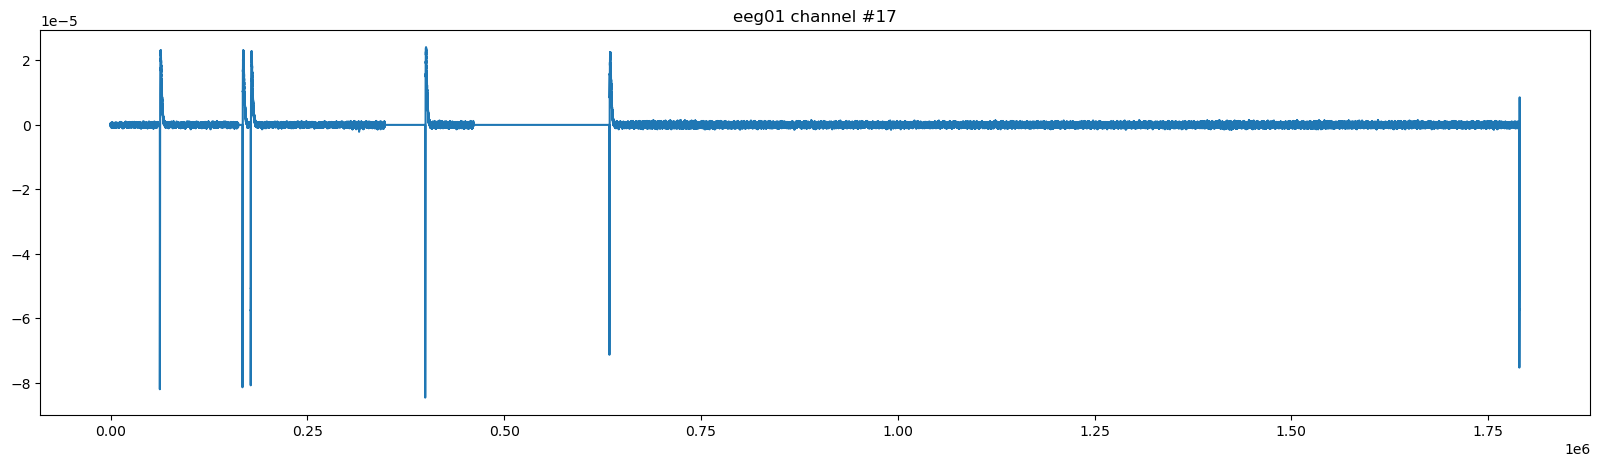

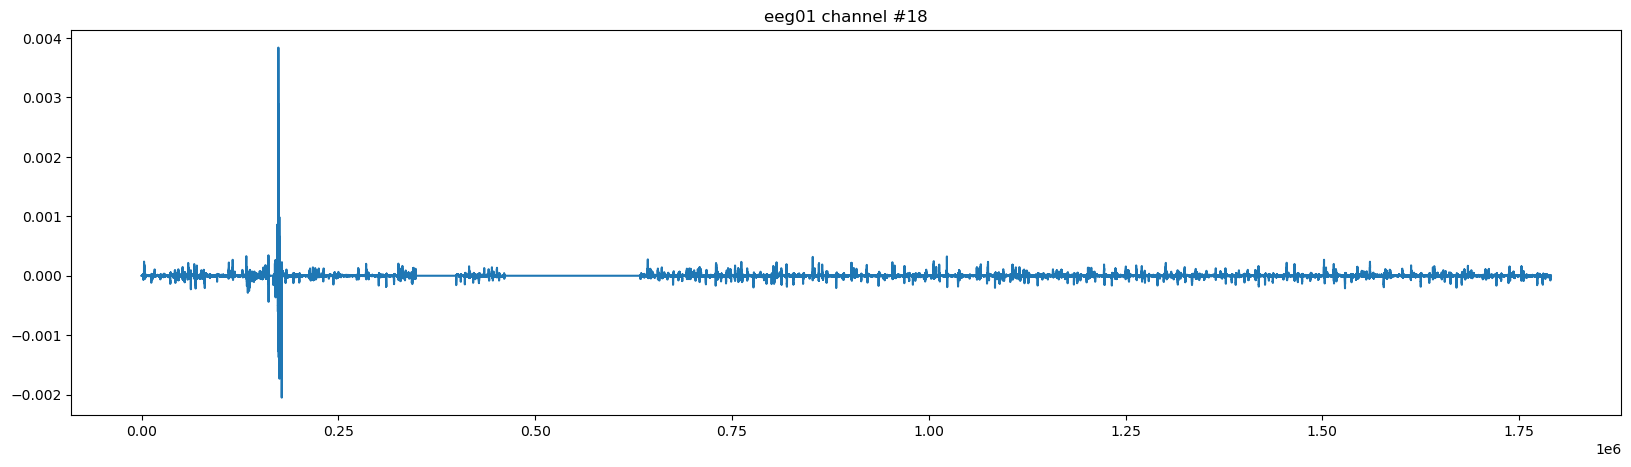

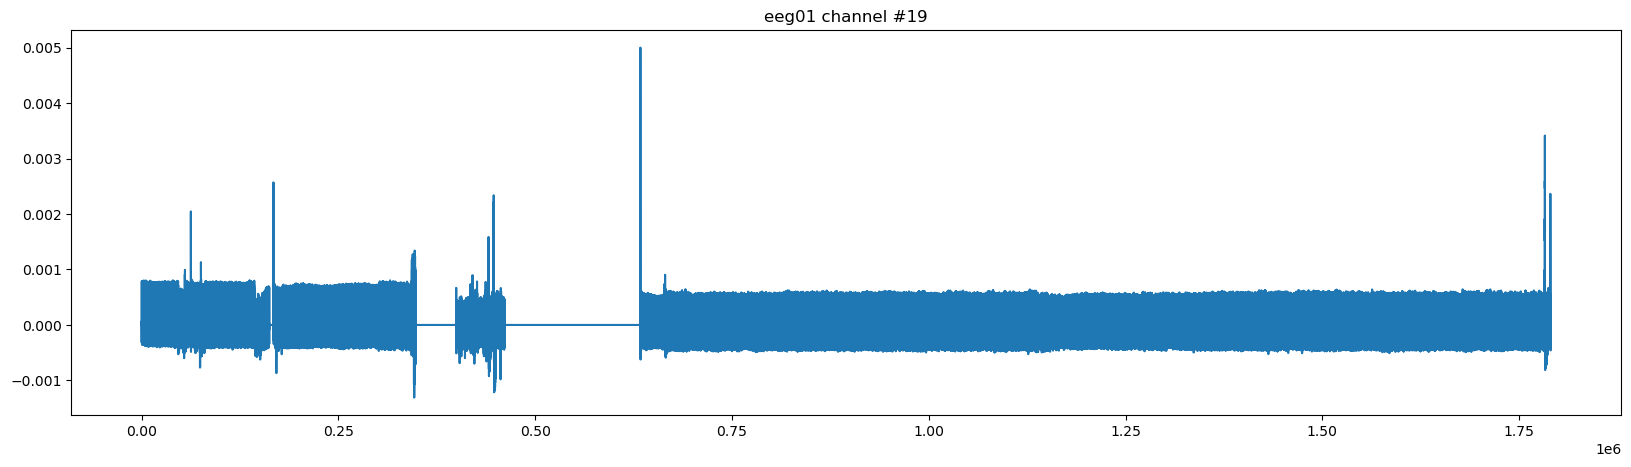

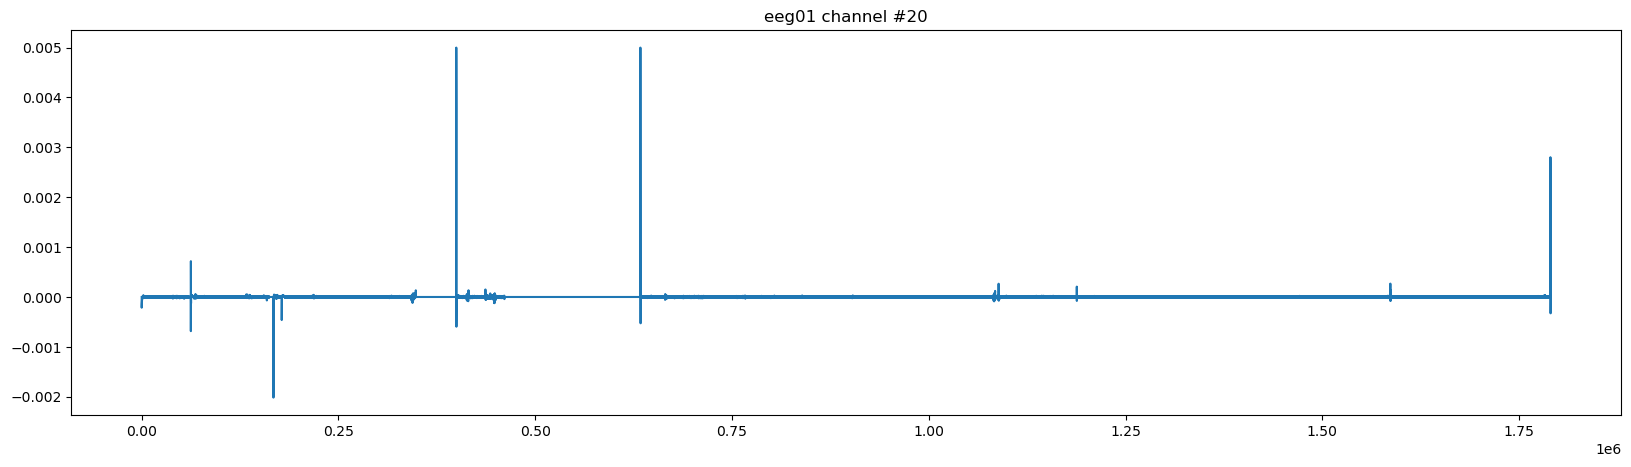

In [93]:
def plot_eeg_data(eeg_dict, eeg_name):
    eeg_data = eeg_dict[eeg_name].get_data()
    data_shape = eeg_data.shape
    
    for i in range(data_shape[0]):
        plt.figure(figsize=(20,5))
        plt.title(eeg_name + " channel #" + str(i))
        plt.plot(range(data_shape[1]), eeg_data[i])
    return
# eeg_dict['eeg01'].get_data()[0]
# plt.figure(figsize=(20,10))
# plt.title(eeg_name_list[0] + " channel #" + str(1))
# plt.plot(range(len(eeg_dict['eeg01'].get_data()[0])), eeg_dict['eeg01'].get_data()[0])
# plt.figure()
# plt.title(eeg_name_list[1] + " channel #" + str(1))
# plt.plot(range(len(eeg_dict['eeg02'].get_data()[0])), eeg_dict['eeg02'].get_data()[0])

plot_eeg_data(eeg_dict, eeg_name_list[0])